In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras import layers
from keras.layers import Activation, Dense, Dropout
from keras.callbacks import EarlyStopping
from hyperas import optim
from hyperas.distributions import choice, uniform
from hyperopt import Trials, STATUS_OK, tpe


Using TensorFlow backend.


In [2]:
def data():
    """
    Data providing function:

    This function is separated from create_model() so that hyperopt
    won't reload data for each evaluation run.
    """
    df = pd.read_csv("./stockPrice.csv", header=0, na_values='.')

    lol = df.copy()
    lol["1pred"] = (df["close"].shift(-1) - df["close"]) / df["close"]
    lol["3pred"] = (df["close"].shift(-3) - df["close"]) / df["close"]
    lol["5pred"] = (df["close"].shift(-5) - df["close"]) / df["close"]
    lol["10pred"] = (df["close"].shift(-10) - df["close"]) / df["close"]

    lol.loc[df["close"].shift(-1) > df["close"] , '1predB'] = 0
    lol.loc[df["close"].shift(-1) < df["close"] , '1predB'] = 1
    lol.loc[df["close"].shift(-1) > df["close"] , '3predB'] = 0
    lol.loc[df["close"].shift(-1) < df["close"] , '3predB'] = 1
    lol.loc[df["close"].shift(-1) > df["close"] , '5predB'] = 0
    lol.loc[df["close"].shift(-1) < df["close"] , '5predB'] = 1
    lol.loc[df["close"].shift(-1) > df["close"] , '10predB'] = 0
    lol.loc[df["close"].shift(-1) < df["close"] , '10predB'] = 1

    lol["5max"] = lol["close"].rolling(window=5).max()
    lol["10max"] = lol["close"].rolling(window=10).max()
    lol["20max"] = lol["close"].rolling(window=20).max()

    lol["5low"] = lol["close"].rolling(window=5).min()
    lol["10low"] = lol["close"].rolling(window=10).min()
    lol["20low"] = lol["close"].rolling(window=20).min()

    lol["vol%"] =  (df["vol"] - df["vol"].shift(1)) /df["vol"].shift(1)

    lol = lol.dropna()    

    dfC = pd.DataFrame()
    dfC["vol"] = lol["vol%"]
    dfC["sma10"] = lol["sma10"] / lol["close"]
    dfC["sma20"] = lol["sma20"] / lol["close"]
    dfC["sma50"] = lol["sma50"] / lol["close"]
    dfC["sma100"] = lol["sma100"] / lol["close"]
    dfC["vwap"] = lol["vwap"]
    dfC["bbmid"] = lol["bbmid"] / lol["close"]
    dfC["bbUpper"] = lol["bbUpper"] / lol["close"]
    dfC["bbLower"] = lol["bbLower"] / lol["close"]
    dfC["cci"] = lol["cci"] 
    dfC["rsi"] = lol["rsi"] 
    dfC["5max"] = lol["5max"] / lol["close"]
    dfC["10max"] = lol["10max"] / lol["close"]
    dfC["20max"] = lol["20max"] / lol["close"]
    dfC["5low"] = lol["5low"] / lol["close"]
    dfC["10low"] = lol["10low"] / lol["close"]
    dfC["20low"] = lol["20low"] / lol["close"]
    dfC["1pred"] = lol["1pred"]
    dfC["3pred"] = lol["3pred"]
    dfC["5pred"] = lol["5pred"]
    dfC["10pred"] = lol["10pred"]
    dfC["1predB"] = lol["1predB"]
    dfC["3predB"] = lol["3predB"]
    dfC["5predB"] = lol["5predB"]
    dfC["10predB"] = lol["10predB"]

    dfC.replace([np.inf, -np.inf], np.nan)
    dfC.dropna(inplace=True)

    X = dfC[['sma10', 'sma20', 'sma50', 'sma100', 'vwap', 'bbmid', 'bbUpper', 'bbLower', 'cci', 'rsi', '5max', '10max', '20max', '5low', '10low', '20low']]
    Y = dfC[["1pred"]]

    print(Y.head())
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

    return x_train, y_train, x_test, y_test


def create_model(x_train, y_train, x_test, y_test):
    """
    Model providing function:

    Create Keras model with double curly brackets dropped-in as needed.
    Return value has to be a valid python dictionary with two customary keys:
        - loss: Specify a numeric evaluation metric to be minimized
        - status: Just use STATUS_OK and see hyperopt documentation if not feasible
    The last one is optional, though recommended, namely:
        - model: specify the model just created so that we can later use it again.
    """
    input_dim = x_train.shape[1]  # Number of features
    output_dim = y_train.shape[1]  # Number of features
    print(input_dim)

    model = Sequential()

    model.add(Dense(512, input_dim=input_dim))
    model.add(Activation({{choice(['relu', 'sigmoid','softmax'])}}))
    model.add(Dense({{choice([256, 512, 1024])}}))
    model.add(Activation({{choice(['relu', 'sigmoid','softmax'])}}))
    model.add(Dense({{choice([256, 512, 1024])}}))
    model.add(Activation({{choice(['relu', 'sigmoid','softmax'])}}))

    # If we choose 'four', add an additional fourth layer
    if {{choice(['three', 'four'])}} == 'four':
        model.add(Dense(100))
        # We can also choose between complete sets of layers
        model.add({{choice([Dropout(0.5), Activation('linear')])}})
        model.add(Activation({{choice(['relu', 'sigmoid','softmax'])}}))
        
    model.add(Dense(output_dim))
    model.add(Activation('linear'))

    model.compile(loss='mean_absolute_percentage_error', metrics=['mse', 'mae', 'mape', 'cosine'],
                  optimizer={{choice(['rmsprop', 'adam', 'sgd'])}})

    result = model.fit(x_train, y_train,
            batch_size={{choice([16, 32, 64])}},
             epochs=50,
             validation_split=0.1)

    #get the highest validation accuracy of the training epochs
#     validation_acc = np.amax(result.history['val_acc'])
    mse = np.amax(result.history['mean_absolute_percentage_error']) 

    print('Best validation acc of epoch:', mse)
    return {'loss': -mse, 'status': STATUS_OK, 'model': model}



best_run, best_model = optim.minimize(model=create_model,
                                      data=data,
                                      algo=tpe.suggest,
                                      max_evals=5,
                                      notebook_name='kerasPrice',
                                      trials=Trials())

X_train, Y_train, X_test, Y_test = data()
print("Evalutation of best performing model:")
print(best_model.evaluate(X_test, Y_test))
print("Best performing model chosen hyper-parameters:")
print(best_run)

>>> Imports:
#coding=utf-8

try:
    import pandas as pd
except:
    pass

try:
    import glob
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    from sklearn.preprocessing import MinMaxScaler
except:
    pass

try:
    import seaborn as sns
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import tensorflow as tf
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    from sklearn import preprocessing
except:
    pass

try:
    from sklearn.metrics import accuracy_score
except:
    pass

try:
    from sklearn.metrics import confusion_matrix
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras import layers
except:
    pass

try:
    from keras.layers import Activation, Dense, Dropout
except:
    pass

try:
    from keras.callbacks import EarlyStopping
except:
    pass

try:
    from hyperas import optim
except:
    pass

try:
   

Instructions for updating:
Use tf.cast instead.
Train on 1543 samples, validate on 172 samples                                                                         
Epoch 1/50                                                                                                             
  32/1543 [..............................]                                                                             
 - ETA: 2:35 - loss: 31625.3125 - mean_squared_error: 1.7135 - mean_absolute_error: 1.3089 - mean_absolute_percentage_error: 31625.3125 - cosine_proximity: 0.4375
                                                                                                                      
 288/1543 [====>.........................]                                                                             
 - ETA: 14s - loss: 87483299.2569 - mean_squared_error: 12341882.9074 - mean_absolute_error: 2849.4303 - mean_absolute_percentage_error: 87483299.2569 - cosine_proximity: 0.0833
            

 - ETA: 0s - loss: 77059071.0357 - mean_squared_error: 8850898.7790 - mean_absolute_error: 2516.5792 - mean_absolute_percentage_error: 77059071.0357 - cosine_proximity: -0.0156
                                                                                                                      
1152/1543 [=====================>........]                                                                             
 - ETA: 0s - loss: 76072646.7500 - mean_squared_error: 8562254.7309 - mean_absolute_error: 2492.0821 - mean_absolute_percentage_error: 76072646.7500 - cosine_proximity: -0.0278
                                                                                                                      
1344/1543 [=========================>....]                                                                             
 - ETA: 0s - loss: 73429463.7857 - mean_squared_error: 8153679.3348 - mean_absolute_error: 2446.5261 - mean_absolute_percentage_error: 73429463.7857 - cosine_proximity:

 - ETA: 0s - loss: 84967544.0000 - mean_squared_error: 11362485.7045 - mean_absolute_error: 2796.1816 - mean_absolute_percentage_error: 84967544.0000 - cosine_proximity: -0.0682     
                                                                                                                       
 672/1543 [============>.................]                                                                             
 - ETA: 0s - loss: 75957182.5714 - mean_squared_error: 10205163.2277 - mean_absolute_error: 2551.8129 - mean_absolute_percentage_error: 75957182.5714 - cosine_proximity: -0.0714
                                                                                                                       
 960/1543 [=================>............]                                                                             
 - ETA: 0s - loss: 67690699.6000 - mean_squared_error: 8485382.1292 - mean_absolute_error: 2306.7906 - mean_absolute_percentage_error: 67690699.6000 - cosine_p

 - ETA: 0s - loss: 260176224.0000 - mean_squared_error: 55414908.0000 - mean_absolute_error: 7385.8867 - mean_absolute_percentage_error: 260176224.0000 - cosine_proximity: -0.2500
                                                                                                                       
 320/1543 [=====>........................]                                                                             
 - ETA: 0s - loss: 84663303.2000 - mean_squared_error: 11447675.7812 - mean_absolute_error: 2738.2888 - mean_absolute_percentage_error: 84663303.2000 - cosine_proximity: 0.0125   
                                                                                                                      
 544/1543 [=========>....................]                                                                             
 - ETA: 0s - loss: 66070017.0588 - mean_squared_error: 8508759.2537 - mean_absolute_error: 2336.2259 - mean_absolute_percentage_error: 66070017.0588 - cosine_pro

                                                                                                                      
 544/1543 [=========>....................]                                                                             
 - ETA: 0s - loss: 71910132.0588 - mean_squared_error: 7091538.3621 - mean_absolute_error: 2219.6840 - mean_absolute_percentage_error: 71910132.0588 - cosine_proximity: -0.0625
                                                                                                                      
 768/1543 [=============>................]                                                                             
 - ETA: 0s - loss: 72450104.9583 - mean_squared_error: 7222883.9362 - mean_absolute_error: 2272.8510 - mean_absolute_percentage_error: 72450104.9583 - cosine_proximity: -0.0807
                                                                                                                      
1024/1543 [==================>...........]       

 - ETA: 0s - loss: 60866069.8409 - mean_squared_error: 6252133.1420 - mean_absolute_error: 1998.9673 - mean_absolute_percentage_error: 60866069.8409 - cosine_proximity: 0.0597
                                                                                                                       
 864/1543 [===============>..............]                                                                             
 - ETA: 0s - loss: 66145490.9074 - mean_squared_error: 6576647.5775 - mean_absolute_error: 2054.0374 - mean_absolute_percentage_error: 66145490.9074 - cosine_proximity: 0.0463
                                                                                                                       
 992/1543 [==================>...........]                                                                             
 - ETA: 0s - loss: 63339082.3387 - mean_squared_error: 6261986.1663 - mean_absolute_error: 2009.7459 - mean_absolute_percentage_error: 63339082.3387 - cosine_proximity:

 928/1543 [=================>............]                                                                             
 - ETA: 0s - loss: 65225998.0690 - mean_squared_error: 6912918.3869 - mean_absolute_error: 2254.3096 - mean_absolute_percentage_error: 65225998.0690 - cosine_proximity: 0.0108
                                                                                                                       
1152/1543 [=====================>........]                                                                             
 - ETA: 0s - loss: 66560420.0000 - mean_squared_error: 6968251.6589 - mean_absolute_error: 2239.0947 - mean_absolute_percentage_error: 66560420.0000 - cosine_proximity: 0.0087
                                                                                                                       
1376/1543 [=========================>....]                                                                             
 - ETA: 0s - loss: 70155584.0465 - mean_squared_

                                                                                                                       
1344/1543 [=========================>....]                                                                             
 - ETA: 0s - loss: 61852017.0952 - mean_squared_error: 7168221.8839 - mean_absolute_error: 2121.0533 - mean_absolute_percentage_error: 61852017.0952 - cosine_proximity: 0.0327
                                                                                                                       
1543/1543 [==============================]                                                                             
 - 0s 249us/step - loss: 64507022.2553 - mean_squared_error: 7189843.2774 - mean_absolute_error: 2153.8784 - mean_absolute_percentage_error: 64507022.2553 - cosine_proximity: 0.0447 - val_loss: 42185460.2791 - val_mean_squared_error: 2073026.5581 - val_mean_absolute_error: 1439.8009 - val_mean_absolute_percentage_error: 42185460.2791 - val_co

 - 0s 270us/step - loss: 66886427.8756 - mean_squared_error: 7405087.3487 - mean_absolute_error: 2196.2019 - mean_absolute_percentage_error: 66886427.8756 - cosine_proximity: 0.0032 - val_loss: 52234769.3023 - val_mean_squared_error: 3178328.9244 - val_mean_absolute_error: 1782.7869 - val_mean_absolute_percentage_error: 52234769.3023 - val_cosine_proximity: -0.1163

Epoch 20/50                                                                                                            
  32/1543 [..............................]                                                                             
 - ETA: 0s - loss: 75271232.0000 - mean_squared_error: 7171859.0000 - mean_absolute_error: 2491.8408 - mean_absolute_percentage_error: 75271232.0000 - cosine_proximity: 0.3125
                                                                                                                       
 288/1543 [====>.........................]                                                     

 - ETA: 0s - loss: 104267904.0000 - mean_squared_error: 20952012.0000 - mean_absolute_error: 4515.4463 - mean_absolute_percentage_error: 104267904.0000 - cosine_proximity: 0.0625
                                                                                                                      
 288/1543 [====>.........................]                                                                             
 - ETA: 0s - loss: 57016722.1111 - mean_squared_error: 8227038.7361 - mean_absolute_error: 2281.5658 - mean_absolute_percentage_error: 57016722.1111 - cosine_proximity: -0.0139  
                                                                                                                      
 480/1543 [========>.....................]                                                                             
 - ETA: 0s - loss: 82427064.7333 - mean_squared_error: 10690994.6417 - mean_absolute_error: 2810.4280 - mean_absolute_percentage_error: 82427064.7333 - cosine_proxi

                                                                                                                      
 320/1543 [=====>........................]                                                                             
 - ETA: 0s - loss: 52763453.6000 - mean_squared_error: 4959123.1250 - mean_absolute_error: 1927.7303 - mean_absolute_percentage_error: 52763453.6000 - cosine_proximity: -0.0688
                                                                                                                      
 544/1543 [=========>....................]                                                                             
 - ETA: 0s - loss: 51709818.3529 - mean_squared_error: 5415150.4338 - mean_absolute_error: 1995.6082 - mean_absolute_percentage_error: 51709818.3529 - cosine_proximity: -0.0221
                                                                                                                      
 768/1543 [=============>................]       

 - ETA: 0s - loss: 64738608.0000 - mean_squared_error: 6998769.5844 - mean_absolute_error: 2226.0040 - mean_absolute_percentage_error: 64738608.0000 - cosine_proximity: -0.0531
                                                                                                                      
 864/1543 [===============>..............]                                                                             
 - ETA: 0s - loss: 61208646.3704 - mean_squared_error: 6320073.3495 - mean_absolute_error: 2071.1241 - mean_absolute_percentage_error: 61208646.3704 - cosine_proximity: -0.0463
                                                                                                                      
1088/1543 [====================>.........]                                                                             
 - ETA: 0s - loss: 60328901.4706 - mean_squared_error: 6065888.6507 - mean_absolute_error: 2042.0194 - mean_absolute_percentage_error: 60328901.4706 - cosine_proximity:

1152/1543 [=====================>........]                                                                             
 - ETA: 0s - loss: 68949863.0556 - mean_squared_error: 8062225.5330 - mean_absolute_error: 2300.5421 - mean_absolute_percentage_error: 68949863.0556 - cosine_proximity: 0.0347
                                                                                                                       
1376/1543 [=========================>....]                                                                             
 - ETA: 0s - loss: 71362752.4186 - mean_squared_error: 8498323.3430 - mean_absolute_error: 2376.8214 - mean_absolute_percentage_error: 71362752.4186 - cosine_proximity: 0.0451
                                                                                                                       
1543/1543 [==============================]                                                                             
 - 0s 248us/step - loss: 69739455.3390 - mean_sq

                                                                                                                      
1543/1543 [==============================]                                                                             
 - 0s 243us/step - loss: 66349262.5327 - mean_squared_error: 7295970.9686 - mean_absolute_error: 2276.3434 - mean_absolute_percentage_error: 66349262.5327 - cosine_proximity: -0.0395 - val_loss: 17570904.6047 - val_mean_squared_error: 359638.3110 - val_mean_absolute_error: 599.6985 - val_mean_absolute_percentage_error: 17570904.6047 - val_cosine_proximity: -0.1163

Epoch 31/50                                                                                                            
  32/1543 [..............................]                                                                             
 - ETA: 0s - loss: 33200288.0000 - mean_squared_error: 812171.8125 - mean_absolute_error: 788.6444 - mean_absolute_percentage_error: 33200288.0000 - cosi

 288/1543 [====>.........................]                                                                             
 - ETA: 0s - loss: 75289364.6667 - mean_squared_error: 7198427.0903 - mean_absolute_error: 2277.5817 - mean_absolute_percentage_error: 75289364.6667 - cosine_proximity: 0.0278
                                                                                                                       
 512/1543 [========>.....................]                                                                             
 - ETA: 0s - loss: 74843173.6250 - mean_squared_error: 7531746.4102 - mean_absolute_error: 2399.1483 - mean_absolute_percentage_error: 74843173.6250 - cosine_proximity: 0.0078
                                                                                                                       
 736/1543 [=============>................]                                                                             
 - ETA: 0s - loss: 71290380.2609 - mean_squared_

                                                                                                                       
 960/1543 [=================>............]                                                                             
 - ETA: 0s - loss: 78439243.8333 - mean_squared_error: 7777208.1125 - mean_absolute_error: 2416.6662 - mean_absolute_percentage_error: 78439243.8333 - cosine_proximity: 0.0333
                                                                                                                       
1184/1543 [======================>.......]                                                                             
 - ETA: 0s - loss: 75600039.5405 - mean_squared_error: 7922876.8277 - mean_absolute_error: 2414.4444 - mean_absolute_percentage_error: 75600039.5405 - cosine_proximity: 0.0422
                                                                                                                       
1408/1543 [==========================>...]      

 - ETA: 0s - loss: 64347444.9024 - mean_squared_error: 7375915.9177 - mean_absolute_error: 2211.3464 - mean_absolute_percentage_error: 64347444.9024 - cosine_proximity: -0.0107
                                                                                                                      
1536/1543 [============================>.]                                                                             
 - ETA: 0s - loss: 64840188.2292 - mean_squared_error: 7385410.2721 - mean_absolute_error: 2232.0598 - mean_absolute_percentage_error: 64840188.2292 - cosine_proximity: -0.0013
                                                                                                                      
1543/1543 [==============================]                                                                             
 - 0s 268us/step - loss: 64951535.6267 - mean_squared_error: 7381594.5337 - mean_absolute_error: 2233.0697 - mean_absolute_percentage_error: 64951535.6267 - cosine_prox

                                                                                                                      
1543/1543 [==============================]                                                                             
 - 0s 245us/step - loss: 63871048.9592 - mean_squared_error: 7275784.1638 - mean_absolute_error: 2214.9117 - mean_absolute_percentage_error: 63871048.9592 - cosine_proximity: -0.0110 - val_loss: 39188612.9302 - val_mean_squared_error: 1788953.2006 - val_mean_absolute_error: 1337.5176 - val_mean_absolute_percentage_error: 39188612.9302 - val_cosine_proximity: -0.1163

Epoch 40/50                                                                                                            
  32/1543 [..............................]                                                                             
 - ETA: 0s - loss: 53384368.0000 - mean_squared_error: 4063366.7500 - mean_absolute_error: 1915.8329 - mean_absolute_percentage_error: 53384368.0000 - 

  32/1543 [..............................]                                                                             
 - ETA: 0s - loss: 161864224.0000 - mean_squared_error: 42817040.0000 - mean_absolute_error: 6500.1704 - mean_absolute_percentage_error: 161864224.0000 - cosine_proximity: 0.1875
                                                                                                                      
 288/1543 [====>.........................]                                                                             
 - ETA: 0s - loss: 87715488.2222 - mean_squared_error: 10663994.0208 - mean_absolute_error: 2834.7756 - mean_absolute_percentage_error: 87715488.2222 - cosine_proximity: 0.0903  
                                                                                                                      
 512/1543 [========>.....................]                                                                             
 - ETA: 0s - loss: 68787850.3750 - mean_squa

                                                                                                                       
 736/1543 [=============>................]                                                                             
 - ETA: 0s - loss: 70036480.6957 - mean_squared_error: 7858346.3152 - mean_absolute_error: 2306.6794 - mean_absolute_percentage_error: 70036480.6957 - cosine_proximity: 0.0353
                                                                                                                       
 928/1543 [=================>............]                                                                             
 - ETA: 0s - loss: 66450003.4483 - mean_squared_error: 7500467.8362 - mean_absolute_error: 2283.6065 - mean_absolute_percentage_error: 66450003.4483 - cosine_proximity: 0.0474
                                                                                                                       
1152/1543 [=====================>........]      

 - ETA: 0s - loss: 60515162.9722 - mean_squared_error: 7219296.8802 - mean_absolute_error: 2227.2677 - mean_absolute_percentage_error: 60515162.9722 - cosine_proximity: 0.0035
                                                                                                                       
1376/1543 [=========================>....]                                                                             
 - ETA: 0s - loss: 70462017.3721 - mean_squared_error: 8207351.9288 - mean_absolute_error: 2375.8289 - mean_absolute_percentage_error: 70462017.3721 - cosine_proximity: 0.0044
                                                                                                                       
1543/1543 [==============================]                                                                             
 - 0s 246us/step - loss: 69242141.8639 - mean_squared_error: 7925725.4245 - mean_absolute_error: 2317.6271 - mean_absolute_percentage_error: 69242141.8639 - cosine_prox

1543/1543 [==============================]                                                                             
 - 0s 267us/step - loss: 64789468.4848 - mean_squared_error: 6776541.5139 - mean_absolute_error: 2189.1619 - mean_absolute_percentage_error: 64789468.4848 - cosine_proximity: 0.0019 - val_loss: 62286182.1395 - val_mean_squared_error: 4519215.6628 - val_mean_absolute_error: 2125.8447 - val_mean_absolute_percentage_error: 62286182.1395 - val_cosine_proximity: -0.1163

Epoch 49/50                                                                                                            
  32/1543 [..............................]                                                                             
 - ETA: 0s - loss: 133704976.0000 - mean_squared_error: 16170546.0000 - mean_absolute_error: 3925.6665 - mean_absolute_percentage_error: 133704976.0000 - cosine_proximity: 0.1875
                                                                                            


Best validation acc of epoch:                                                                                          
74818648.80492547                                                                                                      
16                                                                                                                     
Train on 1543 samples, validate on 172 samples                                                                         
Epoch 1/50                                                                                                             
  64/1543 [>.............................]                                                                             
 - ETA: 7s - loss: 309.2291 - mean_squared_error: 1.8359e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 309.2291 - cosine_proximity: 0.0938
                                                                                                                      

 - ETA: 0s - loss: 103.3372 - mean_squared_error: 2.2385e-04 - mean_absolute_error: 0.0105 - mean_absolute_percentage_error: 103.3372 - cosine_proximity: -0.0781
                                                                                                                       
 960/1543 [=================>............]                                                                             
 - ETA: 0s - loss: 102.4218 - mean_squared_error: 2.2770e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 102.4218 - cosine_proximity: -0.0667
                                                                                                                       
1344/1543 [=========================>....]                                                                             
 - ETA: 0s - loss: 107.5061 - mean_squared_error: 2.2171e-04 - mean_absolute_error: 0.0107 - mean_absolute_percentage_error: 107.5061 - cosine_proximity: -0.0625
                                  

 - 0s 140us/step - loss: 106.7511 - mean_squared_error: 2.4122e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 106.7511 - cosine_proximity: -0.0447 - val_loss: 135.3521 - val_mean_squared_error: 1.6810e-04 - val_mean_absolute_error: 0.0097 - val_mean_absolute_percentage_error: 135.3521 - val_cosine_proximity: -0.1163

Epoch 8/50                                                                                                             
  64/1543 [>.............................]                                                                             
 - ETA: 0s - loss: 130.8997 - mean_squared_error: 2.9449e-04 - mean_absolute_error: 0.0123 - mean_absolute_percentage_error: 130.8997 - cosine_proximity: 7.4506e-09
                                                                                                                      
 576/1543 [==========>...................]                                                                             
 - ETA: 0s - los

                                                                                                                      
1408/1543 [==========================>...]                                                                             
 - ETA: 0s - loss: 108.6897 - mean_squared_error: 2.4030e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 108.6897 - cosine_proximity: -0.0057
                                                                                                                       
1543/1543 [==============================]                                                                             
 - 0s 135us/step - loss: 108.9595 - mean_squared_error: 2.4228e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 108.9595 - cosine_proximity: -0.0123 - val_loss: 158.6585 - val_mean_squared_error: 1.7150e-04 - val_mean_absolute_error: 0.0098 - val_mean_absolute_percentage_error: 158.6585 - val_cosine_proximity: -0.1163

Epoch 12/50        

 - ETA: 0s - loss: 107.4193 - mean_squared_error: 2.8073e-04 - mean_absolute_error: 0.0113 - mean_absolute_percentage_error: 107.4193 - cosine_proximity: 0.0898
                                                                                                                      
 896/1543 [================>.............]                                                                             
 - ETA: 0s - loss: 104.6171 - mean_squared_error: 2.5364e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 104.6171 - cosine_proximity: 0.0580
                                                                                                                      
1280/1543 [=======================>......]                                                                             
 - ETA: 0s - loss: 106.0211 - mean_squared_error: 2.3949e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 106.0211 - cosine_proximity: 0.0641
                                       

Epoch 19/50                                                                                                            
  64/1543 [>.............................]                                                                             
 - ETA: 0s - loss: 101.2427 - mean_squared_error: 3.2236e-04 - mean_absolute_error: 0.0128 - mean_absolute_percentage_error: 101.2427 - cosine_proximity: -0.0312
                                                                                                                       
 512/1543 [========>.....................]                                                                             
 - ETA: 0s - loss: 109.2020 - mean_squared_error: 2.5663e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 109.2020 - cosine_proximity: 0.0313 
                                                                                                                      
 832/1543 [===============>..............]                                   

                                                                                                                      
1344/1543 [=========================>....]                                                                             
 - ETA: 0s - loss: 109.7102 - mean_squared_error: 2.4316e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 109.7102 - cosine_proximity: 0.0313
                                                                                                                      
1543/1543 [==============================]                                                                             
 - 0s 140us/step - loss: 108.8104 - mean_squared_error: 2.4244e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 108.8104 - cosine_proximity: 0.0395 - val_loss: 102.6836 - val_mean_squared_error: 1.7087e-04 - val_mean_absolute_error: 0.0099 - val_mean_absolute_percentage_error: 102.6836 - val_cosine_proximity: -0.1163

Epoch 23/50           

 - ETA: 0s - loss: 107.2886 - mean_squared_error: 2.3169e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 107.2886 - cosine_proximity: -0.0156
                                                                                                                       
 896/1543 [================>.............]                                                                             
 - ETA: 0s - loss: 107.1014 - mean_squared_error: 2.3323e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 107.1014 - cosine_proximity: -0.0022
                                                                                                                       
1280/1543 [=======================>......]                                                                             
 - ETA: 0s - loss: 106.8679 - mean_squared_error: 2.4029e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 106.8679 - cosine_proximity: -0.0172
                                  

Epoch 30/50                                                                                                            
  64/1543 [>.............................]                                                                             
 - ETA: 0s - loss: 127.6179 - mean_squared_error: 2.8422e-04 - mean_absolute_error: 0.0117 - mean_absolute_percentage_error: 127.6179 - cosine_proximity: 0.0313
                                                                                                                      
 512/1543 [========>.....................]                                                                             
 - ETA: 0s - loss: 110.7511 - mean_squared_error: 2.5909e-04 - mean_absolute_error: 0.0113 - mean_absolute_percentage_error: 110.7511 - cosine_proximity: 0.0195
                                                                                                                      
 896/1543 [================>.............]                                      

                                                                                                                      
1408/1543 [==========================>...]                                                                             
 - ETA: 0s - loss: 110.6769 - mean_squared_error: 2.3026e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 110.6769 - cosine_proximity: 0.0284
                                                                                                                      
1543/1543 [==============================]                                                                             
 - 0s 138us/step - loss: 110.6999 - mean_squared_error: 2.4190e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 110.6999 - cosine_proximity: 0.0318 - val_loss: 129.3260 - val_mean_squared_error: 1.6758e-04 - val_mean_absolute_error: 0.0097 - val_mean_absolute_percentage_error: 129.3260 - val_cosine_proximity: -0.1163

Epoch 34/50           

 - ETA: 0s - loss: 109.1655 - mean_squared_error: 2.5202e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 109.1655 - cosine_proximity: 0.0868
                                                                                                                      
 960/1543 [=================>............]                                                                             
 - ETA: 0s - loss: 109.4210 - mean_squared_error: 2.5133e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 109.4210 - cosine_proximity: 0.0917
                                                                                                                      
1344/1543 [=========================>....]                                                                             
 - ETA: 0s - loss: 111.1102 - mean_squared_error: 2.4472e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 111.1102 - cosine_proximity: 0.0759
                                       

Epoch 41/50                                                                                                            
  64/1543 [>.............................]                                                                             
 - ETA: 0s - loss: 144.1066 - mean_squared_error: 3.8173e-04 - mean_absolute_error: 0.0119 - mean_absolute_percentage_error: 144.1066 - cosine_proximity: -0.0313
                                                                                                                       
 576/1543 [==========>...................]                                                                             
 - ETA: 0s - loss: 108.3836 - mean_squared_error: 2.6870e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 108.3836 - cosine_proximity: -0.0243
                                                                                                                       
 960/1543 [=================>............]                                  

                                                                                                                      
1543/1543 [==============================]                                                                             
 - 0s 136us/step - loss: 108.6101 - mean_squared_error: 2.4135e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 108.6101 - cosine_proximity: 0.0207 - val_loss: 148.2800 - val_mean_squared_error: 1.9971e-04 - val_mean_absolute_error: 0.0108 - val_mean_absolute_percentage_error: 148.2800 - val_cosine_proximity: 0.1163

Epoch 45/50                                                                                                            
  64/1543 [>.............................]                                                                             
 - ETA: 0s - loss: 157.9384 - mean_squared_error: 2.6935e-04 - mean_absolute_error: 0.0122 - mean_absolute_percentage_error: 157.9384 - cosine_proximity: -0.0625
                     

 - ETA: 0s - loss: 106.4170 - mean_squared_error: 2.2484e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 106.4170 - cosine_proximity: 0.0335
                                                                                                                      
1280/1543 [=======================>......]                                                                             
 - ETA: 0s - loss: 107.9873 - mean_squared_error: 2.3701e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 107.9873 - cosine_proximity: 0.0438
                                                                                                                      
1543/1543 [==============================]                                                                             
 - 0s 136us/step - loss: 109.2203 - mean_squared_error: 2.4267e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 109.2203 - cosine_proximity: 0.0408 - val_loss: 109.4216 - val_mean_s

1543/1543 [==============================]                                                                             
 - 1s 457us/step - loss: 3060.5747 - mean_squared_error: 0.0158 - mean_absolute_error: 0.1037 - mean_absolute_percentage_error: 3060.5747 - cosine_proximity: 0.0655 - val_loss: 2604.2269 - val_mean_squared_error: 0.0084 - val_mean_absolute_error: 0.0907 - val_mean_absolute_percentage_error: 2604.2269 - val_cosine_proximity: 0.1163

Epoch 2/50                                                                                                             
  64/1543 [>.............................]                                                                             
 - ETA: 0s - loss: 3302.6743 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0899 - mean_absolute_percentage_error: 3302.6743 - cosine_proximity: 0.0938
                                                                                                                      
 576/1543 [==========>......

 - ETA: 0s - loss: 391.7804 - mean_squared_error: 4.5498e-04 - mean_absolute_error: 0.0170 - mean_absolute_percentage_error: 391.7804 - cosine_proximity: -0.0117
                                                                                                                       
1472/1543 [===========================>..]                                                                             
 - ETA: 0s - loss: 443.3581 - mean_squared_error: 5.1869e-04 - mean_absolute_error: 0.0182 - mean_absolute_percentage_error: 443.3581 - cosine_proximity: -0.0082
                                                                                                                       
1543/1543 [==============================]                                                                             
 - 0s 130us/step - loss: 474.9250 - mean_squared_error: 5.5786e-04 - mean_absolute_error: 0.0190 - mean_absolute_percentage_error: 474.9250 - cosine_proximity: -0.0058 - val_loss: 141.6336 - val_m

                                                                                                                      
 448/1543 [=======>......................]                                                                             
 - ETA: 0s - loss: 447.1815 - mean_squared_error: 5.2202e-04 - mean_absolute_error: 0.0183 - mean_absolute_percentage_error: 447.1815 - cosine_proximity: 0.0357
                                                                                                                      
 768/1543 [=============>................]                                                                             
 - ETA: 0s - loss: 347.6180 - mean_squared_error: 4.3653e-04 - mean_absolute_error: 0.0160 - mean_absolute_percentage_error: 347.6180 - cosine_proximity: 0.0026
                                                                                                                      
1152/1543 [=====================>........]                                       


Epoch 13/50                                                                                                            
  64/1543 [>.............................]                                                                             
 - ETA: 0s - loss: 1556.0704 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0611 - mean_absolute_percentage_error: 1556.0704 - cosine_proximity: 0.2500
                                                                                                                      
 576/1543 [==========>...................]                                                                             
 - ETA: 0s - loss: 1633.2795 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0495 - mean_absolute_percentage_error: 1633.2795 - cosine_proximity: 0.0521
                                                                                                                      
 832/1543 [===============>..............]                                         

                                                                                                                       
1543/1543 [==============================]                                                                             
 - 0s 133us/step - loss: 744.5291 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0284 - mean_absolute_percentage_error: 744.5291 - cosine_proximity: -0.0110 - val_loss: 1139.0947 - val_mean_squared_error: 0.0015 - val_mean_absolute_error: 0.0371 - val_mean_absolute_percentage_error: 1139.0947 - val_cosine_proximity: -0.1163

Epoch 17/50                                                                                                            
  64/1543 [>.............................]                                                                             
 - ETA: 0s - loss: 1312.9408 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0426 - mean_absolute_percentage_error: 1312.9408 - cosine_proximity: 0.0312
                           

 - ETA: 0s - loss: 1030.4258 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0333 - mean_absolute_percentage_error: 1030.4258 - cosine_proximity: -0.0469
                                                                                                                       
1408/1543 [==========================>...]                                                                             
 - ETA: 0s - loss: 841.2845 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0290 - mean_absolute_percentage_error: 841.2845 - cosine_proximity: -0.0270  
                                                                                                                       
1543/1543 [==============================]                                                                             
 - 0s 134us/step - loss: 828.7151 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0284 - mean_absolute_percentage_error: 828.7151 - cosine_proximity: -0.0240 - val_loss: 663.5358 - val_mean_squa

 576/1543 [==========>...................]                                                                             
 - ETA: 0s - loss: 503.7128 - mean_squared_error: 5.8509e-04 - mean_absolute_error: 0.0192 - mean_absolute_percentage_error: 503.7128 - cosine_proximity: 0.0208
                                                                                                                      
1024/1543 [==================>...........]                                                                             
 - ETA: 0s - loss: 487.2895 - mean_squared_error: 5.6990e-04 - mean_absolute_error: 0.0192 - mean_absolute_percentage_error: 487.2895 - cosine_proximity: -0.0039
                                                                                                                       
1472/1543 [===========================>..]                                                                             
 - ETA: 0s - loss: 554.1274 - mean_squared_error: 7.3043e-04 - mean_absolute_e

Epoch 28/50                                                                                                            
  64/1543 [>.............................]                                                                             
 - ETA: 0s - loss: 152.8946 - mean_squared_error: 2.2971e-04 - mean_absolute_error: 0.0117 - mean_absolute_percentage_error: 152.8946 - cosine_proximity: 0.1875
                                                                                                                      
 512/1543 [========>.....................]                                                                             
 - ETA: 0s - loss: 147.0815 - mean_squared_error: 2.6190e-04 - mean_absolute_error: 0.0117 - mean_absolute_percentage_error: 147.0815 - cosine_proximity: 0.0078
                                                                                                                      
 896/1543 [================>.............]                                      

                                                                                                                       
1543/1543 [==============================]                                                                             
 - 0s 134us/step - loss: 217.9805 - mean_squared_error: 2.8406e-04 - mean_absolute_error: 0.0124 - mean_absolute_percentage_error: 217.9805 - cosine_proximity: -0.0616 - val_loss: 150.1241 - val_mean_squared_error: 1.6962e-04 - val_mean_absolute_error: 0.0098 - val_mean_absolute_percentage_error: 150.1241 - val_cosine_proximity: -0.1163

Epoch 32/50                                                                                                            
  64/1543 [>.............................]                                                                             
 - ETA: 0s - loss: 140.5972 - mean_squared_error: 4.4821e-04 - mean_absolute_error: 0.0131 - mean_absolute_percentage_error: 140.5972 - cosine_proximity: -0.1250
                  

 - ETA: 0s - loss: 326.8672 - mean_squared_error: 4.1191e-04 - mean_absolute_error: 0.0154 - mean_absolute_percentage_error: 326.8672 - cosine_proximity: -0.0449
                                                                                                                       
1472/1543 [===========================>..]                                                                             
 - ETA: 0s - loss: 324.2951 - mean_squared_error: 3.9087e-04 - mean_absolute_error: 0.0152 - mean_absolute_percentage_error: 324.2951 - cosine_proximity: -0.0489
                                                                                                                       
1543/1543 [==============================]                                                                             
 - 0s 130us/step - loss: 330.2474 - mean_squared_error: 3.9693e-04 - mean_absolute_error: 0.0153 - mean_absolute_percentage_error: 330.2474 - cosine_proximity: -0.0499 - val_loss: 110.4192 - val_m

                                                                                                                       
 512/1543 [========>.....................]                                                                             
 - ETA: 0s - loss: 1571.1907 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0486 - mean_absolute_percentage_error: 1571.1907 - cosine_proximity: -0.0313
                                                                                                                       
 896/1543 [================>.............]                                                                             
 - ETA: 0s - loss: 1370.6571 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0454 - mean_absolute_percentage_error: 1370.6571 - cosine_proximity: -0.0379
                                                                                                                       
1280/1543 [=======================>......]                                      


Epoch 43/50                                                                                                            
  64/1543 [>.............................]                                                                             
 - ETA: 0s - loss: 195.1948 - mean_squared_error: 3.3164e-04 - mean_absolute_error: 0.0138 - mean_absolute_percentage_error: 195.1948 - cosine_proximity: 3.7253e-09
                                                                                                                      
 576/1543 [==========>...................]                                                                             
 - ETA: 0s - loss: 371.4027 - mean_squared_error: 4.4996e-04 - mean_absolute_error: 0.0166 - mean_absolute_percentage_error: 371.4027 - cosine_proximity: 0.0035    
                                                                                                                      
 960/1543 [=================>............]                             

                                                                                                                       
1408/1543 [==========================>...]                                                                             
 - ETA: 0s - loss: 434.1273 - mean_squared_error: 5.6620e-04 - mean_absolute_error: 0.0186 - mean_absolute_percentage_error: 434.1273 - cosine_proximity: 0.0071 
                                                                                                                      
1543/1543 [==============================]                                                                             
 - 0s 186us/step - loss: 420.7280 - mean_squared_error: 5.5596e-04 - mean_absolute_error: 0.0184 - mean_absolute_percentage_error: 420.7280 - cosine_proximity: 0.0162 - val_loss: 1383.9332 - val_mean_squared_error: 0.0026 - val_mean_absolute_error: 0.0491 - val_mean_absolute_percentage_error: 1383.9332 - val_cosine_proximity: 0.1163

Epoch 47/50            

 - ETA: 0s - loss: 373.1838 - mean_squared_error: 3.6307e-04 - mean_absolute_error: 0.0147 - mean_absolute_percentage_error: 373.1838 - cosine_proximity: -0.0451
                                                                                                                       
 960/1543 [=================>............]                                                                             
 - ETA: 0s - loss: 310.4157 - mean_squared_error: 3.3042e-04 - mean_absolute_error: 0.0138 - mean_absolute_percentage_error: 310.4157 - cosine_proximity: -0.0167
                                                                                                                       
1408/1543 [==========================>...]                                                                             
 - ETA: 0s - loss: 337.2673 - mean_squared_error: 3.8210e-04 - mean_absolute_error: 0.0151 - mean_absolute_percentage_error: 337.2673 - cosine_proximity: -0.0114
                                  

 - ETA: 0s - loss: 168.0585 - mean_squared_error: 2.7792e-04 - mean_absolute_error: 0.0118 - mean_absolute_percentage_error: 168.0585 - cosine_proximity: -0.0495
                                                                                                                       
 928/1543 [=================>............]                                                                             
 - ETA: 0s - loss: 181.4753 - mean_squared_error: 2.6900e-04 - mean_absolute_error: 0.0117 - mean_absolute_percentage_error: 181.4753 - cosine_proximity: -0.0647
                                                                                                                       
1056/1543 [===================>..........]                                                                             
 - ETA: 0s - loss: 175.2505 - mean_squared_error: 2.6588e-04 - mean_absolute_error: 0.0116 - mean_absolute_percentage_error: 175.2505 - cosine_proximity: -0.0587
                                  

                                                                                                                       
 864/1543 [===============>..............]                                                                             
 - ETA: 0s - loss: 236.9387 - mean_squared_error: 2.8861e-04 - mean_absolute_error: 0.0125 - mean_absolute_percentage_error: 236.9387 - cosine_proximity: -0.0301
                                                                                                                       
1056/1543 [===================>..........]                                                                             
 - ETA: 0s - loss: 218.8201 - mean_squared_error: 2.9145e-04 - mean_absolute_error: 0.0125 - mean_absolute_percentage_error: 218.8201 - cosine_proximity: -0.0303
                                                                                                                       
1216/1543 [======================>.......]                                  

 608/1543 [==========>...................]                                                                             
 - ETA: 0s - loss: 108.3266 - mean_squared_error: 2.6113e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 108.3266 - cosine_proximity: 0.0066
                                                                                                                      
 800/1543 [==============>...............]                                                                             
 - ETA: 0s - loss: 108.3184 - mean_squared_error: 2.4579e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 108.3184 - cosine_proximity: -0.0075
                                                                                                                       
 992/1543 [==================>...........]                                                                             
 - ETA: 0s - loss: 109.8195 - mean_squared_error: 2.3535e-04 - mean_absolute_e

 - ETA: 0s - loss: 107.2016 - mean_squared_error: 2.2194e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 107.2016 - cosine_proximity: -0.0625
                                                                                                                       
 640/1543 [===========>..................]                                                                             
 - ETA: 0s - loss: 107.2362 - mean_squared_error: 2.2605e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 107.2362 - cosine_proximity: -0.0469
                                                                                                                       
 800/1543 [==============>...............]                                                                             
 - ETA: 0s - loss: 107.4720 - mean_squared_error: 2.4220e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 107.4720 - cosine_proximity: -0.0725
                                  

                                                                                                                      
 448/1543 [=======>......................]                                                                             
 - ETA: 0s - loss: 104.0282 - mean_squared_error: 2.1714e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 104.0282 - cosine_proximity: -0.0580   
                                                                                                                       
 640/1543 [===========>..................]                                                                             
 - ETA: 0s - loss: 105.3612 - mean_squared_error: 2.1777e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 105.3612 - cosine_proximity: -0.0031
                                                                                                                       
 800/1543 [==============>...............]                                

 256/1543 [===>..........................]                                                                             
 - ETA: 0s - loss: 109.9181 - mean_squared_error: 2.9823e-04 - mean_absolute_error: 0.0121 - mean_absolute_percentage_error: 109.9181 - cosine_proximity: 0.0500     
                                                                                                                      
 416/1543 [=======>......................]                                                                             
 - ETA: 0s - loss: 108.4718 - mean_squared_error: 2.9600e-04 - mean_absolute_error: 0.0120 - mean_absolute_percentage_error: 108.4718 - cosine_proximity: 0.0548
                                                                                                                      
 576/1543 [==========>...................]                                                                             
 - ETA: 0s - loss: 106.2141 - mean_squared_error: 2.6046e-04 - mean_absolut

 - ETA: 0s - loss: 99.8336 - mean_squared_error: 3.1458e-04 - mean_absolute_error: 0.0118 - mean_absolute_percentage_error: 99.8336 - cosine_proximity: 0.1250
                                                                                                                      
 224/1543 [===>..........................]                                                                             
 - ETA: 0s - loss: 106.0256 - mean_squared_error: 2.3941e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 106.0256 - cosine_proximity: 0.0446
                                                                                                                      
 416/1543 [=======>......................]                                                                             
 - ETA: 0s - loss: 104.2054 - mean_squared_error: 2.2466e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 104.2054 - cosine_proximity: 0.0240
                                         

 - 0s 306us/step - loss: 101.5889 - mean_squared_error: 2.4074e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 101.5889 - cosine_proximity: 0.0214 - val_loss: 98.3410 - val_mean_squared_error: 1.7341e-04 - val_mean_absolute_error: 0.0099 - val_mean_absolute_percentage_error: 98.3410 - val_cosine_proximity: 0.1163

Epoch 16/50                                                                                                            
  32/1543 [..............................]                                                                             
 - ETA: 0s - loss: 96.3994 - mean_squared_error: 1.8427e-04 - mean_absolute_error: 0.0099 - mean_absolute_percentage_error: 96.3994 - cosine_proximity: -0.1875
                                                                                                                       
 224/1543 [===>..........................]                                                                             
 - ETA: 0s - loss: 104.2

                                                                                                                      
1543/1543 [==============================]                                                                             
 - 0s 309us/step - loss: 101.0772 - mean_squared_error: 2.4002e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 101.0772 - cosine_proximity: 0.0028 - val_loss: 100.9820 - val_mean_squared_error: 1.7142e-04 - val_mean_absolute_error: 0.0099 - val_mean_absolute_percentage_error: 100.9820 - val_cosine_proximity: -0.1163

Epoch 18/50                                                                                                            
  32/1543 [..............................]                                                                             
 - ETA: 0s - loss: 99.9277 - mean_squared_error: 6.0855e-05 - mean_absolute_error: 0.0062 - mean_absolute_percentage_error: 99.9277 - cosine_proximity: -0.1080
                      

1504/1543 [============================>.]                                                                             
 - ETA: 0s - loss: 100.6380 - mean_squared_error: 2.4285e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 100.6380 - cosine_proximity: -0.0040
                                                                                                                       
1543/1543 [==============================]                                                                             
 - 0s 311us/step - loss: 100.6397 - mean_squared_error: 2.4014e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 100.6397 - cosine_proximity: 0.0019 - val_loss: 101.3754 - val_mean_squared_error: 1.7106e-04 - val_mean_absolute_error: 0.0099 - val_mean_absolute_percentage_error: 101.3754 - val_cosine_proximity: -0.1163

Epoch 20/50                                                                                                            
  32/1543 [........

 - ETA: 0s - loss: 100.6346 - mean_squared_error: 2.4656e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 100.6346 - cosine_proximity: -0.0473
                                                                                                                       
1472/1543 [===========================>..]                                                                             
 - ETA: 0s - loss: 100.7815 - mean_squared_error: 2.4604e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 100.7815 - cosine_proximity: -0.0557
                                                                                                                       
1543/1543 [==============================]                                                                             
 - 0s 311us/step - loss: 101.0727 - mean_squared_error: 2.4039e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 101.0727 - cosine_proximity: -0.0486 - val_loss: 106.4442 - val_m

                                                                                                                       
1248/1543 [=======================>......]                                                                             
 - ETA: 0s - loss: 102.1657 - mean_squared_error: 2.4620e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 102.1657 - cosine_proximity: -0.0465
                                                                                                                       
1408/1543 [==========================>...]                                                                             
 - ETA: 0s - loss: 102.1736 - mean_squared_error: 2.4430e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 102.1736 - cosine_proximity: -0.0440
                                                                                                                       
1543/1543 [==============================]                                  

1408/1543 [==========================>...]                                                                             
 - ETA: 0s - loss: 102.4964 - mean_squared_error: 2.3907e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 102.4964 - cosine_proximity: 0.0256
                                                                                                                      
1543/1543 [==============================]                                                                             
 - 0s 280us/step - loss: 103.2603 - mean_squared_error: 2.4202e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 103.2603 - cosine_proximity: 0.0214 - val_loss: 99.9356 - val_mean_squared_error: 1.7583e-04 - val_mean_absolute_error: 0.0100 - val_mean_absolute_percentage_error: 99.9356 - val_cosine_proximity: 0.1163

Epoch 26/50                                                                                                            
  32/1543 [.............

 - ETA: 0s - loss: 102.1376 - mean_squared_error: 2.4883e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 102.1376 - cosine_proximity: -0.0080
                                                                                                                       
1504/1543 [============================>.]                                                                             
 - ETA: 0s - loss: 101.8497 - mean_squared_error: 2.4091e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 101.8497 - cosine_proximity: -0.0030
                                                                                                                       
1543/1543 [==============================]                                                                             
 - 0s 313us/step - loss: 101.8458 - mean_squared_error: 2.4070e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 101.8458 - cosine_proximity: -0.0049 - val_loss: 106.5037 - val_m

                                                                                                                      
1280/1543 [=======================>......]                                                                             
 - ETA: 0s - loss: 101.7025 - mean_squared_error: 2.4486e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 101.7025 - cosine_proximity: 0.0500
                                                                                                                      
1472/1543 [===========================>..]                                                                             
 - ETA: 0s - loss: 102.2975 - mean_squared_error: 2.4521e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 102.2975 - cosine_proximity: 0.0503
                                                                                                                      
1543/1543 [==============================]                                       

1152/1543 [=====================>........]                                                                             
 - ETA: 0s - loss: 101.1275 - mean_squared_error: 2.3363e-04 - mean_absolute_error: 0.0106 - mean_absolute_percentage_error: 101.1275 - cosine_proximity: -0.0069
                                                                                                                       
1344/1543 [=========================>....]                                                                             
 - ETA: 0s - loss: 101.1512 - mean_squared_error: 2.3895e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 101.1512 - cosine_proximity: -0.0193
                                                                                                                       
1536/1543 [============================>.]                                                                             
 - ETA: 0s - loss: 100.9272 - mean_squared_error: 2.4096e-04 - mean_absolute

 - ETA: 0s - loss: 101.6036 - mean_squared_error: 2.2640e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 101.6036 - cosine_proximity: -0.0354
                                                                                                                       
1152/1543 [=====================>........]                                                                             
 - ETA: 0s - loss: 101.5690 - mean_squared_error: 2.2489e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 101.5690 - cosine_proximity: -0.0347
                                                                                                                       
1344/1543 [=========================>....]                                                                             
 - ETA: 0s - loss: 102.0338 - mean_squared_error: 2.2246e-04 - mean_absolute_error: 0.0107 - mean_absolute_percentage_error: 102.0338 - cosine_proximity: -0.0342
                                  

                                                                                                                      
 896/1543 [================>.............]                                                                             
 - ETA: 0s - loss: 104.3672 - mean_squared_error: 2.3905e-04 - mean_absolute_error: 0.0107 - mean_absolute_percentage_error: 104.3672 - cosine_proximity: 0.0089    
                                                                                                                      
1056/1543 [===================>..........]                                                                             
 - ETA: 0s - loss: 104.2247 - mean_squared_error: 2.4480e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 104.2247 - cosine_proximity: 0.0057
                                                                                                                      
1248/1543 [=======================>......]                                   

 800/1543 [==============>...............]                                                                             
 - ETA: 0s - loss: 102.5883 - mean_squared_error: 2.6004e-04 - mean_absolute_error: 0.0114 - mean_absolute_percentage_error: 102.5883 - cosine_proximity: 0.0800
                                                                                                                      
 992/1543 [==================>...........]                                                                             
 - ETA: 0s - loss: 103.1510 - mean_squared_error: 2.4990e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 103.1510 - cosine_proximity: 0.0645
                                                                                                                      
1216/1543 [======================>.......]                                                                             
 - ETA: 0s - loss: 103.3823 - mean_squared_error: 2.5612e-04 - mean_absolute_err

 - ETA: 0s - loss: 103.0476 - mean_squared_error: 2.4098e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 103.0476 - cosine_proximity: -0.0164
                                                                                                                       
 800/1543 [==============>...............]                                                                             
 - ETA: 0s - loss: 102.3888 - mean_squared_error: 2.5557e-04 - mean_absolute_error: 0.0113 - mean_absolute_percentage_error: 102.3888 - cosine_proximity: -0.0275
                                                                                                                       
 992/1543 [==================>...........]                                                                             
 - ETA: 0s - loss: 102.2427 - mean_squared_error: 2.3949e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 102.2427 - cosine_proximity: -0.0242
                                  

                                                                                                                      
 608/1543 [==========>...................]                                                                             
 - ETA: 0s - loss: 104.4836 - mean_squared_error: 1.9658e-04 - mean_absolute_error: 0.0103 - mean_absolute_percentage_error: 104.4836 - cosine_proximity: 0.0461
                                                                                                                      
 768/1543 [=============>................]                                                                             
 - ETA: 0s - loss: 103.4036 - mean_squared_error: 1.9277e-04 - mean_absolute_error: 0.0103 - mean_absolute_percentage_error: 103.4036 - cosine_proximity: 0.0286
                                                                                                                      
 928/1543 [=================>............]                                       

 448/1543 [=======>......................]                                                                             
 - ETA: 0s - loss: 98.8485 - mean_squared_error: 2.4099e-04 - mean_absolute_error: 0.0106 - mean_absolute_percentage_error: 98.8485 - cosine_proximity: -0.0625
                                                                                                                       
 640/1543 [===========>..................]                                                                             
 - ETA: 0s - loss: 99.5973 - mean_squared_error: 2.7567e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 99.5973 - cosine_proximity: -0.0250
                                                                                                                       
 800/1543 [==============>...............]                                                                             
 - ETA: 0s - loss: 99.7800 - mean_squared_error: 2.5213e-04 - mean_absolute_erro

 - ETA: 0s - loss: 101.2164 - mean_squared_error: 2.3867e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 101.2164 - cosine_proximity: -0.0938
                                                                                                                       
 416/1543 [=======>......................]                                                                             
 - ETA: 0s - loss: 102.1391 - mean_squared_error: 2.3871e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 102.1391 - cosine_proximity: -0.0481
                                                                                                                       
 576/1543 [==========>...................]                                                                             
 - ETA: 0s - loss: 102.8463 - mean_squared_error: 2.3907e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 102.8463 - cosine_proximity: -0.0347
                                  

                                                                                                                      
 224/1543 [===>..........................]                                                                             
 - ETA: 0s - loss: 101.3133 - mean_squared_error: 2.1730e-04 - mean_absolute_error: 0.0107 - mean_absolute_percentage_error: 101.3133 - cosine_proximity: -0.0982
                                                                                                                       
 416/1543 [=======>......................]                                                                             
 - ETA: 0s - loss: 101.2868 - mean_squared_error: 2.2094e-04 - mean_absolute_error: 0.0104 - mean_absolute_percentage_error: 101.2868 - cosine_proximity: 0.0288 
                                                                                                                      
 576/1543 [==========>...................]                                    


Epoch 49/50                                                                                                            
  32/1543 [..............................]                                                                             
 - ETA: 0s - loss: 104.5168 - mean_squared_error: 1.6631e-04 - mean_absolute_error: 0.0104 - mean_absolute_percentage_error: 104.5168 - cosine_proximity: 0.2500
                                                                                                                      
 224/1543 [===>..........................]                                                                             
 - ETA: 0s - loss: 100.5280 - mean_squared_error: 2.2330e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 100.5280 - cosine_proximity: 0.0982
                                                                                                                      
 384/1543 [======>.......................]                                     


Best validation acc of epoch:                                                                                          
444.70023474999243                                                                                                     
16                                                                                                                     
Train on 1543 samples, validate on 172 samples                                                                         
Epoch 1/50                                                                                                             
  64/1543 [>.............................]                                                                             
 - ETA: 11s - loss: 133.8845 - mean_squared_error: 1.9510e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 133.8845 - cosine_proximity: -0.0938
                                                                                                                    

 - ETA: 0s - loss: 190.4968 - mean_squared_error: 3.6385e-04 - mean_absolute_error: 0.0116 - mean_absolute_percentage_error: 190.4968 - cosine_proximity: 0.0938
                                                                                                                      
 512/1543 [========>.....................]                                                                             
 - ETA: 0s - loss: 114.8242 - mean_squared_error: 2.5450e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 114.8242 - cosine_proximity: 0.0234
                                                                                                                      
 832/1543 [===============>..............]                                                                             
 - ETA: 0s - loss: 110.3039 - mean_squared_error: 2.3705e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 110.3039 - cosine_proximity: 0.0457
                                       

 - ETA: 0s - loss: 104.9540 - mean_squared_error: 2.2611e-04 - mean_absolute_error: 0.0107 - mean_absolute_percentage_error: 104.9540 - cosine_proximity: -0.0243
                                                                                                                       
1472/1543 [===========================>..]                                                                             
 - ETA: 0s - loss: 104.9000 - mean_squared_error: 2.4192e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 104.9000 - cosine_proximity: -0.0258
                                                                                                                       
1543/1543 [==============================]                                                                             
 - 0s 162us/step - loss: 105.0188 - mean_squared_error: 2.4162e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 105.0188 - cosine_proximity: -0.0227 - val_loss: 98.6100 - val_me

                                                                                                                       
 448/1543 [=======>......................]                                                                             
 - ETA: 0s - loss: 107.0297 - mean_squared_error: 2.2303e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 107.0297 - cosine_proximity: -0.0357
                                                                                                                       
 832/1543 [===============>..............]                                                                             
 - ETA: 0s - loss: 105.2327 - mean_squared_error: 2.3813e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 105.2327 - cosine_proximity: 0.0072 
                                                                                                                      
1152/1543 [=====================>........]                                   

                                                                                                                       
1280/1543 [=======================>......]                                                                             
 - ETA: 0s - loss: 107.4374 - mean_squared_error: 2.4170e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 107.4374 - cosine_proximity: -0.0234
                                                                                                                       
1543/1543 [==============================]                                                                             
 - 0s 147us/step - loss: 108.1491 - mean_squared_error: 2.4108e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 108.1491 - cosine_proximity: -0.0473 - val_loss: 101.3373 - val_mean_squared_error: 1.7149e-04 - val_mean_absolute_error: 0.0099 - val_mean_absolute_percentage_error: 101.3373 - val_cosine_proximity: -0.1163

Epoch 15/50       

 - ETA: 0s - loss: 98.6747 - mean_squared_error: 2.1172e-04 - mean_absolute_error: 0.0106 - mean_absolute_percentage_error: 98.6747 - cosine_proximity: -0.1875
                                                                                                                       
 512/1543 [========>.....................]                                                                             
 - ETA: 0s - loss: 109.6146 - mean_squared_error: 2.8574e-04 - mean_absolute_error: 0.0116 - mean_absolute_percentage_error: 109.6146 - cosine_proximity: -0.0352
                                                                                                                       
 832/1543 [===============>..............]                                                                             
 - ETA: 0s - loss: 108.5253 - mean_squared_error: 2.6671e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 108.5253 - cosine_proximity: -0.0096
                                    

 - ETA: 0s - loss: 108.3177 - mean_squared_error: 2.4587e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 108.3177 - cosine_proximity: -0.0395
                                                                                                                       
1543/1543 [==============================]                                                                             
 - 0s 144us/step - loss: 108.3812 - mean_squared_error: 2.3887e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 108.3812 - cosine_proximity: -0.0369 - val_loss: 116.5556 - val_mean_squared_error: 1.8413e-04 - val_mean_absolute_error: 0.0103 - val_mean_absolute_percentage_error: 116.5556 - val_cosine_proximity: 0.1163

Epoch 22/50                                                                                                            
  64/1543 [>.............................]                                                                             
 - ETA: 0s - loss: 

Epoch 25/50                                                                                                            
  64/1543 [>.............................]                                                                             
 - ETA: 0s - loss: 103.8261 - mean_squared_error: 2.6208e-04 - mean_absolute_error: 0.0122 - mean_absolute_percentage_error: 103.8261 - cosine_proximity: 0.0313
                                                                                                                      
 512/1543 [========>.....................]                                                                             
 - ETA: 0s - loss: 112.1463 - mean_squared_error: 2.2084e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 112.1463 - cosine_proximity: 0.0547
                                                                                                                      
 832/1543 [===============>..............]                                      

                                                                                                                       
1543/1543 [==============================]                                                                             
 - 0s 145us/step - loss: 108.0397 - mean_squared_error: 2.3924e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 108.0397 - cosine_proximity: -0.0421 - val_loss: 97.7417 - val_mean_squared_error: 1.7435e-04 - val_mean_absolute_error: 0.0100 - val_mean_absolute_percentage_error: 97.7417 - val_cosine_proximity: 0.1163

Epoch 29/50                                                                                                            
  64/1543 [>.............................]                                                                             
 - ETA: 0s - loss: 102.4038 - mean_squared_error: 1.6179e-04 - mean_absolute_error: 0.0100 - mean_absolute_percentage_error: 102.4038 - cosine_proximity: -0.1562
                     

 - ETA: 0s - loss: 186.6257 - mean_squared_error: 2.2300e-04 - mean_absolute_error: 0.0114 - mean_absolute_percentage_error: 186.6257 - cosine_proximity: 0.1875
                                                                                                                      
 512/1543 [========>.....................]                                                                             
 - ETA: 0s - loss: 115.1321 - mean_squared_error: 2.5914e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 115.1321 - cosine_proximity: 0.0391
                                                                                                                      
 896/1543 [================>.............]                                                                             
 - ETA: 0s - loss: 110.9702 - mean_squared_error: 2.4326e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 110.9702 - cosine_proximity: 0.0201
                                       

 - ETA: 0s - loss: 106.6351 - mean_squared_error: 2.4886e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 106.6351 - cosine_proximity: -0.0049
                                                                                                                       
1536/1543 [============================>.]                                                                             
 - ETA: 0s - loss: 108.4440 - mean_squared_error: 2.4377e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 108.4440 - cosine_proximity: -0.0091
                                                                                                                       
1543/1543 [==============================]                                                                             
 - 0s 160us/step - loss: 108.3852 - mean_squared_error: 2.4296e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 108.3852 - cosine_proximity: -0.0123 - val_loss: 104.6854 - val_m

Epoch 39/50                                                                                                            
  64/1543 [>.............................]                                                                             
 - ETA: 0s - loss: 146.0513 - mean_squared_error: 2.2436e-04 - mean_absolute_error: 0.0117 - mean_absolute_percentage_error: 146.0513 - cosine_proximity: 0.1250
                                                                                                                      
 512/1543 [========>.....................]                                                                             
 - ETA: 0s - loss: 109.1602 - mean_squared_error: 1.7899e-04 - mean_absolute_error: 0.0101 - mean_absolute_percentage_error: 109.1602 - cosine_proximity: 0.0078
                                                                                                                      
 832/1543 [===============>..............]                                      

                                                                                                                       
1543/1543 [==============================]                                                                             
 - 0s 148us/step - loss: 107.7783 - mean_squared_error: 2.4239e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 107.7783 - cosine_proximity: -0.0175 - val_loss: 143.8447 - val_mean_squared_error: 1.6890e-04 - val_mean_absolute_error: 0.0098 - val_mean_absolute_percentage_error: 143.8447 - val_cosine_proximity: -0.1163

Epoch 43/50                                                                                                            
  64/1543 [>.............................]                                                                             
 - ETA: 0s - loss: 149.3064 - mean_squared_error: 3.5439e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 149.3064 - cosine_proximity: 0.0938
                   

 - ETA: 0s - loss: 110.1121 - mean_squared_error: 2.4479e-04 - mean_absolute_error: 0.0107 - mean_absolute_percentage_error: 110.1121 - cosine_proximity: -0.0313
                                                                                                                       
 896/1543 [================>.............]                                                                             
 - ETA: 0s - loss: 109.7616 - mean_squared_error: 2.3813e-04 - mean_absolute_error: 0.0107 - mean_absolute_percentage_error: 109.7616 - cosine_proximity: 0.0045 
                                                                                                                      
1216/1543 [======================>.......]                                                                             
 - ETA: 0s - loss: 110.2984 - mean_squared_error: 2.3142e-04 - mean_absolute_error: 0.0107 - mean_absolute_percentage_error: 110.2984 - cosine_proximity: 0.0263
                                    

 - 0s 144us/step - loss: 108.4006 - mean_squared_error: 2.4098e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 108.4006 - cosine_proximity: -0.0083 - val_loss: 123.0333 - val_mean_squared_error: 1.8691e-04 - val_mean_absolute_error: 0.0104 - val_mean_absolute_percentage_error: 123.0333 - val_cosine_proximity: 0.1163

Epoch 50/50                                                                                                            
  64/1543 [>.............................]                                                                             
 - ETA: 0s - loss: 122.6679 - mean_squared_error: 2.1211e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 122.6679 - cosine_proximity: -0.0312
                                                                                                                       
 448/1543 [=======>......................]                                                                             
 - ETA: 0s - loss: 

In [6]:
print("Evalutation of best performing model:")
print(best_model.evaluate(X_test, Y_test))
print("Best performing model chosen hyper-parameters:")
print(best_run)

Evalutation of best performing model:
735/735 [==============================] - ETA:  - ETA:  - 0s 499us/step
[118931096.4462585, 17085672.31020408, 4133.481812021683, 118931096.4462585, 0.020408164603369576]
Best performing model chosen hyper-parameters:
{'Activation': 2, 'Activation_1': 2, 'Activation_2': 2, 'Activation_3': 1, 'Activation_4': 1, 'Dense': 1, 'Dense_1': 2, 'add': 0, 'batch_size': 1, 'optimizer': 2}


In [8]:
x_train, y_train, x_test, y_test = data()
input_dim = x_train.shape[1]  # Number of features
output_dim = y_train.shape[1]  # Number of features
# print(y_test.head())
model = Sequential()

model.add(Dense(512, input_dim=input_dim))
model.add(Activation('softmax'))
model.add(Dense(1024))
model.add(Activation('softmax'))
model.add(Dense(1024))
model.add(Activation('softmax'))
# add
model.add(Dense(100))
# We can also choose between complete sets of layers
model.add(Dropout(0.5))
model.add(Activation('sigmoid'))

model.add(Dense(output_dim))
model.add(Activation('linear'))

model.compile(loss='mean_squared_error', metrics=['mse', 'mae', 'mape', 'cosine'],
              optimizer='sgd')


model_output = model.fit(x_train, y_train,
                        batch_size=32,
                        epochs=1000,
                        validation_split=0.1)



       1pred
19 -0.005362
20  0.014825
21 -0.007968
22 -0.016064
23 -0.020408
Train on 1543 samples, validate on 172 samples
Epoch 1/1000
1543/1543 [==============================] - ETA: 37s - loss: 0.5339 - mean_squared_error: 0.5339 - mean_absolute_error: 0.7305 - mean_absolute_percentage_error: 18465.6562 - cosine_proximity: 0.062 - ETA: 3s - loss: 0.0691 - mean_squared_error: 0.0691 - mean_absolute_error: 0.1420 - mean_absolute_percentage_error: 4021.5260 - cosine_proximity: -0.156 - ETA: 1s - loss: 0.0347 - mean_squared_error: 0.0347 - mean_absolute_error: 0.0764 - mean_absolute_percentage_error: 2070.8622 - cosine_proximity: -0.09 - ETA: 0s - loss: 0.0225 - mean_squared_error: 0.0225 - mean_absolute_error: 0.0532 - mean_absolute_percentage_error: 1375.1015 - cosine_proximity: -0.04 - ETA: 0s - loss: 0.0166 - mean_squared_error: 0.0166 - mean_absolute_error: 0.0422 - mean_absolute_percentage_error: 1045.1843 - cosine_proximity: -0.03 - 1s 732us/step - loss: 0.0145 - mean_squared_

1543/1543 [==============================] - ETA: 0s - loss: 1.9248e-04 - mean_squared_error: 1.9248e-04 - mean_absolute_error: 0.0115 - mean_absolute_percentage_error: 196.6428 - cosine_proximity: -0.062 - ETA: 0s - loss: 2.5158e-04 - mean_squared_error: 2.5158e-04 - mean_absolute_error: 0.0117 - mean_absolute_percentage_error: 127.8517 - cosine_proximity: -0.039 - ETA: 0s - loss: 2.3638e-04 - mean_squared_error: 2.3638e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 121.5821 - cosine_proximity: -0.040 - ETA: 0s - loss: 2.3898e-04 - mean_squared_error: 2.3898e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 117.6766 - cosine_proximity: -0.034 - ETA: 0s - loss: 2.4068e-04 - mean_squared_error: 2.4068e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 115.2441 - cosine_proximity: -0.019 - 0s 180us/step - loss: 2.4141e-04 - mean_squared_error: 2.4141e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 116.3276 - cosi

Epoch 14/1000
1543/1543 [==============================] - ETA: 0s - loss: 1.9088e-04 - mean_squared_error: 1.9088e-04 - mean_absolute_error: 0.0104 - mean_absolute_percentage_error: 129.3982 - cosine_proximity: 0.12 - ETA: 0s - loss: 2.2717e-04 - mean_squared_error: 2.2717e-04 - mean_absolute_error: 0.0107 - mean_absolute_percentage_error: 108.8632 - cosine_proximity: -0.046 - ETA: 0s - loss: 2.6078e-04 - mean_squared_error: 2.6078e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 112.5749 - cosine_proximity: -0.027 - ETA: 0s - loss: 2.5784e-04 - mean_squared_error: 2.5784e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 110.9362 - cosine_proximity: -0.009 - ETA: 0s - loss: 2.4504e-04 - mean_squared_error: 2.4504e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 111.1380 - cosine_proximity: -6.2088e-1 - 0s 157us/step - loss: 2.4403e-04 - mean_squared_error: 2.4403e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error:

Epoch 21/1000
1543/1543 [==============================] - ETA: 0s - loss: 7.0046e-05 - mean_squared_error: 7.0046e-05 - mean_absolute_error: 0.0061 - mean_absolute_percentage_error: 112.2663 - cosine_proximity: -0.250 - ETA: 0s - loss: 2.8959e-04 - mean_squared_error: 2.8959e-04 - mean_absolute_error: 0.0121 - mean_absolute_percentage_error: 129.1489 - cosine_proximity: 0.020 - ETA: 0s - loss: 2.5681e-04 - mean_squared_error: 2.5681e-04 - mean_absolute_error: 0.0115 - mean_absolute_percentage_error: 119.7599 - cosine_proximity: -0.002 - ETA: 0s - loss: 2.6729e-04 - mean_squared_error: 2.6729e-04 - mean_absolute_error: 0.0115 - mean_absolute_percentage_error: 118.6773 - cosine_proximity: 2.1913e- - ETA: 0s - loss: 2.4279e-04 - mean_squared_error: 2.4279e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 115.9481 - cosine_proximity: 6.7733e- - 0s 161us/step - loss: 2.4390e-04 - mean_squared_error: 2.4390e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error

Epoch 28/1000
1543/1543 [==============================] - ETA: 0s - loss: 1.2384e-04 - mean_squared_error: 1.2384e-04 - mean_absolute_error: 0.0085 - mean_absolute_percentage_error: 108.9073 - cosine_proximity: 0.18 - ETA: 0s - loss: 2.8046e-04 - mean_squared_error: 2.8046e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 111.1601 - cosine_proximity: 0.05 - ETA: 0s - loss: 2.6867e-04 - mean_squared_error: 2.6867e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 110.8085 - cosine_proximity: 1.1853e- - ETA: 0s - loss: 2.3949e-04 - mean_squared_error: 2.3949e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 110.7508 - cosine_proximity: 0.0114   - ETA: 0s - loss: 2.4202e-04 - mean_squared_error: 2.4202e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 112.5930 - cosine_proximity: 0.01 - 0s 159us/step - loss: 2.4430e-04 - mean_squared_error: 2.4430e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 112

Epoch 35/1000
1543/1543 [==============================] - ETA: 0s - loss: 2.5297e-04 - mean_squared_error: 2.5297e-04 - mean_absolute_error: 0.0127 - mean_absolute_percentage_error: 100.0391 - cosine_proximity: 0.43 - ETA: 0s - loss: 2.1443e-04 - mean_squared_error: 2.1443e-04 - mean_absolute_error: 0.0106 - mean_absolute_percentage_error: 114.2883 - cosine_proximity: 0.04 - ETA: 0s - loss: 2.7577e-04 - mean_squared_error: 2.7577e-04 - mean_absolute_error: 0.0115 - mean_absolute_percentage_error: 113.6669 - cosine_proximity: 0.03 - ETA: 0s - loss: 2.4356e-04 - mean_squared_error: 2.4356e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 114.8388 - cosine_proximity: 0.01 - ETA: 0s - loss: 2.4725e-04 - mean_squared_error: 2.4725e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 113.7127 - cosine_proximity: 0.01 - 0s 157us/step - loss: 2.4369e-04 - mean_squared_error: 2.4369e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 114.0539 - 

Epoch 42/1000
1543/1543 [==============================] - ETA: 0s - loss: 3.2992e-04 - mean_squared_error: 3.2992e-04 - mean_absolute_error: 0.0106 - mean_absolute_percentage_error: 95.9981 - cosine_proximity: -1.4901e- - ETA: 0s - loss: 2.0537e-04 - mean_squared_error: 2.0537e-04 - mean_absolute_error: 0.0104 - mean_absolute_percentage_error: 106.3760 - cosine_proximity: -0.0573   - ETA: 0s - loss: 2.5668e-04 - mean_squared_error: 2.5668e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 108.5304 - cosine_proximity: -0.023 - ETA: 0s - loss: 2.5447e-04 - mean_squared_error: 2.5447e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 108.8992 - cosine_proximity: -0.037 - ETA: 0s - loss: 2.4275e-04 - mean_squared_error: 2.4275e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 108.0673 - cosine_proximity: -0.032 - 0s 155us/step - loss: 2.4266e-04 - mean_squared_error: 2.4266e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_err

Epoch 49/1000
1543/1543 [==============================] - ETA: 0s - loss: 1.6940e-04 - mean_squared_error: 1.6940e-04 - mean_absolute_error: 0.0099 - mean_absolute_percentage_error: 196.1250 - cosine_proximity: 0.06 - ETA: 0s - loss: 2.6706e-04 - mean_squared_error: 2.6706e-04 - mean_absolute_error: 0.0113 - mean_absolute_percentage_error: 121.0316 - cosine_proximity: 0.05 - ETA: 0s - loss: 2.6168e-04 - mean_squared_error: 2.6168e-04 - mean_absolute_error: 0.0114 - mean_absolute_percentage_error: 113.5665 - cosine_proximity: 0.05 - ETA: 0s - loss: 2.5094e-04 - mean_squared_error: 2.5094e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 115.7819 - cosine_proximity: 0.00 - ETA: 0s - loss: 2.4648e-04 - mean_squared_error: 2.4648e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 113.2409 - cosine_proximity: -0.005 - 0s 155us/step - loss: 2.4467e-04 - mean_squared_error: 2.4467e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 112.9888 

Epoch 56/1000
1543/1543 [==============================] - ETA: 0s - loss: 3.5649e-04 - mean_squared_error: 3.5649e-04 - mean_absolute_error: 0.0152 - mean_absolute_percentage_error: 309.3485 - cosine_proximity: 0.43 - ETA: 0s - loss: 2.1060e-04 - mean_squared_error: 2.1060e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 122.9840 - cosine_proximity: 0.05 - ETA: 0s - loss: 2.5740e-04 - mean_squared_error: 2.5740e-04 - mean_absolute_error: 0.0114 - mean_absolute_percentage_error: 121.1652 - cosine_proximity: 0.02 - ETA: 0s - loss: 2.5551e-04 - mean_squared_error: 2.5551e-04 - mean_absolute_error: 0.0113 - mean_absolute_percentage_error: 122.6007 - cosine_proximity: 0.03 - ETA: 0s - loss: 2.4787e-04 - mean_squared_error: 2.4787e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 119.2148 - cosine_proximity: 0.02 - 0s 155us/step - loss: 2.4485e-04 - mean_squared_error: 2.4485e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 118.7653 - 

Epoch 63/1000
1543/1543 [==============================] - ETA: 0s - loss: 2.0155e-04 - mean_squared_error: 2.0155e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 216.2257 - cosine_proximity: 0.06 - ETA: 0s - loss: 2.4225e-04 - mean_squared_error: 2.4225e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 116.0957 - cosine_proximity: 0.01 - ETA: 0s - loss: 2.4329e-04 - mean_squared_error: 2.4329e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 115.1443 - cosine_proximity: 0.04 - ETA: 0s - loss: 2.2794e-04 - mean_squared_error: 2.2794e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 110.9615 - cosine_proximity: 0.00 - ETA: 0s - loss: 2.4529e-04 - mean_squared_error: 2.4529e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 113.2189 - cosine_proximity: 0.01 - 0s 156us/step - loss: 2.4371e-04 - mean_squared_error: 2.4371e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 112.4093 - 

Epoch 70/1000
1543/1543 [==============================] - ETA: 0s - loss: 2.9198e-04 - mean_squared_error: 2.9198e-04 - mean_absolute_error: 0.0121 - mean_absolute_percentage_error: 187.1306 - cosine_proximity: 0.0000e+ - ETA: 0s - loss: 2.8159e-04 - mean_squared_error: 2.8159e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 116.6684 - cosine_proximity: -0.0052   - ETA: 0s - loss: 2.7153e-04 - mean_squared_error: 2.7153e-04 - mean_absolute_error: 0.0114 - mean_absolute_percentage_error: 111.2789 - cosine_proximity: -0.027 - ETA: 0s - loss: 2.4944e-04 - mean_squared_error: 2.4944e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 109.5194 - cosine_proximity: -0.004 - ETA: 0s - loss: 2.4172e-04 - mean_squared_error: 2.4172e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 108.7249 - cosine_proximity: -0.024 - 0s 156us/step - loss: 2.4329e-04 - mean_squared_error: 2.4329e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_err

Epoch 77/1000
1543/1543 [==============================] - ETA: 0s - loss: 3.3012e-04 - mean_squared_error: 3.3012e-04 - mean_absolute_error: 0.0144 - mean_absolute_percentage_error: 213.2689 - cosine_proximity: 0.06 - ETA: 0s - loss: 2.2172e-04 - mean_squared_error: 2.2172e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 124.3085 - cosine_proximity: 0.02 - ETA: 0s - loss: 2.2372e-04 - mean_squared_error: 2.2372e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 123.5843 - cosine_proximity: 0.05 - ETA: 0s - loss: 2.3225e-04 - mean_squared_error: 2.3225e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 119.2410 - cosine_proximity: 0.07 - ETA: 0s - loss: 2.3922e-04 - mean_squared_error: 2.3922e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 118.3617 - cosine_proximity: 0.05 - 0s 153us/step - loss: 2.4604e-04 - mean_squared_error: 2.4604e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 117.9034 - 

1543/1543 [==============================] - ETA: 0s - loss: 1.9400e-04 - mean_squared_error: 1.9400e-04 - mean_absolute_error: 0.0118 - mean_absolute_percentage_error: 107.2137 - cosine_proximity: 0.06 - ETA: 0s - loss: 3.0825e-04 - mean_squared_error: 3.0825e-04 - mean_absolute_error: 0.0128 - mean_absolute_percentage_error: 129.5555 - cosine_proximity: -0.037 - ETA: 0s - loss: 2.5846e-04 - mean_squared_error: 2.5846e-04 - mean_absolute_error: 0.0115 - mean_absolute_percentage_error: 125.4857 - cosine_proximity: -0.040 - ETA: 0s - loss: 2.5388e-04 - mean_squared_error: 2.5388e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 119.2037 - cosine_proximity: -0.024 - ETA: 0s - loss: 2.5395e-04 - mean_squared_error: 2.5395e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 117.5356 - cosine_proximity: -0.014 - 0s 168us/step - loss: 2.4290e-04 - mean_squared_error: 2.4290e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 117.1146 - cosine

Epoch 90/1000
1543/1543 [==============================] - ETA: 0s - loss: 3.1623e-04 - mean_squared_error: 3.1623e-04 - mean_absolute_error: 0.0131 - mean_absolute_percentage_error: 99.2625 - cosine_proximity: -0.18 - ETA: 0s - loss: 2.8940e-04 - mean_squared_error: 2.8940e-04 - mean_absolute_error: 0.0124 - mean_absolute_percentage_error: 116.0670 - cosine_proximity: -0.031 - ETA: 0s - loss: 2.2163e-04 - mean_squared_error: 2.2163e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 120.8829 - cosine_proximity: -0.070 - ETA: 0s - loss: 2.1902e-04 - mean_squared_error: 2.1902e-04 - mean_absolute_error: 0.0107 - mean_absolute_percentage_error: 118.2915 - cosine_proximity: -0.055 - ETA: 0s - loss: 2.3985e-04 - mean_squared_error: 2.3985e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 115.3691 - cosine_proximity: -0.049 - 0s 155us/step - loss: 2.4040e-04 - mean_squared_error: 2.4040e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 114

Epoch 97/1000
1543/1543 [==============================] - ETA: 0s - loss: 2.3492e-04 - mean_squared_error: 2.3492e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 92.1248 - cosine_proximity: -0.25 - ETA: 0s - loss: 2.1804e-04 - mean_squared_error: 2.1804e-04 - mean_absolute_error: 0.0107 - mean_absolute_percentage_error: 109.3207 - cosine_proximity: 6.2088e- - ETA: 0s - loss: 2.1012e-04 - mean_squared_error: 2.1012e-04 - mean_absolute_error: 0.0105 - mean_absolute_percentage_error: 111.1089 - cosine_proximity: 0.0380   - ETA: 0s - loss: 2.3766e-04 - mean_squared_error: 2.3766e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 109.1843 - cosine_proximity: 0.05 - ETA: 0s - loss: 2.3331e-04 - mean_squared_error: 2.3331e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 110.2503 - cosine_proximity: 0.04 - 0s 157us/step - loss: 2.4207e-04 - mean_squared_error: 2.4207e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 109

Epoch 104/1000
1543/1543 [==============================] - ETA: 0s - loss: 2.3558e-04 - mean_squared_error: 2.3558e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 120.5997 - cosine_proximity: -1.8626e-0 - ETA: 0s - loss: 2.1420e-04 - mean_squared_error: 2.1420e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 114.3547 - cosine_proximity: -0.0469    - ETA: 0s - loss: 2.2035e-04 - mean_squared_error: 2.2035e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 110.3426 - cosine_proximity: -0.029 - ETA: 0s - loss: 2.1852e-04 - mean_squared_error: 2.1852e-04 - mean_absolute_error: 0.0107 - mean_absolute_percentage_error: 111.4395 - cosine_proximity: -0.005 - ETA: 0s - loss: 2.4302e-04 - mean_squared_error: 2.4302e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 111.0330 - cosine_proximity: -0.011 - 0s 154us/step - loss: 2.4067e-04 - mean_squared_error: 2.4067e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage

Epoch 111/1000
1543/1543 [==============================] - ETA: 0s - loss: 2.2807e-04 - mean_squared_error: 2.2807e-04 - mean_absolute_error: 0.0107 - mean_absolute_percentage_error: 88.7608 - cosine_proximity: -0.18 - ETA: 0s - loss: 2.4047e-04 - mean_squared_error: 2.4047e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 104.5321 - cosine_proximity: -0.020 - ETA: 0s - loss: 2.4045e-04 - mean_squared_error: 2.4045e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 107.5595 - cosine_proximity: -0.019 - ETA: 0s - loss: 2.4098e-04 - mean_squared_error: 2.4098e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 107.0423 - cosine_proximity: -0.003 - ETA: 0s - loss: 2.4530e-04 - mean_squared_error: 2.4530e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 106.1430 - cosine_proximity: -0.036 - 0s 155us/step - loss: 2.4208e-04 - mean_squared_error: 2.4208e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 10

Epoch 118/1000
1543/1543 [==============================] - ETA: 0s - loss: 2.1164e-04 - mean_squared_error: 2.1164e-04 - mean_absolute_error: 0.0114 - mean_absolute_percentage_error: 145.3365 - cosine_proximity: 0.0000e+ - ETA: 0s - loss: 2.3917e-04 - mean_squared_error: 2.3917e-04 - mean_absolute_error: 0.0113 - mean_absolute_percentage_error: 115.1783 - cosine_proximity: -0.0052   - ETA: 0s - loss: 2.4540e-04 - mean_squared_error: 2.4540e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 109.4395 - cosine_proximity: -0.027 - ETA: 0s - loss: 2.4881e-04 - mean_squared_error: 2.4881e-04 - mean_absolute_error: 0.0113 - mean_absolute_percentage_error: 113.7457 - cosine_proximity: -0.014 - ETA: 0s - loss: 2.4599e-04 - mean_squared_error: 2.4599e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 116.2910 - cosine_proximity: -0.005 - 0s 154us/step - loss: 2.4378e-04 - mean_squared_error: 2.4378e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_er

Epoch 125/1000
1543/1543 [==============================] - ETA: 0s - loss: 3.5327e-04 - mean_squared_error: 3.5327e-04 - mean_absolute_error: 0.0136 - mean_absolute_percentage_error: 101.4525 - cosine_proximity: 0.24 - ETA: 0s - loss: 2.2490e-04 - mean_squared_error: 2.2490e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 109.1112 - cosine_proximity: 0.05 - ETA: 0s - loss: 2.6607e-04 - mean_squared_error: 2.6607e-04 - mean_absolute_error: 0.0113 - mean_absolute_percentage_error: 113.1461 - cosine_proximity: 0.06 - ETA: 0s - loss: 2.5122e-04 - mean_squared_error: 2.5122e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 110.5381 - cosine_proximity: 0.05 - ETA: 0s - loss: 2.4447e-04 - mean_squared_error: 2.4447e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 111.1856 - cosine_proximity: 0.03 - 0s 154us/step - loss: 2.4411e-04 - mean_squared_error: 2.4411e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 111.1976 -

Epoch 132/1000
1543/1543 [==============================] - ETA: 0s - loss: 3.8567e-04 - mean_squared_error: 3.8567e-04 - mean_absolute_error: 0.0131 - mean_absolute_percentage_error: 164.1409 - cosine_proximity: 0.31 - ETA: 0s - loss: 2.5189e-04 - mean_squared_error: 2.5189e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 120.2034 - cosine_proximity: 0.07 - ETA: 0s - loss: 2.7072e-04 - mean_squared_error: 2.7072e-04 - mean_absolute_error: 0.0114 - mean_absolute_percentage_error: 116.0570 - cosine_proximity: 0.02 - ETA: 0s - loss: 2.4529e-04 - mean_squared_error: 2.4529e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 112.6738 - cosine_proximity: 0.02 - ETA: 0s - loss: 2.4804e-04 - mean_squared_error: 2.4804e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 111.7012 - cosine_proximity: 0.02 - 0s 156us/step - loss: 2.4404e-04 - mean_squared_error: 2.4404e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 111.2133 -

Epoch 139/1000
1543/1543 [==============================] - ETA: 0s - loss: 3.4664e-04 - mean_squared_error: 3.4664e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 106.3748 - cosine_proximity: -0.187 - ETA: 0s - loss: 2.3824e-04 - mean_squared_error: 2.3824e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 113.9905 - cosine_proximity: -0.045 - ETA: 0s - loss: 2.6442e-04 - mean_squared_error: 2.6442e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 112.3327 - cosine_proximity: -0.016 - ETA: 0s - loss: 2.4593e-04 - mean_squared_error: 2.4593e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 110.6767 - cosine_proximity: 0.003 - ETA: 0s - loss: 2.4315e-04 - mean_squared_error: 2.4315e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 109.2104 - cosine_proximity: -0.006 - 0s 158us/step - loss: 2.4283e-04 - mean_squared_error: 2.4283e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 1

Epoch 146/1000
1543/1543 [==============================] - ETA: 0s - loss: 2.0913e-04 - mean_squared_error: 2.0913e-04 - mean_absolute_error: 0.0106 - mean_absolute_percentage_error: 107.9680 - cosine_proximity: 7.4506e- - ETA: 0s - loss: 1.6656e-04 - mean_squared_error: 1.6656e-04 - mean_absolute_error: 0.0097 - mean_absolute_percentage_error: 108.1105 - cosine_proximity: -0.0521   - ETA: 0s - loss: 2.0666e-04 - mean_squared_error: 2.0666e-04 - mean_absolute_error: 0.0104 - mean_absolute_percentage_error: 108.1302 - cosine_proximity: -0.044 - ETA: 0s - loss: 2.5540e-04 - mean_squared_error: 2.5540e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 107.4435 - cosine_proximity: -0.027 - ETA: 0s - loss: 2.4471e-04 - mean_squared_error: 2.4471e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 107.7797 - cosine_proximity: -0.002 - 0s 153us/step - loss: 2.4397e-04 - mean_squared_error: 2.4397e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_er

1543/1543 [==============================] - ETA: 0s - loss: 1.4088e-04 - mean_squared_error: 1.4088e-04 - mean_absolute_error: 0.0096 - mean_absolute_percentage_error: 98.5918 - cosine_proximity: 0.062 - ETA: 0s - loss: 1.9729e-04 - mean_squared_error: 1.9729e-04 - mean_absolute_error: 0.0100 - mean_absolute_percentage_error: 120.9022 - cosine_proximity: 0.02 - ETA: 0s - loss: 2.2712e-04 - mean_squared_error: 2.2712e-04 - mean_absolute_error: 0.0107 - mean_absolute_percentage_error: 114.3156 - cosine_proximity: 0.01 - ETA: 0s - loss: 2.4017e-04 - mean_squared_error: 2.4017e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 112.5527 - cosine_proximity: 0.03 - ETA: 0s - loss: 2.4252e-04 - mean_squared_error: 2.4252e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 111.3213 - cosine_proximity: 0.04 - ETA: 0s - loss: 2.4862e-04 - mean_squared_error: 2.4862e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 110.2998 - cosine_proximity: 0.

1543/1543 [==============================] - ETA: 0s - loss: 1.5750e-04 - mean_squared_error: 1.5750e-04 - mean_absolute_error: 0.0095 - mean_absolute_percentage_error: 207.2343 - cosine_proximity: -0.062 - ETA: 0s - loss: 2.5307e-04 - mean_squared_error: 2.5307e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 122.6736 - cosine_proximity: 0.072 - ETA: 0s - loss: 2.4979e-04 - mean_squared_error: 2.4979e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 116.9052 - cosine_proximity: 0.00 - ETA: 0s - loss: 2.3612e-04 - mean_squared_error: 2.3612e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 116.9779 - cosine_proximity: 0.00 - ETA: 0s - loss: 2.4254e-04 - mean_squared_error: 2.4254e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 114.7349 - cosine_proximity: 0.00 - 0s 165us/step - loss: 2.4292e-04 - mean_squared_error: 2.4292e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 114.2064 - cosine_prox

Epoch 165/1000
1543/1543 [==============================] - ETA: 0s - loss: 2.4507e-04 - mean_squared_error: 2.4507e-04 - mean_absolute_error: 0.0130 - mean_absolute_percentage_error: 433.0372 - cosine_proximity: 0.12 - ETA: 0s - loss: 2.0910e-04 - mean_squared_error: 2.0910e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 142.7029 - cosine_proximity: 0.04 - ETA: 0s - loss: 2.2423e-04 - mean_squared_error: 2.2423e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 130.7425 - cosine_proximity: 0.01 - ETA: 0s - loss: 2.4556e-04 - mean_squared_error: 2.4556e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 123.1808 - cosine_proximity: 0.02 - ETA: 0s - loss: 2.4378e-04 - mean_squared_error: 2.4378e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 120.1951 - cosine_proximity: 0.00 - 0s 155us/step - loss: 2.4510e-04 - mean_squared_error: 2.4510e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 119.2090 -

Epoch 172/1000
1543/1543 [==============================] - ETA: 0s - loss: 2.4567e-04 - mean_squared_error: 2.4567e-04 - mean_absolute_error: 0.0117 - mean_absolute_percentage_error: 200.7798 - cosine_proximity: -0.187 - ETA: 0s - loss: 2.9710e-04 - mean_squared_error: 2.9710e-04 - mean_absolute_error: 0.0120 - mean_absolute_percentage_error: 136.1197 - cosine_proximity: 0.062 - ETA: 0s - loss: 2.5565e-04 - mean_squared_error: 2.5565e-04 - mean_absolute_error: 0.0113 - mean_absolute_percentage_error: 127.7703 - cosine_proximity: 0.01 - ETA: 0s - loss: 2.4058e-04 - mean_squared_error: 2.4058e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 120.2605 - cosine_proximity: -0.009 - ETA: 0s - loss: 2.4565e-04 - mean_squared_error: 2.4565e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 118.2631 - cosine_proximity: -0.010 - 0s 153us/step - loss: 2.4228e-04 - mean_squared_error: 2.4228e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 117

Epoch 179/1000
1543/1543 [==============================] - ETA: 0s - loss: 2.7635e-04 - mean_squared_error: 2.7635e-04 - mean_absolute_error: 0.0133 - mean_absolute_percentage_error: 166.3669 - cosine_proximity: 0.50 - ETA: 0s - loss: 2.5307e-04 - mean_squared_error: 2.5307e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 119.1847 - cosine_proximity: -0.010 - ETA: 0s - loss: 2.4336e-04 - mean_squared_error: 2.4336e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 117.0237 - cosine_proximity: 0.008 - ETA: 0s - loss: 2.3132e-04 - mean_squared_error: 2.3132e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 114.1523 - cosine_proximity: -0.009 - ETA: 0s - loss: 2.4239e-04 - mean_squared_error: 2.4239e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 112.2207 - cosine_proximity: 0.004 - 0s 158us/step - loss: 2.4386e-04 - mean_squared_error: 2.4386e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 112.

Epoch 186/1000
1543/1543 [==============================] - ETA: 0s - loss: 3.1121e-04 - mean_squared_error: 3.1121e-04 - mean_absolute_error: 0.0134 - mean_absolute_percentage_error: 98.4605 - cosine_proximity: -0.06 - ETA: 0s - loss: 2.1240e-04 - mean_squared_error: 2.1240e-04 - mean_absolute_error: 0.0105 - mean_absolute_percentage_error: 100.8600 - cosine_proximity: 0.03 - ETA: 0s - loss: 2.3266e-04 - mean_squared_error: 2.3266e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 106.5014 - cosine_proximity: 0.03 - ETA: 0s - loss: 2.4225e-04 - mean_squared_error: 2.4225e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 109.4748 - cosine_proximity: 0.00 - ETA: 0s - loss: 2.3929e-04 - mean_squared_error: 2.3929e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 110.9837 - cosine_proximity: -0.008 - 0s 159us/step - loss: 2.4220e-04 - mean_squared_error: 2.4220e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 111.3848

Epoch 193/1000
1543/1543 [==============================] - ETA: 0s - loss: 2.0830e-04 - mean_squared_error: 2.0830e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 134.7658 - cosine_proximity: -0.250 - ETA: 0s - loss: 2.5308e-04 - mean_squared_error: 2.5308e-04 - mean_absolute_error: 0.0114 - mean_absolute_percentage_error: 115.0637 - cosine_proximity: -2.4835e-0 - ETA: 0s - loss: 2.4739e-04 - mean_squared_error: 2.4739e-04 - mean_absolute_error: 0.0113 - mean_absolute_percentage_error: 114.3253 - cosine_proximity: 0.0063    - ETA: 0s - loss: 2.5176e-04 - mean_squared_error: 2.5176e-04 - mean_absolute_error: 0.0113 - mean_absolute_percentage_error: 115.2467 - cosine_proximity: 0.01 - ETA: 0s - loss: 2.4653e-04 - mean_squared_error: 2.4653e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 114.7780 - cosine_proximity: -0.019 - 0s 157us/step - loss: 2.4308e-04 - mean_squared_error: 2.4308e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_er

Epoch 200/1000
1543/1543 [==============================] - ETA: 0s - loss: 1.9372e-04 - mean_squared_error: 1.9372e-04 - mean_absolute_error: 0.0114 - mean_absolute_percentage_error: 128.4390 - cosine_proximity: 0.31 - ETA: 0s - loss: 2.3511e-04 - mean_squared_error: 2.3511e-04 - mean_absolute_error: 0.0107 - mean_absolute_percentage_error: 110.3264 - cosine_proximity: 0.09 - ETA: 0s - loss: 2.6925e-04 - mean_squared_error: 2.6925e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 114.0532 - cosine_proximity: -8.5720e-0 - ETA: 0s - loss: 2.6123e-04 - mean_squared_error: 2.6123e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 116.7259 - cosine_proximity: -0.0368    - ETA: 0s - loss: 2.4522e-04 - mean_squared_error: 2.4522e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 113.5063 - cosine_proximity: -0.014 - 0s 155us/step - loss: 2.4363e-04 - mean_squared_error: 2.4363e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_err

Epoch 207/1000
1543/1543 [==============================] - ETA: 0s - loss: 2.1800e-04 - mean_squared_error: 2.1800e-04 - mean_absolute_error: 0.0119 - mean_absolute_percentage_error: 148.5924 - cosine_proximity: -0.125 - ETA: 0s - loss: 2.4793e-04 - mean_squared_error: 2.4793e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 119.2363 - cosine_proximity: -0.039 - ETA: 0s - loss: 2.4859e-04 - mean_squared_error: 2.4859e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 113.2491 - cosine_proximity: -0.024 - ETA: 0s - loss: 2.3815e-04 - mean_squared_error: 2.3815e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 111.0975 - cosine_proximity: -0.014 - ETA: 0s - loss: 2.3939e-04 - mean_squared_error: 2.3939e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 110.7280 - cosine_proximity: 0.002 - 0s 161us/step - loss: 2.4376e-04 - mean_squared_error: 2.4376e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 1

Epoch 214/1000
1543/1543 [==============================] - ETA: 0s - loss: 9.8749e-05 - mean_squared_error: 9.8749e-05 - mean_absolute_error: 0.0079 - mean_absolute_percentage_error: 103.5369 - cosine_proximity: -0.125 - ETA: 0s - loss: 2.0735e-04 - mean_squared_error: 2.0735e-04 - mean_absolute_error: 0.0104 - mean_absolute_percentage_error: 109.3638 - cosine_proximity: -0.026 - ETA: 0s - loss: 2.2639e-04 - mean_squared_error: 2.2639e-04 - mean_absolute_error: 0.0106 - mean_absolute_percentage_error: 106.7341 - cosine_proximity: -0.067 - ETA: 0s - loss: 2.3220e-04 - mean_squared_error: 2.3220e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 108.9538 - cosine_proximity: -0.026 - ETA: 0s - loss: 2.4040e-04 - mean_squared_error: 2.4040e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 112.0643 - cosine_proximity: -0.003 - 0s 157us/step - loss: 2.4360e-04 - mean_squared_error: 2.4360e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 

Epoch 221/1000
1543/1543 [==============================] - ETA: 0s - loss: 2.2367e-04 - mean_squared_error: 2.2367e-04 - mean_absolute_error: 0.0121 - mean_absolute_percentage_error: 168.7920 - cosine_proximity: 0.12 - ETA: 0s - loss: 2.7727e-04 - mean_squared_error: 2.7727e-04 - mean_absolute_error: 0.0114 - mean_absolute_percentage_error: 121.4630 - cosine_proximity: -0.024 - ETA: 0s - loss: 2.6619e-04 - mean_squared_error: 2.6619e-04 - mean_absolute_error: 0.0114 - mean_absolute_percentage_error: 118.2483 - cosine_proximity: 0.077 - ETA: 0s - loss: 2.5663e-04 - mean_squared_error: 2.5663e-04 - mean_absolute_error: 0.0113 - mean_absolute_percentage_error: 117.3856 - cosine_proximity: 0.06 - ETA: 0s - loss: 2.4393e-04 - mean_squared_error: 2.4393e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 113.9153 - cosine_proximity: 0.04 - 0s 152us/step - loss: 2.4381e-04 - mean_squared_error: 2.4381e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 113.868

Epoch 228/1000
1543/1543 [==============================] - ETA: 0s - loss: 1.6327e-04 - mean_squared_error: 1.6327e-04 - mean_absolute_error: 0.0101 - mean_absolute_percentage_error: 128.5786 - cosine_proximity: 0.12 - ETA: 0s - loss: 2.0839e-04 - mean_squared_error: 2.0839e-04 - mean_absolute_error: 0.0103 - mean_absolute_percentage_error: 125.2489 - cosine_proximity: 1.5522e- - ETA: 0s - loss: 2.1813e-04 - mean_squared_error: 2.1813e-04 - mean_absolute_error: 0.0105 - mean_absolute_percentage_error: 121.5286 - cosine_proximity: -0.0082   - ETA: 0s - loss: 2.3446e-04 - mean_squared_error: 2.3446e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 118.3312 - cosine_proximity: 0.005 - ETA: 0s - loss: 2.4879e-04 - mean_squared_error: 2.4879e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 117.7591 - cosine_proximity: 0.03 - 0s 154us/step - loss: 2.4425e-04 - mean_squared_error: 2.4425e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 

Epoch 235/1000
1543/1543 [==============================] - ETA: 0s - loss: 2.9603e-04 - mean_squared_error: 2.9603e-04 - mean_absolute_error: 0.0120 - mean_absolute_percentage_error: 101.2016 - cosine_proximity: -0.062 - ETA: 0s - loss: 2.4119e-04 - mean_squared_error: 2.4119e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 107.7031 - cosine_proximity: -3.1044e-0 - ETA: 0s - loss: 2.6810e-04 - mean_squared_error: 2.6810e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 110.2723 - cosine_proximity: -0.0109    - ETA: 0s - loss: 2.4849e-04 - mean_squared_error: 2.4849e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 109.9618 - cosine_proximity: 0.005 - ETA: 0s - loss: 2.4892e-04 - mean_squared_error: 2.4892e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 112.8853 - cosine_proximity: -0.027 - 0s 159us/step - loss: 2.4183e-04 - mean_squared_error: 2.4183e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_

Epoch 242/1000
1543/1543 [==============================] - ETA: 0s - loss: 1.6947e-04 - mean_squared_error: 1.6947e-04 - mean_absolute_error: 0.0090 - mean_absolute_percentage_error: 101.0782 - cosine_proximity: -0.312 - ETA: 0s - loss: 2.5673e-04 - mean_squared_error: 2.5673e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 116.5902 - cosine_proximity: -0.031 - ETA: 0s - loss: 2.6834e-04 - mean_squared_error: 2.6834e-04 - mean_absolute_error: 0.0113 - mean_absolute_percentage_error: 114.8617 - cosine_proximity: -0.052 - ETA: 0s - loss: 2.5290e-04 - mean_squared_error: 2.5290e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 117.3446 - cosine_proximity: -0.010 - ETA: 0s - loss: 2.4053e-04 - mean_squared_error: 2.4053e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 115.0968 - cosine_proximity: -0.019 - 0s 156us/step - loss: 2.4265e-04 - mean_squared_error: 2.4265e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 

Epoch 249/1000
1543/1543 [==============================] - ETA: 0s - loss: 1.7004e-04 - mean_squared_error: 1.7004e-04 - mean_absolute_error: 0.0087 - mean_absolute_percentage_error: 105.0854 - cosine_proximity: -0.062 - ETA: 0s - loss: 2.6764e-04 - mean_squared_error: 2.6764e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 112.7677 - cosine_proximity: -0.036 - ETA: 0s - loss: 2.6245e-04 - mean_squared_error: 2.6245e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 116.6554 - cosine_proximity: -0.029 - ETA: 0s - loss: 2.4752e-04 - mean_squared_error: 2.4752e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 113.7431 - cosine_proximity: -0.014 - ETA: 0s - loss: 2.4459e-04 - mean_squared_error: 2.4459e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 112.2064 - cosine_proximity: 0.004 - 0s 154us/step - loss: 2.4342e-04 - mean_squared_error: 2.4342e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 1

Epoch 256/1000
1543/1543 [==============================] - ETA: 0s - loss: 2.9993e-04 - mean_squared_error: 2.9993e-04 - mean_absolute_error: 0.0142 - mean_absolute_percentage_error: 113.4690 - cosine_proximity: 0.12 - ETA: 0s - loss: 2.3340e-04 - mean_squared_error: 2.3340e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 115.7332 - cosine_proximity: 0.11 - ETA: 0s - loss: 2.5060e-04 - mean_squared_error: 2.5060e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 111.2339 - cosine_proximity: 0.01 - ETA: 0s - loss: 2.4114e-04 - mean_squared_error: 2.4114e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 110.2763 - cosine_proximity: 0.00 - ETA: 0s - loss: 2.4673e-04 - mean_squared_error: 2.4673e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 108.8782 - cosine_proximity: 0.00 - 0s 160us/step - loss: 2.4515e-04 - mean_squared_error: 2.4515e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 108.4739 -

Epoch 263/1000
1543/1543 [==============================] - ETA: 0s - loss: 3.3297e-04 - mean_squared_error: 3.3297e-04 - mean_absolute_error: 0.0121 - mean_absolute_percentage_error: 195.5694 - cosine_proximity: -0.125 - ETA: 0s - loss: 2.9063e-04 - mean_squared_error: 2.9063e-04 - mean_absolute_error: 0.0119 - mean_absolute_percentage_error: 124.0853 - cosine_proximity: 0.041 - ETA: 0s - loss: 2.3659e-04 - mean_squared_error: 2.3659e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 116.6232 - cosine_proximity: 0.01 - ETA: 0s - loss: 2.4252e-04 - mean_squared_error: 2.4252e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 118.6501 - cosine_proximity: 0.03 - ETA: 0s - loss: 2.4503e-04 - mean_squared_error: 2.4503e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 117.2694 - cosine_proximity: 0.05 - 0s 155us/step - loss: 2.4406e-04 - mean_squared_error: 2.4406e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 116.891

Epoch 270/1000
1543/1543 [==============================] - ETA: 0s - loss: 1.7178e-04 - mean_squared_error: 1.7178e-04 - mean_absolute_error: 0.0090 - mean_absolute_percentage_error: 93.2341 - cosine_proximity: -0.25 - ETA: 0s - loss: 2.2587e-04 - mean_squared_error: 2.2587e-04 - mean_absolute_error: 0.0106 - mean_absolute_percentage_error: 107.0817 - cosine_proximity: -0.053 - ETA: 0s - loss: 2.4876e-04 - mean_squared_error: 2.4876e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 107.7270 - cosine_proximity: -0.028 - ETA: 0s - loss: 2.3448e-04 - mean_squared_error: 2.3448e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 112.0827 - cosine_proximity: -0.039 - ETA: 0s - loss: 2.4008e-04 - mean_squared_error: 2.4008e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 111.0368 - cosine_proximity: -0.036 - 0s 164us/step - loss: 2.4204e-04 - mean_squared_error: 2.4204e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 11

Epoch 277/1000
1543/1543 [==============================] - ETA: 0s - loss: 4.8957e-04 - mean_squared_error: 4.8957e-04 - mean_absolute_error: 0.0124 - mean_absolute_percentage_error: 198.6882 - cosine_proximity: -0.312 - ETA: 0s - loss: 3.1214e-04 - mean_squared_error: 3.1214e-04 - mean_absolute_error: 0.0119 - mean_absolute_percentage_error: 118.1019 - cosine_proximity: 0.062 - ETA: 0s - loss: 2.5166e-04 - mean_squared_error: 2.5166e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 113.1987 - cosine_proximity: -0.013 - ETA: 0s - loss: 2.4292e-04 - mean_squared_error: 2.4292e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 110.9022 - cosine_proximity: 0.003 - ETA: 0s - loss: 2.4737e-04 - mean_squared_error: 2.4737e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 115.9244 - cosine_proximity: -0.001 - 0s 154us/step - loss: 2.4308e-04 - mean_squared_error: 2.4308e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 11

Epoch 284/1000
1543/1543 [==============================] - ETA: 0s - loss: 4.3483e-04 - mean_squared_error: 4.3483e-04 - mean_absolute_error: 0.0100 - mean_absolute_percentage_error: 125.8734 - cosine_proximity: 0.18 - ETA: 0s - loss: 3.5543e-04 - mean_squared_error: 3.5543e-04 - mean_absolute_error: 0.0125 - mean_absolute_percentage_error: 106.3987 - cosine_proximity: -0.005 - ETA: 0s - loss: 2.8583e-04 - mean_squared_error: 2.8583e-04 - mean_absolute_error: 0.0117 - mean_absolute_percentage_error: 110.1290 - cosine_proximity: -0.028 - ETA: 0s - loss: 2.5388e-04 - mean_squared_error: 2.5388e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 113.9437 - cosine_proximity: -0.028 - ETA: 0s - loss: 2.4523e-04 - mean_squared_error: 2.4523e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 115.6200 - cosine_proximity: -0.016 - 0s 158us/step - loss: 2.4182e-04 - mean_squared_error: 2.4182e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 11

Epoch 291/1000
1543/1543 [==============================] - ETA: 0s - loss: 2.0231e-04 - mean_squared_error: 2.0231e-04 - mean_absolute_error: 0.0102 - mean_absolute_percentage_error: 121.4823 - cosine_proximity: 0.18 - ETA: 0s - loss: 2.1403e-04 - mean_squared_error: 2.1403e-04 - mean_absolute_error: 0.0106 - mean_absolute_percentage_error: 118.1752 - cosine_proximity: -0.011 - ETA: 0s - loss: 2.0959e-04 - mean_squared_error: 2.0959e-04 - mean_absolute_error: 0.0106 - mean_absolute_percentage_error: 118.1306 - cosine_proximity: -0.008 - ETA: 0s - loss: 2.3344e-04 - mean_squared_error: 2.3344e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 115.9746 - cosine_proximity: 0.009 - ETA: 0s - loss: 2.4227e-04 - mean_squared_error: 2.4227e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 114.9253 - cosine_proximity: -0.014 - 0s 157us/step - loss: 2.4353e-04 - mean_squared_error: 2.4353e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 115

Epoch 298/1000
1543/1543 [==============================] - ETA: 0s - loss: 1.9142e-04 - mean_squared_error: 1.9142e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 130.1482 - cosine_proximity: 0.31 - ETA: 0s - loss: 1.9727e-04 - mean_squared_error: 1.9727e-04 - mean_absolute_error: 0.0104 - mean_absolute_percentage_error: 108.6532 - cosine_proximity: 0.07 - ETA: 0s - loss: 2.1782e-04 - mean_squared_error: 2.1782e-04 - mean_absolute_error: 0.0107 - mean_absolute_percentage_error: 111.4937 - cosine_proximity: 0.06 - ETA: 0s - loss: 2.1880e-04 - mean_squared_error: 2.1880e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 111.0215 - cosine_proximity: 0.04 - ETA: 0s - loss: 2.3429e-04 - mean_squared_error: 2.3429e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 114.6373 - cosine_proximity: 0.01 - 0s 157us/step - loss: 2.4414e-04 - mean_squared_error: 2.4414e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 114.5922 -

Epoch 305/1000
1543/1543 [==============================] - ETA: 0s - loss: 2.1857e-04 - mean_squared_error: 2.1857e-04 - mean_absolute_error: 0.0119 - mean_absolute_percentage_error: 256.6592 - cosine_proximity: 0.06 - ETA: 0s - loss: 2.2859e-04 - mean_squared_error: 2.2859e-04 - mean_absolute_error: 0.0107 - mean_absolute_percentage_error: 127.0033 - cosine_proximity: 0.0000e+ - ETA: 0s - loss: 2.3430e-04 - mean_squared_error: 2.3430e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 116.3687 - cosine_proximity: -0.0136   - ETA: 0s - loss: 2.3954e-04 - mean_squared_error: 2.3954e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 112.1619 - cosine_proximity: 0.005 - ETA: 0s - loss: 2.4143e-04 - mean_squared_error: 2.4143e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 113.5878 - cosine_proximity: 0.00 - 0s 158us/step - loss: 2.4484e-04 - mean_squared_error: 2.4484e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 

Epoch 312/1000
1543/1543 [==============================] - ETA: 0s - loss: 1.5330e-04 - mean_squared_error: 1.5330e-04 - mean_absolute_error: 0.0094 - mean_absolute_percentage_error: 85.6021 - cosine_proximity: -0.25 - ETA: 0s - loss: 2.1515e-04 - mean_squared_error: 2.1515e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 111.2419 - cosine_proximity: 0.01 - ETA: 0s - loss: 2.2930e-04 - mean_squared_error: 2.2930e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 113.5999 - cosine_proximity: -0.010 - ETA: 0s - loss: 2.3905e-04 - mean_squared_error: 2.3905e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 111.5584 - cosine_proximity: 0.018 - ETA: 0s - loss: 2.5007e-04 - mean_squared_error: 2.5007e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 111.3515 - cosine_proximity: 0.02 - 0s 157us/step - loss: 2.4358e-04 - mean_squared_error: 2.4358e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 110.814

Epoch 319/1000
1543/1543 [==============================] - ETA: 0s - loss: 2.5059e-04 - mean_squared_error: 2.5059e-04 - mean_absolute_error: 0.0098 - mean_absolute_percentage_error: 102.4950 - cosine_proximity: -0.250 - ETA: 0s - loss: 2.6884e-04 - mean_squared_error: 2.6884e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 116.3441 - cosine_proximity: -0.020 - ETA: 0s - loss: 2.5911e-04 - mean_squared_error: 2.5911e-04 - mean_absolute_error: 0.0113 - mean_absolute_percentage_error: 110.8327 - cosine_proximity: 0.014 - ETA: 0s - loss: 2.4529e-04 - mean_squared_error: 2.4529e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 110.0840 - cosine_proximity: 0.01 - ETA: 0s - loss: 2.4404e-04 - mean_squared_error: 2.4404e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 114.6033 - cosine_proximity: 0.00 - 0s 160us/step - loss: 2.4249e-04 - mean_squared_error: 2.4249e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 115.2

Epoch 326/1000
1543/1543 [==============================] - ETA: 0s - loss: 1.5773e-04 - mean_squared_error: 1.5773e-04 - mean_absolute_error: 0.0092 - mean_absolute_percentage_error: 95.6061 - cosine_proximity: 0.125 - ETA: 0s - loss: 2.3301e-04 - mean_squared_error: 2.3301e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 117.2544 - cosine_proximity: 0.08 - ETA: 0s - loss: 2.3961e-04 - mean_squared_error: 2.3961e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 118.7937 - cosine_proximity: 0.06 - ETA: 0s - loss: 2.3893e-04 - mean_squared_error: 2.3893e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 121.9837 - cosine_proximity: 0.04 - ETA: 0s - loss: 2.4591e-04 - mean_squared_error: 2.4591e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 121.5965 - cosine_proximity: 0.02 - 0s 156us/step - loss: 2.4431e-04 - mean_squared_error: 2.4431e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 120.5054 -

Epoch 333/1000
1543/1543 [==============================] - ETA: 0s - loss: 3.0261e-04 - mean_squared_error: 3.0261e-04 - mean_absolute_error: 0.0139 - mean_absolute_percentage_error: 104.2805 - cosine_proximity: 0.12 - ETA: 0s - loss: 2.3752e-04 - mean_squared_error: 2.3752e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 126.3585 - cosine_proximity: -0.005 - ETA: 0s - loss: 2.4653e-04 - mean_squared_error: 2.4653e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 118.8259 - cosine_proximity: 3.9917e- - ETA: 0s - loss: 2.4991e-04 - mean_squared_error: 2.4991e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 118.5220 - cosine_proximity: 0.0190   - ETA: 0s - loss: 2.4147e-04 - mean_squared_error: 2.4147e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 120.4161 - cosine_proximity: 0.00 - 0s 159us/step - loss: 2.4331e-04 - mean_squared_error: 2.4331e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 

Epoch 340/1000
1543/1543 [==============================] - ETA: 0s - loss: 3.7481e-04 - mean_squared_error: 3.7481e-04 - mean_absolute_error: 0.0133 - mean_absolute_percentage_error: 105.3097 - cosine_proximity: 0.12 - ETA: 0s - loss: 2.7746e-04 - mean_squared_error: 2.7746e-04 - mean_absolute_error: 0.0114 - mean_absolute_percentage_error: 115.5479 - cosine_proximity: 0.04 - ETA: 0s - loss: 2.4245e-04 - mean_squared_error: 2.4245e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 112.3049 - cosine_proximity: 0.05 - ETA: 0s - loss: 2.4077e-04 - mean_squared_error: 2.4077e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 110.0609 - cosine_proximity: 0.02 - ETA: 0s - loss: 2.4779e-04 - mean_squared_error: 2.4779e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 111.3094 - cosine_proximity: 0.01 - 0s 161us/step - loss: 2.4282e-04 - mean_squared_error: 2.4282e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 110.5648 -

Epoch 347/1000
1543/1543 [==============================] - ETA: 0s - loss: 2.8178e-04 - mean_squared_error: 2.8178e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 128.9946 - cosine_proximity: -0.187 - ETA: 0s - loss: 2.2802e-04 - mean_squared_error: 2.2802e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 113.4795 - cosine_proximity: 0.005 - ETA: 0s - loss: 2.5014e-04 - mean_squared_error: 2.5014e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 110.5276 - cosine_proximity: 0.03 - ETA: 0s - loss: 2.4242e-04 - mean_squared_error: 2.4242e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 111.5168 - cosine_proximity: 0.03 - ETA: 0s - loss: 2.4133e-04 - mean_squared_error: 2.4133e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 113.8612 - cosine_proximity: -0.002 - 0s 158us/step - loss: 2.4145e-04 - mean_squared_error: 2.4145e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 113.1

Epoch 354/1000
1543/1543 [==============================] - ETA: 0s - loss: 2.1234e-04 - mean_squared_error: 2.1234e-04 - mean_absolute_error: 0.0115 - mean_absolute_percentage_error: 116.2944 - cosine_proximity: 0.06 - ETA: 0s - loss: 2.7856e-04 - mean_squared_error: 2.7856e-04 - mean_absolute_error: 0.0113 - mean_absolute_percentage_error: 104.3214 - cosine_proximity: 0.01 - ETA: 0s - loss: 2.6451e-04 - mean_squared_error: 2.6451e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 108.5727 - cosine_proximity: -0.005 - ETA: 0s - loss: 2.4171e-04 - mean_squared_error: 2.4171e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 110.5693 - cosine_proximity: -0.029 - ETA: 0s - loss: 2.4033e-04 - mean_squared_error: 2.4033e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 110.5732 - cosine_proximity: -0.022 - 0s 154us/step - loss: 2.4203e-04 - mean_squared_error: 2.4203e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 110.

Epoch 361/1000
1543/1543 [==============================] - ETA: 0s - loss: 2.5331e-04 - mean_squared_error: 2.5331e-04 - mean_absolute_error: 0.0125 - mean_absolute_percentage_error: 100.9101 - cosine_proximity: 0.12 - ETA: 0s - loss: 2.6999e-04 - mean_squared_error: 2.6999e-04 - mean_absolute_error: 0.0116 - mean_absolute_percentage_error: 111.1570 - cosine_proximity: -0.020 - ETA: 0s - loss: 2.4712e-04 - mean_squared_error: 2.4712e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 111.5448 - cosine_proximity: -0.041 - ETA: 0s - loss: 2.5562e-04 - mean_squared_error: 2.5562e-04 - mean_absolute_error: 0.0113 - mean_absolute_percentage_error: 113.3390 - cosine_proximity: -0.023 - ETA: 0s - loss: 2.3915e-04 - mean_squared_error: 2.3915e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 114.4692 - cosine_proximity: -0.013 - 0s 159us/step - loss: 2.4233e-04 - mean_squared_error: 2.4233e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 11

Epoch 368/1000
1543/1543 [==============================] - ETA: 0s - loss: 1.5662e-04 - mean_squared_error: 1.5662e-04 - mean_absolute_error: 0.0098 - mean_absolute_percentage_error: 98.3176 - cosine_proximity: 0.0000e+0 - ETA: 0s - loss: 2.4971e-04 - mean_squared_error: 2.4971e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 112.3460 - cosine_proximity: -0.0144  - ETA: 0s - loss: 2.4581e-04 - mean_squared_error: 2.4581e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 109.4262 - cosine_proximity: -0.031 - ETA: 0s - loss: 2.4178e-04 - mean_squared_error: 2.4178e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 111.6301 - cosine_proximity: -0.033 - ETA: 0s - loss: 2.4324e-04 - mean_squared_error: 2.4324e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 112.3187 - cosine_proximity: -0.008 - 0s 158us/step - loss: 2.4319e-04 - mean_squared_error: 2.4319e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_err

1543/1543 [==============================] - ETA: 0s - loss: 1.9193e-04 - mean_squared_error: 1.9193e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 100.1497 - cosine_proximity: 0.12 - ETA: 0s - loss: 2.0815e-04 - mean_squared_error: 2.0815e-04 - mean_absolute_error: 0.0103 - mean_absolute_percentage_error: 108.8771 - cosine_proximity: -0.030 - ETA: 0s - loss: 2.2247e-04 - mean_squared_error: 2.2247e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 108.9464 - cosine_proximity: -0.014 - ETA: 0s - loss: 2.3676e-04 - mean_squared_error: 2.3676e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 118.7715 - cosine_proximity: 0.003 - ETA: 0s - loss: 2.4128e-04 - mean_squared_error: 2.4128e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 118.5257 - cosine_proximity: 0.00 - ETA: 0s - loss: 2.4361e-04 - mean_squared_error: 2.4361e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 115.4216 - cosine_proximit

Epoch 380/1000
1543/1543 [==============================] - ETA: 0s - loss: 1.8126e-04 - mean_squared_error: 1.8126e-04 - mean_absolute_error: 0.0098 - mean_absolute_percentage_error: 114.1485 - cosine_proximity: 0.18 - ETA: 0s - loss: 2.6194e-04 - mean_squared_error: 2.6194e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 112.7384 - cosine_proximity: 0.04 - ETA: 0s - loss: 2.4841e-04 - mean_squared_error: 2.4841e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 110.7096 - cosine_proximity: 0.03 - ETA: 0s - loss: 2.4340e-04 - mean_squared_error: 2.4340e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 109.6399 - cosine_proximity: 0.02 - ETA: 0s - loss: 2.7194e-04 - mean_squared_error: 2.7194e-04 - mean_absolute_error: 0.0115 - mean_absolute_percentage_error: 113.0542 - cosine_proximity: 0.02 - ETA: 0s - loss: 2.5018e-04 - mean_squared_error: 2.5018e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 111.6445 - cosin

Epoch 386/1000
1543/1543 [==============================] - ETA: 0s - loss: 3.5497e-04 - mean_squared_error: 3.5497e-04 - mean_absolute_error: 0.0138 - mean_absolute_percentage_error: 118.1643 - cosine_proximity: 0.12 - ETA: 0s - loss: 2.8960e-04 - mean_squared_error: 2.8960e-04 - mean_absolute_error: 0.0119 - mean_absolute_percentage_error: 111.1245 - cosine_proximity: 3.7253e- - ETA: 0s - loss: 2.6149e-04 - mean_squared_error: 2.6149e-04 - mean_absolute_error: 0.0115 - mean_absolute_percentage_error: 116.6297 - cosine_proximity: -0.0510   - ETA: 0s - loss: 2.3383e-04 - mean_squared_error: 2.3383e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 112.8567 - cosine_proximity: -0.032 - ETA: 0s - loss: 2.2525e-04 - mean_squared_error: 2.2525e-04 - mean_absolute_error: 0.0107 - mean_absolute_percentage_error: 114.7392 - cosine_proximity: -0.032 - ETA: 0s - loss: 2.4228e-04 - mean_squared_error: 2.4228e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 113

1543/1543 [==============================] - ETA: 0s - loss: 3.0246e-04 - mean_squared_error: 3.0246e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 191.0732 - cosine_proximity: 0.06 - ETA: 0s - loss: 2.1497e-04 - mean_squared_error: 2.1497e-04 - mean_absolute_error: 0.0103 - mean_absolute_percentage_error: 125.4838 - cosine_proximity: -0.007 - ETA: 0s - loss: 2.2220e-04 - mean_squared_error: 2.2220e-04 - mean_absolute_error: 0.0104 - mean_absolute_percentage_error: 118.6674 - cosine_proximity: -0.037 - ETA: 0s - loss: 2.3520e-04 - mean_squared_error: 2.3520e-04 - mean_absolute_error: 0.0104 - mean_absolute_percentage_error: 115.3870 - cosine_proximity: -0.029 - ETA: 0s - loss: 2.5828e-04 - mean_squared_error: 2.5828e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 114.1405 - cosine_proximity: 0.002 - ETA: 0s - loss: 2.5173e-04 - mean_squared_error: 2.5173e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 112.2418 - cosine_proxim

Epoch 397/1000
1543/1543 [==============================] - ETA: 0s - loss: 6.1746e-04 - mean_squared_error: 6.1746e-04 - mean_absolute_error: 0.0150 - mean_absolute_percentage_error: 133.9833 - cosine_proximity: 0.25 - ETA: 0s - loss: 3.2554e-04 - mean_squared_error: 3.2554e-04 - mean_absolute_error: 0.0123 - mean_absolute_percentage_error: 114.7226 - cosine_proximity: -0.031 - ETA: 0s - loss: 2.6077e-04 - mean_squared_error: 2.6077e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 112.2421 - cosine_proximity: -0.023 - ETA: 0s - loss: 2.4379e-04 - mean_squared_error: 2.4379e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 113.7479 - cosine_proximity: -0.032 - ETA: 0s - loss: 2.4511e-04 - mean_squared_error: 2.4511e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 113.3236 - cosine_proximity: -0.016 - ETA: 0s - loss: 2.4547e-04 - mean_squared_error: 2.4547e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 113.8832

Epoch 403/1000
1543/1543 [==============================] - ETA: 0s - loss: 3.1751e-04 - mean_squared_error: 3.1751e-04 - mean_absolute_error: 0.0132 - mean_absolute_percentage_error: 138.3179 - cosine_proximity: 0.18 - ETA: 0s - loss: 2.3199e-04 - mean_squared_error: 2.3199e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 134.8294 - cosine_proximity: -0.062 - ETA: 0s - loss: 2.5984e-04 - mean_squared_error: 2.5984e-04 - mean_absolute_error: 0.0113 - mean_absolute_percentage_error: 121.0820 - cosine_proximity: -0.006 - ETA: 0s - loss: 2.5563e-04 - mean_squared_error: 2.5563e-04 - mean_absolute_error: 0.0113 - mean_absolute_percentage_error: 122.3955 - cosine_proximity: -0.024 - ETA: 0s - loss: 2.5335e-04 - mean_squared_error: 2.5335e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 118.5581 - cosine_proximity: -0.003 - ETA: 0s - loss: 2.4226e-04 - mean_squared_error: 2.4226e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 118.1073

Epoch 409/1000
1543/1543 [==============================] - ETA: 0s - loss: 2.6059e-04 - mean_squared_error: 2.6059e-04 - mean_absolute_error: 0.0116 - mean_absolute_percentage_error: 159.8488 - cosine_proximity: -0.187 - ETA: 0s - loss: 2.4404e-04 - mean_squared_error: 2.4404e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 126.6832 - cosine_proximity: 0.056 - ETA: 0s - loss: 2.3709e-04 - mean_squared_error: 2.3709e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 119.5399 - cosine_proximity: 0.02 - ETA: 0s - loss: 2.3858e-04 - mean_squared_error: 2.3858e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 116.8615 - cosine_proximity: 0.00 - ETA: 0s - loss: 2.4240e-04 - mean_squared_error: 2.4240e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 116.0055 - cosine_proximity: 0.00 - ETA: 0s - loss: 2.4354e-04 - mean_squared_error: 2.4354e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 118.2224 - co

Epoch 415/1000
1543/1543 [==============================] - ETA: 0s - loss: 2.9281e-04 - mean_squared_error: 2.9281e-04 - mean_absolute_error: 0.0114 - mean_absolute_percentage_error: 119.5417 - cosine_proximity: -0.125 - ETA: 0s - loss: 2.2674e-04 - mean_squared_error: 2.2674e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 120.8155 - cosine_proximity: -0.037 - ETA: 0s - loss: 2.2781e-04 - mean_squared_error: 2.2781e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 111.4036 - cosine_proximity: -0.062 - ETA: 0s - loss: 2.3188e-04 - mean_squared_error: 2.3188e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 110.6426 - cosine_proximity: -0.046 - ETA: 0s - loss: 2.3026e-04 - mean_squared_error: 2.3026e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 110.0818 - cosine_proximity: -0.045 - ETA: 0s - loss: 2.4386e-04 - mean_squared_error: 2.4386e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 110.59

Epoch 421/1000
1543/1543 [==============================] - ETA: 0s - loss: 5.5435e-04 - mean_squared_error: 5.5435e-04 - mean_absolute_error: 0.0118 - mean_absolute_percentage_error: 205.5394 - cosine_proximity: 0.12 - ETA: 0s - loss: 2.4234e-04 - mean_squared_error: 2.4234e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 129.1230 - cosine_proximity: 0.01 - ETA: 0s - loss: 2.3673e-04 - mean_squared_error: 2.3673e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 120.0496 - cosine_proximity: -0.013 - ETA: 0s - loss: 2.5230e-04 - mean_squared_error: 2.5230e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 121.2390 - cosine_proximity: -0.017 - ETA: 0s - loss: 2.4580e-04 - mean_squared_error: 2.4580e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 120.3002 - cosine_proximity: -0.031 - ETA: 0s - loss: 2.3670e-04 - mean_squared_error: 2.3670e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 119.1841 -

Epoch 427/1000
1543/1543 [==============================] - ETA: 0s - loss: 1.4674e-04 - mean_squared_error: 1.4674e-04 - mean_absolute_error: 0.0088 - mean_absolute_percentage_error: 104.7413 - cosine_proximity: -0.062 - ETA: 0s - loss: 2.2986e-04 - mean_squared_error: 2.2986e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 108.6210 - cosine_proximity: -0.100 - ETA: 0s - loss: 2.3217e-04 - mean_squared_error: 2.3217e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 110.3819 - cosine_proximity: -0.019 - ETA: 0s - loss: 2.3714e-04 - mean_squared_error: 2.3714e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 109.9128 - cosine_proximity: -0.035 - ETA: 0s - loss: 2.4554e-04 - mean_squared_error: 2.4554e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 111.1590 - cosine_proximity: -0.033 - ETA: 0s - loss: 2.3996e-04 - mean_squared_error: 2.3996e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 110.52

Epoch 433/1000
1543/1543 [==============================] - ETA: 0s - loss: 2.7207e-04 - mean_squared_error: 2.7207e-04 - mean_absolute_error: 0.0121 - mean_absolute_percentage_error: 109.9405 - cosine_proximity: 0.18 - ETA: 0s - loss: 2.6125e-04 - mean_squared_error: 2.6125e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 105.7799 - cosine_proximity: -0.062 - ETA: 0s - loss: 2.3738e-04 - mean_squared_error: 2.3738e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 108.2542 - cosine_proximity: -0.039 - ETA: 0s - loss: 2.4470e-04 - mean_squared_error: 2.4470e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 106.6874 - cosine_proximity: -0.009 - ETA: 0s - loss: 2.4507e-04 - mean_squared_error: 2.4507e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 105.3416 - cosine_proximity: -0.008 - ETA: 0s - loss: 2.4574e-04 - mean_squared_error: 2.4574e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 105.2812

Epoch 439/1000
1543/1543 [==============================] - ETA: 0s - loss: 1.8451e-04 - mean_squared_error: 1.8451e-04 - mean_absolute_error: 0.0103 - mean_absolute_percentage_error: 179.7909 - cosine_proximity: -0.125 - ETA: 0s - loss: 2.6842e-04 - mean_squared_error: 2.6842e-04 - mean_absolute_error: 0.0117 - mean_absolute_percentage_error: 133.0300 - cosine_proximity: 0.025 - ETA: 0s - loss: 2.4144e-04 - mean_squared_error: 2.4144e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 122.4057 - cosine_proximity: 0.03 - ETA: 0s - loss: 2.3571e-04 - mean_squared_error: 2.3571e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 120.2665 - cosine_proximity: 0.02 - ETA: 0s - loss: 2.4462e-04 - mean_squared_error: 2.4462e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 119.5660 - cosine_proximity: 0.00 - ETA: 0s - loss: 2.4387e-04 - mean_squared_error: 2.4387e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 116.6412 - co

Epoch 445/1000
1543/1543 [==============================] - ETA: 0s - loss: 2.6439e-04 - mean_squared_error: 2.6439e-04 - mean_absolute_error: 0.0116 - mean_absolute_percentage_error: 101.1101 - cosine_proximity: -0.062 - ETA: 0s - loss: 2.0344e-04 - mean_squared_error: 2.0344e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 107.3100 - cosine_proximity: -0.062 - ETA: 0s - loss: 2.0866e-04 - mean_squared_error: 2.0866e-04 - mean_absolute_error: 0.0107 - mean_absolute_percentage_error: 108.6551 - cosine_proximity: -0.055 - ETA: 0s - loss: 2.4135e-04 - mean_squared_error: 2.4135e-04 - mean_absolute_error: 0.0113 - mean_absolute_percentage_error: 112.2579 - cosine_proximity: -0.034 - ETA: 0s - loss: 2.4792e-04 - mean_squared_error: 2.4792e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 111.1401 - cosine_proximity: -0.020 - ETA: 0s - loss: 2.3700e-04 - mean_squared_error: 2.3700e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 110.15

Epoch 451/1000
1543/1543 [==============================] - ETA: 0s - loss: 3.9639e-04 - mean_squared_error: 3.9639e-04 - mean_absolute_error: 0.0136 - mean_absolute_percentage_error: 103.5842 - cosine_proximity: 1.8626e- - ETA: 0s - loss: 2.0918e-04 - mean_squared_error: 2.0918e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 113.1899 - cosine_proximity: -3.5390e-0 - ETA: 0s - loss: 2.2225e-04 - mean_squared_error: 2.2225e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 110.5968 - cosine_proximity: 0.0132    - ETA: 0s - loss: 2.3564e-04 - mean_squared_error: 2.3564e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 112.1233 - cosine_proximity: 0.00 - ETA: 0s - loss: 2.3132e-04 - mean_squared_error: 2.3132e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 111.7414 - cosine_proximity: 0.00 - ETA: 0s - loss: 2.3781e-04 - mean_squared_error: 2.3781e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 1

1543/1543 [==============================] - ETA: 0s - loss: 2.3997e-04 - mean_squared_error: 2.3997e-04 - mean_absolute_error: 0.0115 - mean_absolute_percentage_error: 103.9310 - cosine_proximity: 0.12 - ETA: 0s - loss: 2.1208e-04 - mean_squared_error: 2.1208e-04 - mean_absolute_error: 0.0105 - mean_absolute_percentage_error: 102.6272 - cosine_proximity: -0.020 - ETA: 0s - loss: 2.1312e-04 - mean_squared_error: 2.1312e-04 - mean_absolute_error: 0.0104 - mean_absolute_percentage_error: 104.0032 - cosine_proximity: 0.023 - ETA: 0s - loss: 2.2806e-04 - mean_squared_error: 2.2806e-04 - mean_absolute_error: 0.0107 - mean_absolute_percentage_error: 106.3489 - cosine_proximity: 0.03 - ETA: 0s - loss: 2.4428e-04 - mean_squared_error: 2.4428e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 107.7315 - cosine_proximity: 0.02 - ETA: 0s - loss: 2.3619e-04 - mean_squared_error: 2.3619e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 109.1331 - cosine_proximity:

1543/1543 [==============================] - ETA: 0s - loss: 2.3178e-04 - mean_squared_error: 2.3178e-04 - mean_absolute_error: 0.0117 - mean_absolute_percentage_error: 101.3137 - cosine_proximity: 0.12 - ETA: 0s - loss: 2.1221e-04 - mean_squared_error: 2.1221e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 105.8292 - cosine_proximity: 9.3132e- - ETA: 0s - loss: 2.5666e-04 - mean_squared_error: 2.5666e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 108.7419 - cosine_proximity: -0.0500   - ETA: 0s - loss: 2.3806e-04 - mean_squared_error: 2.3806e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 114.0735 - cosine_proximity: -0.013 - ETA: 0s - loss: 2.4663e-04 - mean_squared_error: 2.4663e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 113.6088 - cosine_proximity: 0.009 - ETA: 0s - loss: 2.5077e-04 - mean_squared_error: 2.5077e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 111.0314 - cosine_p

1543/1543 [==============================] - ETA: 0s - loss: 1.9064e-04 - mean_squared_error: 1.9064e-04 - mean_absolute_error: 0.0106 - mean_absolute_percentage_error: 208.5468 - cosine_proximity: -0.125 - ETA: 0s - loss: 2.8371e-04 - mean_squared_error: 2.8371e-04 - mean_absolute_error: 0.0117 - mean_absolute_percentage_error: 129.7969 - cosine_proximity: -0.048 - ETA: 0s - loss: 2.5798e-04 - mean_squared_error: 2.5798e-04 - mean_absolute_error: 0.0113 - mean_absolute_percentage_error: 128.5402 - cosine_proximity: -0.077 - ETA: 0s - loss: 2.3707e-04 - mean_squared_error: 2.3707e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 122.7615 - cosine_proximity: -0.043 - ETA: 0s - loss: 2.4576e-04 - mean_squared_error: 2.4576e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 121.2926 - cosine_proximity: -0.044 - ETA: 0s - loss: 2.5075e-04 - mean_squared_error: 2.5075e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 118.2044 - cosine_pro

Epoch 472/1000
1543/1543 [==============================] - ETA: 0s - loss: 2.3377e-04 - mean_squared_error: 2.3377e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 123.1177 - cosine_proximity: 0.06 - ETA: 0s - loss: 2.0964e-04 - mean_squared_error: 2.0964e-04 - mean_absolute_error: 0.0106 - mean_absolute_percentage_error: 125.4910 - cosine_proximity: 0.00 - ETA: 0s - loss: 1.9937e-04 - mean_squared_error: 1.9937e-04 - mean_absolute_error: 0.0105 - mean_absolute_percentage_error: 117.1691 - cosine_proximity: 0.01 - ETA: 0s - loss: 2.1853e-04 - mean_squared_error: 2.1853e-04 - mean_absolute_error: 0.0107 - mean_absolute_percentage_error: 117.5739 - cosine_proximity: 0.04 - ETA: 0s - loss: 2.2876e-04 - mean_squared_error: 2.2876e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 114.3594 - cosine_proximity: 0.01 - ETA: 0s - loss: 2.3338e-04 - mean_squared_error: 2.3338e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 112.7865 - cosin

Epoch 478/1000
1543/1543 [==============================] - ETA: 0s - loss: 2.6961e-04 - mean_squared_error: 2.6961e-04 - mean_absolute_error: 0.0124 - mean_absolute_percentage_error: 168.8484 - cosine_proximity: 0.25 - ETA: 0s - loss: 1.9255e-04 - mean_squared_error: 1.9255e-04 - mean_absolute_error: 0.0104 - mean_absolute_percentage_error: 112.0179 - cosine_proximity: -0.013 - ETA: 0s - loss: 2.4511e-04 - mean_squared_error: 2.4511e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 109.9450 - cosine_proximity: 0.011 - ETA: 0s - loss: 2.4841e-04 - mean_squared_error: 2.4841e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 112.0698 - cosine_proximity: 0.01 - ETA: 0s - loss: 2.4421e-04 - mean_squared_error: 2.4421e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 109.9174 - cosine_proximity: 0.00 - ETA: 0s - loss: 2.3942e-04 - mean_squared_error: 2.3942e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 109.5352 - co

1543/1543 [==============================] - ETA: 0s - loss: 1.4020e-04 - mean_squared_error: 1.4020e-04 - mean_absolute_error: 0.0091 - mean_absolute_percentage_error: 133.9841 - cosine_proximity: 0.25 - ETA: 0s - loss: 3.4024e-04 - mean_squared_error: 3.4024e-04 - mean_absolute_error: 0.0118 - mean_absolute_percentage_error: 119.3241 - cosine_proximity: 0.09 - ETA: 0s - loss: 2.7335e-04 - mean_squared_error: 2.7335e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 123.6376 - cosine_proximity: 0.06 - ETA: 0s - loss: 2.5070e-04 - mean_squared_error: 2.5070e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 119.1030 - cosine_proximity: 0.03 - ETA: 0s - loss: 2.5448e-04 - mean_squared_error: 2.5448e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 116.2672 - cosine_proximity: 0.01 - ETA: 0s - loss: 2.5181e-04 - mean_squared_error: 2.5181e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 114.2249 - cosine_proximity: 0.

Epoch 489/1000
1543/1543 [==============================] - ETA: 0s - loss: 1.4925e-04 - mean_squared_error: 1.4925e-04 - mean_absolute_error: 0.0095 - mean_absolute_percentage_error: 116.1618 - cosine_proximity: 0.0000e+ - ETA: 0s - loss: 2.1889e-04 - mean_squared_error: 2.1889e-04 - mean_absolute_error: 0.0104 - mean_absolute_percentage_error: 105.4764 - cosine_proximity: -0.0417   - ETA: 0s - loss: 2.0843e-04 - mean_squared_error: 2.0843e-04 - mean_absolute_error: 0.0102 - mean_absolute_percentage_error: 107.3155 - cosine_proximity: -0.010 - ETA: 0s - loss: 2.5612e-04 - mean_squared_error: 2.5612e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 106.9403 - cosine_proximity: -0.008 - ETA: 0s - loss: 2.5314e-04 - mean_squared_error: 2.5314e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 109.0287 - cosine_proximity: -0.016 - ETA: 0s - loss: 2.3714e-04 - mean_squared_error: 2.3714e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 1

Epoch 495/1000
1543/1543 [==============================] - ETA: 0s - loss: 2.8335e-04 - mean_squared_error: 2.8335e-04 - mean_absolute_error: 0.0123 - mean_absolute_percentage_error: 118.2150 - cosine_proximity: 0.06 - ETA: 0s - loss: 2.3726e-04 - mean_squared_error: 2.3726e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 115.5389 - cosine_proximity: 0.13 - ETA: 0s - loss: 2.0934e-04 - mean_squared_error: 2.0934e-04 - mean_absolute_error: 0.0105 - mean_absolute_percentage_error: 110.8149 - cosine_proximity: 0.08 - ETA: 0s - loss: 2.2283e-04 - mean_squared_error: 2.2283e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 111.9766 - cosine_proximity: 0.08 - ETA: 0s - loss: 2.3627e-04 - mean_squared_error: 2.3627e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 111.5631 - cosine_proximity: 0.05 - ETA: 0s - loss: 2.4592e-04 - mean_squared_error: 2.4592e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 110.5273 - cosin

Epoch 501/1000
1543/1543 [==============================] - ETA: 0s - loss: 1.4767e-04 - mean_squared_error: 1.4767e-04 - mean_absolute_error: 0.0092 - mean_absolute_percentage_error: 116.5882 - cosine_proximity: -1.8626e-0 - ETA: 0s - loss: 2.3291e-04 - mean_squared_error: 2.3291e-04 - mean_absolute_error: 0.0113 - mean_absolute_percentage_error: 104.9940 - cosine_proximity: -0.0069    - ETA: 0s - loss: 2.2839e-04 - mean_squared_error: 2.2839e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 111.9743 - cosine_proximity: -0.017 - ETA: 0s - loss: 2.6719e-04 - mean_squared_error: 2.6719e-04 - mean_absolute_error: 0.0114 - mean_absolute_percentage_error: 112.3606 - cosine_proximity: 0.058 - ETA: 0s - loss: 2.6563e-04 - mean_squared_error: 2.6563e-04 - mean_absolute_error: 0.0114 - mean_absolute_percentage_error: 110.5632 - cosine_proximity: 0.03 - ETA: 0s - loss: 2.4468e-04 - mean_squared_error: 2.4468e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 1

Epoch 507/1000
1543/1543 [==============================] - ETA: 0s - loss: 1.6128e-04 - mean_squared_error: 1.6128e-04 - mean_absolute_error: 0.0086 - mean_absolute_percentage_error: 154.2291 - cosine_proximity: -0.187 - ETA: 0s - loss: 2.2461e-04 - mean_squared_error: 2.2461e-04 - mean_absolute_error: 0.0106 - mean_absolute_percentage_error: 122.0547 - cosine_proximity: 0.041 - ETA: 0s - loss: 2.4668e-04 - mean_squared_error: 2.4668e-04 - mean_absolute_error: 0.0106 - mean_absolute_percentage_error: 129.2960 - cosine_proximity: 0.04 - ETA: 0s - loss: 2.4355e-04 - mean_squared_error: 2.4355e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 122.4974 - cosine_proximity: 0.06 - ETA: 0s - loss: 2.5051e-04 - mean_squared_error: 2.5051e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 119.5223 - cosine_proximity: 0.05 - ETA: 0s - loss: 2.4878e-04 - mean_squared_error: 2.4878e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 116.0632 - co

Epoch 513/1000
1543/1543 [==============================] - ETA: 0s - loss: 2.0618e-04 - mean_squared_error: 2.0618e-04 - mean_absolute_error: 0.0104 - mean_absolute_percentage_error: 113.3694 - cosine_proximity: 0.06 - ETA: 0s - loss: 1.9646e-04 - mean_squared_error: 1.9646e-04 - mean_absolute_error: 0.0106 - mean_absolute_percentage_error: 104.6139 - cosine_proximity: 0.03 - ETA: 0s - loss: 2.1617e-04 - mean_squared_error: 2.1617e-04 - mean_absolute_error: 0.0105 - mean_absolute_percentage_error: 106.5292 - cosine_proximity: 0.02 - ETA: 0s - loss: 2.0944e-04 - mean_squared_error: 2.0944e-04 - mean_absolute_error: 0.0106 - mean_absolute_percentage_error: 109.4871 - cosine_proximity: 0.03 - ETA: 0s - loss: 2.1456e-04 - mean_squared_error: 2.1456e-04 - mean_absolute_error: 0.0107 - mean_absolute_percentage_error: 111.6805 - cosine_proximity: 0.03 - ETA: 0s - loss: 2.4459e-04 - mean_squared_error: 2.4459e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 111.0973 - cosin

Epoch 519/1000
1543/1543 [==============================] - ETA: 0s - loss: 1.3320e-04 - mean_squared_error: 1.3320e-04 - mean_absolute_error: 0.0086 - mean_absolute_percentage_error: 230.0469 - cosine_proximity: 0.12 - ETA: 0s - loss: 2.0324e-04 - mean_squared_error: 2.0324e-04 - mean_absolute_error: 0.0104 - mean_absolute_percentage_error: 126.7885 - cosine_proximity: 0.00 - ETA: 0s - loss: 2.4666e-04 - mean_squared_error: 2.4666e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 119.3014 - cosine_proximity: 0.03 - ETA: 0s - loss: 2.4946e-04 - mean_squared_error: 2.4946e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 115.9999 - cosine_proximity: 0.00 - ETA: 0s - loss: 2.5879e-04 - mean_squared_error: 2.5879e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 115.8531 - cosine_proximity: -0.032 - ETA: 0s - loss: 2.4754e-04 - mean_squared_error: 2.4754e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 113.4201 - cos

Epoch 525/1000
1543/1543 [==============================] - ETA: 0s - loss: 6.8912e-04 - mean_squared_error: 6.8912e-04 - mean_absolute_error: 0.0154 - mean_absolute_percentage_error: 223.9732 - cosine_proximity: 0.43 - ETA: 0s - loss: 2.7385e-04 - mean_squared_error: 2.7385e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 146.1924 - cosine_proximity: 0.01 - ETA: 0s - loss: 2.3806e-04 - mean_squared_error: 2.3806e-04 - mean_absolute_error: 0.0105 - mean_absolute_percentage_error: 136.3792 - cosine_proximity: 0.02 - ETA: 0s - loss: 2.3662e-04 - mean_squared_error: 2.3662e-04 - mean_absolute_error: 0.0105 - mean_absolute_percentage_error: 126.0931 - cosine_proximity: 0.03 - ETA: 0s - loss: 2.4904e-04 - mean_squared_error: 2.4904e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 122.3188 - cosine_proximity: 0.04 - ETA: 0s - loss: 2.5140e-04 - mean_squared_error: 2.5140e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 120.2176 - cosin

Epoch 531/1000
1543/1543 [==============================] - ETA: 0s - loss: 1.4689e-04 - mean_squared_error: 1.4689e-04 - mean_absolute_error: 0.0093 - mean_absolute_percentage_error: 132.9682 - cosine_proximity: -0.125 - ETA: 0s - loss: 2.4805e-04 - mean_squared_error: 2.4805e-04 - mean_absolute_error: 0.0106 - mean_absolute_percentage_error: 117.3180 - cosine_proximity: -0.050 - ETA: 0s - loss: 2.4747e-04 - mean_squared_error: 2.4747e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 111.8673 - cosine_proximity: 0.006 - ETA: 0s - loss: 2.3816e-04 - mean_squared_error: 2.3816e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 111.3407 - cosine_proximity: -1.3797e-1 - ETA: 0s - loss: 2.3229e-04 - mean_squared_error: 2.3229e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 111.2460 - cosine_proximity: 0.0125    - ETA: 0s - loss: 2.4545e-04 - mean_squared_error: 2.4545e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 

Epoch 537/1000
1543/1543 [==============================] - ETA: 0s - loss: 1.7010e-04 - mean_squared_error: 1.7010e-04 - mean_absolute_error: 0.0095 - mean_absolute_percentage_error: 155.1416 - cosine_proximity: -0.250 - ETA: 0s - loss: 2.4488e-04 - mean_squared_error: 2.4488e-04 - mean_absolute_error: 0.0114 - mean_absolute_percentage_error: 123.1896 - cosine_proximity: 0.104 - ETA: 0s - loss: 2.2706e-04 - mean_squared_error: 2.2706e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 115.4697 - cosine_proximity: 0.04 - ETA: 0s - loss: 2.5177e-04 - mean_squared_error: 2.5177e-04 - mean_absolute_error: 0.0113 - mean_absolute_percentage_error: 118.7855 - cosine_proximity: 0.02 - ETA: 0s - loss: 2.4996e-04 - mean_squared_error: 2.4996e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 118.5788 - cosine_proximity: 0.02 - ETA: 0s - loss: 2.4730e-04 - mean_squared_error: 2.4730e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 115.3561 - co

Epoch 543/1000
1543/1543 [==============================] - ETA: 0s - loss: 1.8675e-04 - mean_squared_error: 1.8675e-04 - mean_absolute_error: 0.0107 - mean_absolute_percentage_error: 97.8413 - cosine_proximity: 0.0000e+0 - ETA: 0s - loss: 1.9616e-04 - mean_squared_error: 1.9616e-04 - mean_absolute_error: 0.0100 - mean_absolute_percentage_error: 119.8500 - cosine_proximity: 0.0417  - ETA: 0s - loss: 2.2240e-04 - mean_squared_error: 2.2240e-04 - mean_absolute_error: 0.0107 - mean_absolute_percentage_error: 118.5933 - cosine_proximity: 0.04 - ETA: 0s - loss: 2.4118e-04 - mean_squared_error: 2.4118e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 114.0920 - cosine_proximity: 0.04 - ETA: 0s - loss: 2.5462e-04 - mean_squared_error: 2.5462e-04 - mean_absolute_error: 0.0113 - mean_absolute_percentage_error: 111.9848 - cosine_proximity: 0.02 - ETA: 0s - loss: 2.4446e-04 - mean_squared_error: 2.4446e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 111.3865 

Epoch 549/1000
1543/1543 [==============================] - ETA: 0s - loss: 1.4114e-04 - mean_squared_error: 1.4114e-04 - mean_absolute_error: 0.0095 - mean_absolute_percentage_error: 129.2338 - cosine_proximity: 0.12 - ETA: 0s - loss: 1.7556e-04 - mean_squared_error: 1.7556e-04 - mean_absolute_error: 0.0098 - mean_absolute_percentage_error: 111.0989 - cosine_proximity: 0.13 - ETA: 0s - loss: 2.3050e-04 - mean_squared_error: 2.3050e-04 - mean_absolute_error: 0.0107 - mean_absolute_percentage_error: 117.7228 - cosine_proximity: 0.10 - ETA: 0s - loss: 2.3622e-04 - mean_squared_error: 2.3622e-04 - mean_absolute_error: 0.0107 - mean_absolute_percentage_error: 118.9203 - cosine_proximity: 0.07 - ETA: 0s - loss: 2.3513e-04 - mean_squared_error: 2.3513e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 116.2590 - cosine_proximity: 0.06 - ETA: 0s - loss: 2.3347e-04 - mean_squared_error: 2.3347e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 113.4679 - cosin

Epoch 555/1000
1543/1543 [==============================] - ETA: 0s - loss: 2.7027e-04 - mean_squared_error: 2.7027e-04 - mean_absolute_error: 0.0115 - mean_absolute_percentage_error: 208.1135 - cosine_proximity: 0.18 - ETA: 0s - loss: 3.4983e-04 - mean_squared_error: 3.4983e-04 - mean_absolute_error: 0.0124 - mean_absolute_percentage_error: 118.7368 - cosine_proximity: 0.06 - ETA: 0s - loss: 2.6483e-04 - mean_squared_error: 2.6483e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 115.2585 - cosine_proximity: 0.00 - ETA: 0s - loss: 2.6595e-04 - mean_squared_error: 2.6595e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 111.5007 - cosine_proximity: -0.014 - ETA: 0s - loss: 2.6260e-04 - mean_squared_error: 2.6260e-04 - mean_absolute_error: 0.0113 - mean_absolute_percentage_error: 111.2587 - cosine_proximity: 0.009 - ETA: 0s - loss: 2.4875e-04 - mean_squared_error: 2.4875e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 111.5465 - co

Epoch 561/1000
1543/1543 [==============================] - ETA: 0s - loss: 1.5448e-04 - mean_squared_error: 1.5448e-04 - mean_absolute_error: 0.0086 - mean_absolute_percentage_error: 109.9299 - cosine_proximity: 0.18 - ETA: 0s - loss: 2.1760e-04 - mean_squared_error: 2.1760e-04 - mean_absolute_error: 0.0107 - mean_absolute_percentage_error: 127.9056 - cosine_proximity: 0.0000e+ - ETA: 0s - loss: 2.0826e-04 - mean_squared_error: 2.0826e-04 - mean_absolute_error: 0.0106 - mean_absolute_percentage_error: 117.2009 - cosine_proximity: -0.0132   - ETA: 0s - loss: 2.3630e-04 - mean_squared_error: 2.3630e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 116.1341 - cosine_proximity: -0.008 - ETA: 0s - loss: 2.4585e-04 - mean_squared_error: 2.4585e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 113.8895 - cosine_proximity: 0.009 - ETA: 0s - loss: 2.4513e-04 - mean_squared_error: 2.4513e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 113.

Epoch 567/1000
1543/1543 [==============================] - ETA: 0s - loss: 2.9420e-04 - mean_squared_error: 2.9420e-04 - mean_absolute_error: 0.0127 - mean_absolute_percentage_error: 94.3471 - cosine_proximity: -0.25 - ETA: 0s - loss: 2.5328e-04 - mean_squared_error: 2.5328e-04 - mean_absolute_error: 0.0120 - mean_absolute_percentage_error: 119.6088 - cosine_proximity: 0.03 - ETA: 0s - loss: 2.4223e-04 - mean_squared_error: 2.4223e-04 - mean_absolute_error: 0.0114 - mean_absolute_percentage_error: 116.8282 - cosine_proximity: 0.02 - ETA: 0s - loss: 2.3181e-04 - mean_squared_error: 2.3181e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 114.1086 - cosine_proximity: 0.05 - ETA: 0s - loss: 2.3995e-04 - mean_squared_error: 2.3995e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 114.3599 - cosine_proximity: 0.05 - ETA: 0s - loss: 2.4818e-04 - mean_squared_error: 2.4818e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 113.4762 - cosin

1543/1543 [==============================] - ETA: 0s - loss: 1.7421e-04 - mean_squared_error: 1.7421e-04 - mean_absolute_error: 0.0087 - mean_absolute_percentage_error: 260.3782 - cosine_proximity: -0.187 - ETA: 0s - loss: 2.2371e-04 - mean_squared_error: 2.2371e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 130.9627 - cosine_proximity: -0.006 - ETA: 0s - loss: 2.6360e-04 - mean_squared_error: 2.6360e-04 - mean_absolute_error: 0.0113 - mean_absolute_percentage_error: 122.1349 - cosine_proximity: 0.006 - ETA: 0s - loss: 2.4293e-04 - mean_squared_error: 2.4293e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 116.8784 - cosine_proximity: -0.002 - ETA: 0s - loss: 2.5871e-04 - mean_squared_error: 2.5871e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 114.8236 - cosine_proximity: 0.008 - ETA: 0s - loss: 2.4499e-04 - mean_squared_error: 2.4499e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 113.1540 - cosine_proxi

Epoch 579/1000
1543/1543 [==============================] - ETA: 0s - loss: 1.8476e-04 - mean_squared_error: 1.8476e-04 - mean_absolute_error: 0.0099 - mean_absolute_percentage_error: 131.6561 - cosine_proximity: -0.187 - ETA: 0s - loss: 2.8042e-04 - mean_squared_error: 2.8042e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 109.8088 - cosine_proximity: -0.050 - ETA: 0s - loss: 2.4591e-04 - mean_squared_error: 2.4591e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 109.4953 - cosine_proximity: -0.020 - ETA: 0s - loss: 2.5481e-04 - mean_squared_error: 2.5481e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 109.5072 - cosine_proximity: 0.023 - ETA: 0s - loss: 2.4348e-04 - mean_squared_error: 2.4348e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 108.1740 - cosine_proximity: -0.015 - ETA: 0s - loss: 2.4062e-04 - mean_squared_error: 2.4062e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 108.583

Epoch 585/1000
1543/1543 [==============================] - ETA: 0s - loss: 2.0884e-04 - mean_squared_error: 2.0884e-04 - mean_absolute_error: 0.0119 - mean_absolute_percentage_error: 103.0482 - cosine_proximity: 0.41 - ETA: 0s - loss: 3.3705e-04 - mean_squared_error: 3.3705e-04 - mean_absolute_error: 0.0124 - mean_absolute_percentage_error: 105.5497 - cosine_proximity: 0.06 - ETA: 0s - loss: 2.6847e-04 - mean_squared_error: 2.6847e-04 - mean_absolute_error: 0.0114 - mean_absolute_percentage_error: 108.3793 - cosine_proximity: 0.06 - ETA: 0s - loss: 2.4991e-04 - mean_squared_error: 2.4991e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 108.8402 - cosine_proximity: 0.06 - ETA: 0s - loss: 2.4052e-04 - mean_squared_error: 2.4052e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 108.4833 - cosine_proximity: 0.07 - ETA: 0s - loss: 2.4620e-04 - mean_squared_error: 2.4620e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 109.1957 - cosin

Epoch 591/1000
1543/1543 [==============================] - ETA: 0s - loss: 1.4770e-04 - mean_squared_error: 1.4770e-04 - mean_absolute_error: 0.0098 - mean_absolute_percentage_error: 123.8486 - cosine_proximity: 0.31 - ETA: 0s - loss: 2.2402e-04 - mean_squared_error: 2.2402e-04 - mean_absolute_error: 0.0105 - mean_absolute_percentage_error: 111.6565 - cosine_proximity: 0.07 - ETA: 0s - loss: 2.3952e-04 - mean_squared_error: 2.3952e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 109.2998 - cosine_proximity: 0.00 - ETA: 0s - loss: 2.4270e-04 - mean_squared_error: 2.4270e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 110.7840 - cosine_proximity: 0.02 - ETA: 0s - loss: 2.5286e-04 - mean_squared_error: 2.5286e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 110.5110 - cosine_proximity: 0.02 - ETA: 0s - loss: 2.4439e-04 - mean_squared_error: 2.4439e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 110.7171 - cosin

Epoch 597/1000
1543/1543 [==============================] - ETA: 0s - loss: 5.3786e-04 - mean_squared_error: 5.3786e-04 - mean_absolute_error: 0.0166 - mean_absolute_percentage_error: 122.6133 - cosine_proximity: 7.4506e- - ETA: 0s - loss: 2.3041e-04 - mean_squared_error: 2.3041e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 128.8789 - cosine_proximity: -0.1181   - ETA: 0s - loss: 2.3889e-04 - mean_squared_error: 2.3889e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 121.4706 - cosine_proximity: -0.058 - ETA: 0s - loss: 2.3489e-04 - mean_squared_error: 2.3489e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 121.6607 - cosine_proximity: -0.026 - ETA: 0s - loss: 2.5905e-04 - mean_squared_error: 2.5905e-04 - mean_absolute_error: 0.0114 - mean_absolute_percentage_error: 117.7640 - cosine_proximity: -0.044 - ETA: 0s - loss: 2.4604e-04 - mean_squared_error: 2.4604e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 1

Epoch 603/1000
1543/1543 [==============================] - ETA: 0s - loss: 1.2710e-04 - mean_squared_error: 1.2710e-04 - mean_absolute_error: 0.0092 - mean_absolute_percentage_error: 106.8556 - cosine_proximity: -0.125 - ETA: 0s - loss: 2.0639e-04 - mean_squared_error: 2.0639e-04 - mean_absolute_error: 0.0107 - mean_absolute_percentage_error: 124.1814 - cosine_proximity: -0.087 - ETA: 0s - loss: 2.4414e-04 - mean_squared_error: 2.4414e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 117.7457 - cosine_proximity: -0.041 - ETA: 0s - loss: 2.5082e-04 - mean_squared_error: 2.5082e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 116.8684 - cosine_proximity: -0.023 - ETA: 0s - loss: 2.5209e-04 - mean_squared_error: 2.5209e-04 - mean_absolute_error: 0.0113 - mean_absolute_percentage_error: 116.6311 - cosine_proximity: -0.001 - ETA: 0s - loss: 2.5015e-04 - mean_squared_error: 2.5015e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 117.55

Epoch 609/1000
1543/1543 [==============================] - ETA: 0s - loss: 3.4597e-04 - mean_squared_error: 3.4597e-04 - mean_absolute_error: 0.0128 - mean_absolute_percentage_error: 108.3334 - cosine_proximity: -0.250 - ETA: 0s - loss: 2.3636e-04 - mean_squared_error: 2.3636e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 105.9489 - cosine_proximity: -0.075 - ETA: 0s - loss: 2.5650e-04 - mean_squared_error: 2.5650e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 113.1830 - cosine_proximity: -0.026 - ETA: 0s - loss: 2.4959e-04 - mean_squared_error: 2.4959e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 114.7823 - cosine_proximity: -0.026 - ETA: 0s - loss: 2.4232e-04 - mean_squared_error: 2.4232e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 114.6605 - cosine_proximity: -0.043 - ETA: 0s - loss: 2.4480e-04 - mean_squared_error: 2.4480e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 114.56

Epoch 615/1000
1543/1543 [==============================] - ETA: 0s - loss: 2.7735e-04 - mean_squared_error: 2.7735e-04 - mean_absolute_error: 0.0129 - mean_absolute_percentage_error: 98.4250 - cosine_proximity: -0.25 - ETA: 0s - loss: 2.0017e-04 - mean_squared_error: 2.0017e-04 - mean_absolute_error: 0.0106 - mean_absolute_percentage_error: 109.5400 - cosine_proximity: 0.05 - ETA: 0s - loss: 2.4514e-04 - mean_squared_error: 2.4514e-04 - mean_absolute_error: 0.0113 - mean_absolute_percentage_error: 110.9981 - cosine_proximity: 0.04 - ETA: 0s - loss: 2.4585e-04 - mean_squared_error: 2.4585e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 112.3479 - cosine_proximity: 0.02 - ETA: 0s - loss: 2.2639e-04 - mean_squared_error: 2.2639e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 112.7625 - cosine_proximity: 0.00 - ETA: 0s - loss: 2.3944e-04 - mean_squared_error: 2.3944e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 116.1530 - cosin

1543/1543 [==============================] - ETA: 0s - loss: 5.4978e-04 - mean_squared_error: 5.4978e-04 - mean_absolute_error: 0.0133 - mean_absolute_percentage_error: 98.0263 - cosine_proximity: 0.062 - ETA: 0s - loss: 2.6415e-04 - mean_squared_error: 2.6415e-04 - mean_absolute_error: 0.0115 - mean_absolute_percentage_error: 105.6010 - cosine_proximity: 0.00 - ETA: 0s - loss: 2.6023e-04 - mean_squared_error: 2.6023e-04 - mean_absolute_error: 0.0113 - mean_absolute_percentage_error: 107.8233 - cosine_proximity: -0.023 - ETA: 0s - loss: 2.4026e-04 - mean_squared_error: 2.4026e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 107.9247 - cosine_proximity: -0.031 - ETA: 0s - loss: 2.3439e-04 - mean_squared_error: 2.3439e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 115.6188 - cosine_proximity: -0.072 - ETA: 0s - loss: 2.4017e-04 - mean_squared_error: 2.4017e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 117.1302 - cosine_proximi

Epoch 627/1000
1543/1543 [==============================] - ETA: 0s - loss: 2.0419e-04 - mean_squared_error: 2.0419e-04 - mean_absolute_error: 0.0099 - mean_absolute_percentage_error: 108.6888 - cosine_proximity: -0.187 - ETA: 0s - loss: 2.7665e-04 - mean_squared_error: 2.7665e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 113.6823 - cosine_proximity: -0.106 - ETA: 0s - loss: 2.5135e-04 - mean_squared_error: 2.5135e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 116.0740 - cosine_proximity: -0.042 - ETA: 0s - loss: 2.4904e-04 - mean_squared_error: 2.4904e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 116.4572 - cosine_proximity: -0.060 - ETA: 0s - loss: 2.5018e-04 - mean_squared_error: 2.5018e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 118.4177 - cosine_proximity: -0.022 - ETA: 0s - loss: 2.4194e-04 - mean_squared_error: 2.4194e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 116.33

Epoch 633/1000
1543/1543 [==============================] - ETA: 0s - loss: 8.1679e-05 - mean_squared_error: 8.1679e-05 - mean_absolute_error: 0.0069 - mean_absolute_percentage_error: 138.9761 - cosine_proximity: -0.187 - ETA: 0s - loss: 1.8556e-04 - mean_squared_error: 1.8556e-04 - mean_absolute_error: 0.0098 - mean_absolute_percentage_error: 109.2148 - cosine_proximity: -0.018 - ETA: 0s - loss: 2.2174e-04 - mean_squared_error: 2.2174e-04 - mean_absolute_error: 0.0106 - mean_absolute_percentage_error: 108.3918 - cosine_proximity: 0.010 - ETA: 0s - loss: 2.5009e-04 - mean_squared_error: 2.5009e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 108.9497 - cosine_proximity: 0.00 - ETA: 0s - loss: 2.5585e-04 - mean_squared_error: 2.5585e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 109.0581 - cosine_proximity: -0.010 - ETA: 0s - loss: 2.4562e-04 - mean_squared_error: 2.4562e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 109.0760 

Epoch 639/1000
1543/1543 [==============================] - ETA: 0s - loss: 6.4535e-04 - mean_squared_error: 6.4535e-04 - mean_absolute_error: 0.0157 - mean_absolute_percentage_error: 108.3487 - cosine_proximity: 0.06 - ETA: 0s - loss: 2.3539e-04 - mean_squared_error: 2.3539e-04 - mean_absolute_error: 0.0107 - mean_absolute_percentage_error: 113.5574 - cosine_proximity: 0.07 - ETA: 0s - loss: 2.3798e-04 - mean_squared_error: 2.3798e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 114.0364 - cosine_proximity: 0.06 - ETA: 0s - loss: 2.3713e-04 - mean_squared_error: 2.3713e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 112.5993 - cosine_proximity: 0.01 - ETA: 0s - loss: 2.5554e-04 - mean_squared_error: 2.5554e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 112.5325 - cosine_proximity: 0.00 - ETA: 0s - loss: 2.4870e-04 - mean_squared_error: 2.4870e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 110.7570 - cosin

Epoch 645/1000
1543/1543 [==============================] - ETA: 0s - loss: 2.7748e-04 - mean_squared_error: 2.7748e-04 - mean_absolute_error: 0.0127 - mean_absolute_percentage_error: 106.3411 - cosine_proximity: -0.062 - ETA: 0s - loss: 2.8206e-04 - mean_squared_error: 2.8206e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 114.6325 - cosine_proximity: -0.081 - ETA: 0s - loss: 2.4201e-04 - mean_squared_error: 2.4201e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 115.2572 - cosine_proximity: -0.077 - ETA: 0s - loss: 2.4265e-04 - mean_squared_error: 2.4265e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 113.8374 - cosine_proximity: -0.050 - ETA: 0s - loss: 2.3544e-04 - mean_squared_error: 2.3544e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 113.5484 - cosine_proximity: -0.009 - ETA: 0s - loss: 2.4520e-04 - mean_squared_error: 2.4520e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 112.50

Epoch 651/1000
1543/1543 [==============================] - ETA: 0s - loss: 1.4413e-04 - mean_squared_error: 1.4413e-04 - mean_absolute_error: 0.0095 - mean_absolute_percentage_error: 121.1958 - cosine_proximity: -0.125 - ETA: 0s - loss: 1.9018e-04 - mean_squared_error: 1.9018e-04 - mean_absolute_error: 0.0104 - mean_absolute_percentage_error: 111.3440 - cosine_proximity: -0.006 - ETA: 0s - loss: 2.0359e-04 - mean_squared_error: 2.0359e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 114.5739 - cosine_proximity: 0.066 - ETA: 0s - loss: 2.0296e-04 - mean_squared_error: 2.0296e-04 - mean_absolute_error: 0.0106 - mean_absolute_percentage_error: 117.5204 - cosine_proximity: 0.01 - ETA: 0s - loss: 2.1566e-04 - mean_squared_error: 2.1566e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 115.8540 - cosine_proximity: 0.01 - ETA: 0s - loss: 2.3483e-04 - mean_squared_error: 2.3483e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 115.3615 - 

Epoch 657/1000
1543/1543 [==============================] - ETA: 0s - loss: 1.3388e-04 - mean_squared_error: 1.3388e-04 - mean_absolute_error: 0.0091 - mean_absolute_percentage_error: 92.1523 - cosine_proximity: -0.37 - ETA: 0s - loss: 2.5359e-04 - mean_squared_error: 2.5359e-04 - mean_absolute_error: 0.0119 - mean_absolute_percentage_error: 111.5366 - cosine_proximity: 0.03 - ETA: 0s - loss: 2.2709e-04 - mean_squared_error: 2.2709e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 109.3644 - cosine_proximity: -0.011 - ETA: 0s - loss: 2.3470e-04 - mean_squared_error: 2.3470e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 106.9937 - cosine_proximity: -0.038 - ETA: 0s - loss: 2.5102e-04 - mean_squared_error: 2.5102e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 109.4242 - cosine_proximity: -0.011 - ETA: 0s - loss: 2.4347e-04 - mean_squared_error: 2.4347e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 110.4410 -

Epoch 663/1000
1543/1543 [==============================] - ETA: 0s - loss: 1.6551e-04 - mean_squared_error: 1.6551e-04 - mean_absolute_error: 0.0093 - mean_absolute_percentage_error: 94.2180 - cosine_proximity: -0.06 - ETA: 0s - loss: 3.0223e-04 - mean_squared_error: 3.0223e-04 - mean_absolute_error: 0.0114 - mean_absolute_percentage_error: 115.6879 - cosine_proximity: 0.01 - ETA: 0s - loss: 2.5528e-04 - mean_squared_error: 2.5528e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 125.6420 - cosine_proximity: 0.01 - ETA: 0s - loss: 2.5002e-04 - mean_squared_error: 2.5002e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 119.8455 - cosine_proximity: 0.03 - ETA: 0s - loss: 2.4072e-04 - mean_squared_error: 2.4072e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 116.8230 - cosine_proximity: 0.02 - ETA: 0s - loss: 2.4336e-04 - mean_squared_error: 2.4336e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 115.2336 - cosin

Epoch 669/1000
1543/1543 [==============================] - ETA: 0s - loss: 3.1249e-04 - mean_squared_error: 3.1249e-04 - mean_absolute_error: 0.0134 - mean_absolute_percentage_error: 171.6562 - cosine_proximity: -0.125 - ETA: 0s - loss: 2.8431e-04 - mean_squared_error: 2.8431e-04 - mean_absolute_error: 0.0125 - mean_absolute_percentage_error: 136.0339 - cosine_proximity: -0.013 - ETA: 0s - loss: 2.3084e-04 - mean_squared_error: 2.3084e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 121.7346 - cosine_proximity: -0.027 - ETA: 0s - loss: 2.3246e-04 - mean_squared_error: 2.3246e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 117.8366 - cosine_proximity: -0.018 - ETA: 0s - loss: 2.4562e-04 - mean_squared_error: 2.4562e-04 - mean_absolute_error: 0.0113 - mean_absolute_percentage_error: 115.0458 - cosine_proximity: -0.017 - ETA: 0s - loss: 2.3730e-04 - mean_squared_error: 2.3730e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 117.15

Epoch 675/1000
1543/1543 [==============================] - ETA: 0s - loss: 2.0433e-04 - mean_squared_error: 2.0433e-04 - mean_absolute_error: 0.0117 - mean_absolute_percentage_error: 148.3575 - cosine_proximity: 0.43 - ETA: 0s - loss: 2.1435e-04 - mean_squared_error: 2.1435e-04 - mean_absolute_error: 0.0103 - mean_absolute_percentage_error: 114.3407 - cosine_proximity: 0.06 - ETA: 0s - loss: 2.0764e-04 - mean_squared_error: 2.0764e-04 - mean_absolute_error: 0.0102 - mean_absolute_percentage_error: 110.9639 - cosine_proximity: 0.01 - ETA: 0s - loss: 2.0976e-04 - mean_squared_error: 2.0976e-04 - mean_absolute_error: 0.0103 - mean_absolute_percentage_error: 109.2149 - cosine_proximity: 0.00 - ETA: 0s - loss: 2.3855e-04 - mean_squared_error: 2.3855e-04 - mean_absolute_error: 0.0106 - mean_absolute_percentage_error: 107.6209 - cosine_proximity: -1.6435e-1 - ETA: 0s - loss: 2.4036e-04 - mean_squared_error: 2.4036e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 106.3095 -

Epoch 681/1000
1543/1543 [==============================] - ETA: 0s - loss: 2.0708e-04 - mean_squared_error: 2.0708e-04 - mean_absolute_error: 0.0119 - mean_absolute_percentage_error: 163.4056 - cosine_proximity: 0.25 - ETA: 0s - loss: 2.3131e-04 - mean_squared_error: 2.3131e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 111.4504 - cosine_proximity: -0.025 - ETA: 0s - loss: 2.4998e-04 - mean_squared_error: 2.4998e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 111.0123 - cosine_proximity: 0.027 - ETA: 0s - loss: 2.4307e-04 - mean_squared_error: 2.4307e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 114.8298 - cosine_proximity: 0.07 - ETA: 0s - loss: 2.4788e-04 - mean_squared_error: 2.4788e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 115.3555 - cosine_proximity: 0.03 - ETA: 0s - loss: 2.4548e-04 - mean_squared_error: 2.4548e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 115.1918 - co

Epoch 687/1000
1543/1543 [==============================] - ETA: 0s - loss: 2.1202e-04 - mean_squared_error: 2.1202e-04 - mean_absolute_error: 0.0106 - mean_absolute_percentage_error: 142.9650 - cosine_proximity: -0.250 - ETA: 0s - loss: 2.3357e-04 - mean_squared_error: 2.3357e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 121.8902 - cosine_proximity: -1.6557e-0 - ETA: 0s - loss: 2.6121e-04 - mean_squared_error: 2.6121e-04 - mean_absolute_error: 0.0113 - mean_absolute_percentage_error: 117.4348 - cosine_proximity: -0.0221    - ETA: 0s - loss: 2.5965e-04 - mean_squared_error: 2.5965e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 112.7131 - cosine_proximity: 0.014 - ETA: 0s - loss: 2.5751e-04 - mean_squared_error: 2.5751e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 111.6372 - cosine_proximity: -0.001 - ETA: 0s - loss: 2.4915e-04 - mean_squared_error: 2.4915e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error:

Epoch 693/1000
1543/1543 [==============================] - ETA: 0s - loss: 2.2672e-04 - mean_squared_error: 2.2672e-04 - mean_absolute_error: 0.0114 - mean_absolute_percentage_error: 109.9433 - cosine_proximity: 0.0000e+ - ETA: 0s - loss: 2.0758e-04 - mean_squared_error: 2.0758e-04 - mean_absolute_error: 0.0099 - mean_absolute_percentage_error: 112.8270 - cosine_proximity: 0.0486   - ETA: 0s - loss: 1.9336e-04 - mean_squared_error: 1.9336e-04 - mean_absolute_error: 0.0101 - mean_absolute_percentage_error: 109.8165 - cosine_proximity: 0.06 - ETA: 0s - loss: 2.1396e-04 - mean_squared_error: 2.1396e-04 - mean_absolute_error: 0.0105 - mean_absolute_percentage_error: 109.9937 - cosine_proximity: 0.04 - ETA: 0s - loss: 2.3150e-04 - mean_squared_error: 2.3150e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 110.7153 - cosine_proximity: 0.02 - ETA: 0s - loss: 2.4027e-04 - mean_squared_error: 2.4027e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 114.8257

Epoch 699/1000
1543/1543 [==============================] - ETA: 0s - loss: 1.6965e-04 - mean_squared_error: 1.6965e-04 - mean_absolute_error: 0.0102 - mean_absolute_percentage_error: 133.6895 - cosine_proximity: 0.0000e+ - ETA: 0s - loss: 2.0961e-04 - mean_squared_error: 2.0961e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 112.9004 - cosine_proximity: -0.0278   - ETA: 0s - loss: 2.1501e-04 - mean_squared_error: 2.1501e-04 - mean_absolute_error: 0.0107 - mean_absolute_percentage_error: 109.1387 - cosine_proximity: -0.040 - ETA: 0s - loss: 2.6017e-04 - mean_squared_error: 2.6017e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 107.6448 - cosine_proximity: -0.014 - ETA: 0s - loss: 2.4353e-04 - mean_squared_error: 2.4353e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 108.5353 - cosine_proximity: 0.012 - ETA: 0s - loss: 2.4431e-04 - mean_squared_error: 2.4431e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 10

Epoch 705/1000
1543/1543 [==============================] - ETA: 0s - loss: 4.3335e-04 - mean_squared_error: 4.3335e-04 - mean_absolute_error: 0.0137 - mean_absolute_percentage_error: 130.1176 - cosine_proximity: 0.31 - ETA: 0s - loss: 2.5685e-04 - mean_squared_error: 2.5685e-04 - mean_absolute_error: 0.0116 - mean_absolute_percentage_error: 117.8961 - cosine_proximity: 0.00 - ETA: 0s - loss: 2.1419e-04 - mean_squared_error: 2.1419e-04 - mean_absolute_error: 0.0107 - mean_absolute_percentage_error: 113.7612 - cosine_proximity: -0.008 - ETA: 0s - loss: 2.2364e-04 - mean_squared_error: 2.2364e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 110.4399 - cosine_proximity: -0.019 - ETA: 0s - loss: 2.4043e-04 - mean_squared_error: 2.4043e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 112.6755 - cosine_proximity: -0.012 - ETA: 0s - loss: 2.3848e-04 - mean_squared_error: 2.3848e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 112.5029 -

Epoch 711/1000
1543/1543 [==============================] - ETA: 0s - loss: 1.1984e-04 - mean_squared_error: 1.1984e-04 - mean_absolute_error: 0.0079 - mean_absolute_percentage_error: 99.5035 - cosine_proximity: -0.31 - ETA: 0s - loss: 1.8206e-04 - mean_squared_error: 1.8206e-04 - mean_absolute_error: 0.0101 - mean_absolute_percentage_error: 105.2568 - cosine_proximity: 0.01 - ETA: 0s - loss: 2.1043e-04 - mean_squared_error: 2.1043e-04 - mean_absolute_error: 0.0107 - mean_absolute_percentage_error: 107.9986 - cosine_proximity: 0.01 - ETA: 0s - loss: 2.2330e-04 - mean_squared_error: 2.2330e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 110.3393 - cosine_proximity: 0.01 - ETA: 0s - loss: 2.3408e-04 - mean_squared_error: 2.3408e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 110.9557 - cosine_proximity: -0.012 - ETA: 0s - loss: 2.4381e-04 - mean_squared_error: 2.4381e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 112.0105 - cos

Epoch 717/1000
1543/1543 [==============================] - ETA: 0s - loss: 1.6569e-04 - mean_squared_error: 1.6569e-04 - mean_absolute_error: 0.0095 - mean_absolute_percentage_error: 136.6269 - cosine_proximity: -0.062 - ETA: 0s - loss: 3.0315e-04 - mean_squared_error: 3.0315e-04 - mean_absolute_error: 0.0119 - mean_absolute_percentage_error: 119.2469 - cosine_proximity: -0.027 - ETA: 0s - loss: 2.7392e-04 - mean_squared_error: 2.7392e-04 - mean_absolute_error: 0.0116 - mean_absolute_percentage_error: 116.7742 - cosine_proximity: -0.003 - ETA: 0s - loss: 2.5579e-04 - mean_squared_error: 2.5579e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 118.6564 - cosine_proximity: -1.4901e-1 - ETA: 0s - loss: 2.3910e-04 - mean_squared_error: 2.3910e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 116.3155 - cosine_proximity: 0.0129    - ETA: 0s - loss: 2.2987e-04 - mean_squared_error: 2.2987e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error:

Epoch 723/1000
1543/1543 [==============================] - ETA: 0s - loss: 1.5580e-04 - mean_squared_error: 1.5580e-04 - mean_absolute_error: 0.0101 - mean_absolute_percentage_error: 107.8111 - cosine_proximity: 0.12 - ETA: 0s - loss: 2.2831e-04 - mean_squared_error: 2.2831e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 102.7035 - cosine_proximity: -0.031 - ETA: 0s - loss: 2.3097e-04 - mean_squared_error: 2.3097e-04 - mean_absolute_error: 0.0107 - mean_absolute_percentage_error: 105.2374 - cosine_proximity: -0.019 - ETA: 0s - loss: 2.4620e-04 - mean_squared_error: 2.4620e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 105.5740 - cosine_proximity: -0.011 - ETA: 0s - loss: 2.4930e-04 - mean_squared_error: 2.4930e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 105.8089 - cosine_proximity: -0.020 - ETA: 0s - loss: 2.4493e-04 - mean_squared_error: 2.4493e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 107.3315

Epoch 729/1000
1543/1543 [==============================] - ETA: 0s - loss: 2.7580e-04 - mean_squared_error: 2.7580e-04 - mean_absolute_error: 0.0119 - mean_absolute_percentage_error: 96.1871 - cosine_proximity: -0.31 - ETA: 0s - loss: 1.9703e-04 - mean_squared_error: 1.9703e-04 - mean_absolute_error: 0.0103 - mean_absolute_percentage_error: 105.0523 - cosine_proximity: -0.031 - ETA: 0s - loss: 2.0615e-04 - mean_squared_error: 2.0615e-04 - mean_absolute_error: 0.0105 - mean_absolute_percentage_error: 103.7118 - cosine_proximity: -0.003 - ETA: 0s - loss: 2.3077e-04 - mean_squared_error: 2.3077e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 106.8152 - cosine_proximity: -0.016 - ETA: 0s - loss: 2.4033e-04 - mean_squared_error: 2.4033e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 108.4608 - cosine_proximity: 0.011 - ETA: 0s - loss: 2.4133e-04 - mean_squared_error: 2.4133e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 108.3043 

Epoch 735/1000
1543/1543 [==============================] - ETA: 0s - loss: 2.2174e-04 - mean_squared_error: 2.2174e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 101.6404 - cosine_proximity: 0.24 - ETA: 0s - loss: 2.0795e-04 - mean_squared_error: 2.0795e-04 - mean_absolute_error: 0.0102 - mean_absolute_percentage_error: 104.0919 - cosine_proximity: 0.11 - ETA: 0s - loss: 2.5976e-04 - mean_squared_error: 2.5976e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 104.4893 - cosine_proximity: 0.04 - ETA: 0s - loss: 2.4785e-04 - mean_squared_error: 2.4785e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 108.6666 - cosine_proximity: 0.03 - ETA: 0s - loss: 2.4469e-04 - mean_squared_error: 2.4469e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 108.5109 - cosine_proximity: 0.04 - ETA: 0s - loss: 2.4556e-04 - mean_squared_error: 2.4556e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 110.5602 - cosin

Epoch 741/1000
1543/1543 [==============================] - ETA: 0s - loss: 2.0714e-04 - mean_squared_error: 2.0714e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 96.6368 - cosine_proximity: -0.12 - ETA: 0s - loss: 1.9480e-04 - mean_squared_error: 1.9480e-04 - mean_absolute_error: 0.0098 - mean_absolute_percentage_error: 106.0407 - cosine_proximity: 0.02 - ETA: 0s - loss: 2.2862e-04 - mean_squared_error: 2.2862e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 107.8839 - cosine_proximity: 0.04 - ETA: 0s - loss: 2.4299e-04 - mean_squared_error: 2.4299e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 109.4460 - cosine_proximity: 0.05 - ETA: 0s - loss: 2.3180e-04 - mean_squared_error: 2.3180e-04 - mean_absolute_error: 0.0107 - mean_absolute_percentage_error: 109.4558 - cosine_proximity: 0.02 - ETA: 0s - loss: 2.4533e-04 - mean_squared_error: 2.4533e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 110.1406 - cosin

Epoch 747/1000
1543/1543 [==============================] - ETA: 0s - loss: 1.7994e-04 - mean_squared_error: 1.7994e-04 - mean_absolute_error: 0.0102 - mean_absolute_percentage_error: 118.8014 - cosine_proximity: 0.0000e+ - ETA: 0s - loss: 2.4937e-04 - mean_squared_error: 2.4937e-04 - mean_absolute_error: 0.0115 - mean_absolute_percentage_error: 129.3846 - cosine_proximity: 0.0258   - ETA: 0s - loss: 2.3121e-04 - mean_squared_error: 2.3121e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 122.7615 - cosine_proximity: 0.01 - ETA: 0s - loss: 2.3964e-04 - mean_squared_error: 2.3964e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 117.8022 - cosine_proximity: 0.00 - ETA: 0s - loss: 2.3424e-04 - mean_squared_error: 2.3424e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 114.8754 - cosine_proximity: -0.003 - ETA: 0s - loss: 2.3460e-04 - mean_squared_error: 2.3460e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 113.08

Epoch 753/1000
1543/1543 [==============================] - ETA: 0s - loss: 1.3463e-04 - mean_squared_error: 1.3463e-04 - mean_absolute_error: 0.0094 - mean_absolute_percentage_error: 133.0219 - cosine_proximity: -0.375 - ETA: 0s - loss: 2.1803e-04 - mean_squared_error: 2.1803e-04 - mean_absolute_error: 0.0104 - mean_absolute_percentage_error: 127.2899 - cosine_proximity: -3.3114e-0 - ETA: 0s - loss: 2.1158e-04 - mean_squared_error: 2.1158e-04 - mean_absolute_error: 0.0105 - mean_absolute_percentage_error: 117.6294 - cosine_proximity: -3.0679e-0 - ETA: 0s - loss: 2.5022e-04 - mean_squared_error: 2.5022e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 115.2428 - cosine_proximity: -0.0048    - ETA: 0s - loss: 2.4597e-04 - mean_squared_error: 2.4597e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 114.5816 - cosine_proximity: 0.022 - ETA: 0s - loss: 2.3591e-04 - mean_squared_error: 2.3591e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_er

Epoch 759/1000
1543/1543 [==============================] - ETA: 0s - loss: 6.3275e-04 - mean_squared_error: 6.3275e-04 - mean_absolute_error: 0.0149 - mean_absolute_percentage_error: 145.3370 - cosine_proximity: -0.187 - ETA: 0s - loss: 2.6273e-04 - mean_squared_error: 2.6273e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 127.7093 - cosine_proximity: 0.013 - ETA: 0s - loss: 2.7022e-04 - mean_squared_error: 2.7022e-04 - mean_absolute_error: 0.0114 - mean_absolute_percentage_error: 118.1686 - cosine_proximity: 0.01 - ETA: 0s - loss: 2.6887e-04 - mean_squared_error: 2.6887e-04 - mean_absolute_error: 0.0113 - mean_absolute_percentage_error: 114.6929 - cosine_proximity: -0.002 - ETA: 0s - loss: 2.6076e-04 - mean_squared_error: 2.6076e-04 - mean_absolute_error: 0.0113 - mean_absolute_percentage_error: 112.3257 - cosine_proximity: 0.010 - ETA: 0s - loss: 2.4590e-04 - mean_squared_error: 2.4590e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 111.2660 -

Epoch 765/1000
1543/1543 [==============================] - ETA: 0s - loss: 2.6785e-04 - mean_squared_error: 2.6785e-04 - mean_absolute_error: 0.0127 - mean_absolute_percentage_error: 194.6966 - cosine_proximity: -0.125 - ETA: 0s - loss: 2.5285e-04 - mean_squared_error: 2.5285e-04 - mean_absolute_error: 0.0113 - mean_absolute_percentage_error: 122.1119 - cosine_proximity: -0.037 - ETA: 0s - loss: 2.7193e-04 - mean_squared_error: 2.7193e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 121.1037 - cosine_proximity: -0.026 - ETA: 0s - loss: 2.6843e-04 - mean_squared_error: 2.6843e-04 - mean_absolute_error: 0.0113 - mean_absolute_percentage_error: 117.0088 - cosine_proximity: 0.002 - ETA: 0s - loss: 2.5462e-04 - mean_squared_error: 2.5462e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 119.6652 - cosine_proximity: 0.00 - ETA: 0s - loss: 2.4907e-04 - mean_squared_error: 2.4907e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 117.3541 

Epoch 771/1000
1543/1543 [==============================] - ETA: 0s - loss: 3.3290e-04 - mean_squared_error: 3.3290e-04 - mean_absolute_error: 0.0127 - mean_absolute_percentage_error: 119.2170 - cosine_proximity: 1.1176e- - ETA: 0s - loss: 2.4725e-04 - mean_squared_error: 2.4725e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 104.4541 - cosine_proximity: 0.0556   - ETA: 0s - loss: 2.5054e-04 - mean_squared_error: 2.5054e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 106.5280 - cosine_proximity: -0.014 - ETA: 0s - loss: 2.6389e-04 - mean_squared_error: 2.6389e-04 - mean_absolute_error: 0.0113 - mean_absolute_percentage_error: 108.6000 - cosine_proximity: 0.026 - ETA: 0s - loss: 2.5591e-04 - mean_squared_error: 2.5591e-04 - mean_absolute_error: 0.0113 - mean_absolute_percentage_error: 110.1160 - cosine_proximity: 0.03 - ETA: 0s - loss: 2.5201e-04 - mean_squared_error: 2.5201e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 111.6

Epoch 777/1000
1543/1543 [==============================] - ETA: 0s - loss: 1.4384e-04 - mean_squared_error: 1.4384e-04 - mean_absolute_error: 0.0093 - mean_absolute_percentage_error: 118.0135 - cosine_proximity: 7.4506e- - ETA: 0s - loss: 2.8132e-04 - mean_squared_error: 2.8132e-04 - mean_absolute_error: 0.0115 - mean_absolute_percentage_error: 111.5238 - cosine_proximity: 0.1181   - ETA: 0s - loss: 2.4621e-04 - mean_squared_error: 2.4621e-04 - mean_absolute_error: 0.0113 - mean_absolute_percentage_error: 113.3401 - cosine_proximity: 0.11 - ETA: 0s - loss: 2.2567e-04 - mean_squared_error: 2.2567e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 116.5953 - cosine_proximity: 0.05 - ETA: 0s - loss: 2.4876e-04 - mean_squared_error: 2.4876e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 117.1969 - cosine_proximity: 0.03 - ETA: 0s - loss: 2.4045e-04 - mean_squared_error: 2.4045e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 115.0449

Epoch 783/1000
1543/1543 [==============================] - ETA: 0s - loss: 1.5821e-04 - mean_squared_error: 1.5821e-04 - mean_absolute_error: 0.0106 - mean_absolute_percentage_error: 145.6448 - cosine_proximity: 0.06 - ETA: 0s - loss: 1.5026e-04 - mean_squared_error: 1.5026e-04 - mean_absolute_error: 0.0091 - mean_absolute_percentage_error: 113.5056 - cosine_proximity: 0.04 - ETA: 0s - loss: 1.9217e-04 - mean_squared_error: 1.9217e-04 - mean_absolute_error: 0.0100 - mean_absolute_percentage_error: 107.8791 - cosine_proximity: 0.05 - ETA: 0s - loss: 2.0287e-04 - mean_squared_error: 2.0287e-04 - mean_absolute_error: 0.0103 - mean_absolute_percentage_error: 110.1898 - cosine_proximity: 0.01 - ETA: 0s - loss: 2.1597e-04 - mean_squared_error: 2.1597e-04 - mean_absolute_error: 0.0105 - mean_absolute_percentage_error: 111.1804 - cosine_proximity: 0.02 - ETA: 0s - loss: 2.3556e-04 - mean_squared_error: 2.3556e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 110.0400 - cosin

Epoch 789/1000
1543/1543 [==============================] - ETA: 0s - loss: 7.7217e-04 - mean_squared_error: 7.7217e-04 - mean_absolute_error: 0.0153 - mean_absolute_percentage_error: 115.1609 - cosine_proximity: -0.062 - ETA: 0s - loss: 2.6698e-04 - mean_squared_error: 2.6698e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 118.4667 - cosine_proximity: -0.125 - ETA: 0s - loss: 2.5544e-04 - mean_squared_error: 2.5544e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 119.7823 - cosine_proximity: -0.046 - ETA: 0s - loss: 2.3608e-04 - mean_squared_error: 2.3608e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 115.1102 - cosine_proximity: -0.031 - ETA: 0s - loss: 2.3792e-04 - mean_squared_error: 2.3792e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 113.7797 - cosine_proximity: 0.003 - ETA: 0s - loss: 2.4254e-04 - mean_squared_error: 2.4254e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 112.538

Epoch 795/1000
1543/1543 [==============================] - ETA: 0s - loss: 2.6456e-04 - mean_squared_error: 2.6456e-04 - mean_absolute_error: 0.0116 - mean_absolute_percentage_error: 121.1832 - cosine_proximity: 7.4506e- - ETA: 0s - loss: 2.1976e-04 - mean_squared_error: 2.1976e-04 - mean_absolute_error: 0.0107 - mean_absolute_percentage_error: 106.2545 - cosine_proximity: -0.0875   - ETA: 0s - loss: 2.4672e-04 - mean_squared_error: 2.4672e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 104.5959 - cosine_proximity: -0.059 - ETA: 0s - loss: 2.3744e-04 - mean_squared_error: 2.3744e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 106.4432 - cosine_proximity: -0.023 - ETA: 0s - loss: 2.4092e-04 - mean_squared_error: 2.4092e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 106.0205 - cosine_proximity: -0.033 - ETA: 0s - loss: 2.4429e-04 - mean_squared_error: 2.4429e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 1

Epoch 801/1000
1543/1543 [==============================] - ETA: 0s - loss: 2.1670e-04 - mean_squared_error: 2.1670e-04 - mean_absolute_error: 0.0116 - mean_absolute_percentage_error: 198.8023 - cosine_proximity: 0.25 - ETA: 0s - loss: 2.5046e-04 - mean_squared_error: 2.5046e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 122.9992 - cosine_proximity: 0.03 - ETA: 0s - loss: 2.3308e-04 - mean_squared_error: 2.3308e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 115.1547 - cosine_proximity: 0.02 - ETA: 0s - loss: 2.3888e-04 - mean_squared_error: 2.3888e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 117.6123 - cosine_proximity: 0.03 - ETA: 0s - loss: 2.4557e-04 - mean_squared_error: 2.4557e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 115.1555 - cosine_proximity: 0.02 - ETA: 0s - loss: 2.4459e-04 - mean_squared_error: 2.4459e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 113.6512 - cosin

Epoch 807/1000
1543/1543 [==============================] - ETA: 0s - loss: 1.2840e-04 - mean_squared_error: 1.2840e-04 - mean_absolute_error: 0.0091 - mean_absolute_percentage_error: 136.8075 - cosine_proximity: 0.06 - ETA: 0s - loss: 2.0372e-04 - mean_squared_error: 2.0372e-04 - mean_absolute_error: 0.0104 - mean_absolute_percentage_error: 112.2712 - cosine_proximity: -0.018 - ETA: 0s - loss: 2.1248e-04 - mean_squared_error: 2.1248e-04 - mean_absolute_error: 0.0105 - mean_absolute_percentage_error: 111.0293 - cosine_proximity: -0.003 - ETA: 0s - loss: 2.3942e-04 - mean_squared_error: 2.3942e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 109.9164 - cosine_proximity: 0.013 - ETA: 0s - loss: 2.3256e-04 - mean_squared_error: 2.3256e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 111.5936 - cosine_proximity: 0.01 - ETA: 0s - loss: 2.3868e-04 - mean_squared_error: 2.3868e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 110.4760 - 

Epoch 813/1000
1543/1543 [==============================] - ETA: 0s - loss: 1.6235e-04 - mean_squared_error: 1.6235e-04 - mean_absolute_error: 0.0102 - mean_absolute_percentage_error: 101.5281 - cosine_proximity: 7.4506e- - ETA: 0s - loss: 1.8446e-04 - mean_squared_error: 1.8446e-04 - mean_absolute_error: 0.0105 - mean_absolute_percentage_error: 108.4876 - cosine_proximity: 0.0563   - ETA: 0s - loss: 1.9896e-04 - mean_squared_error: 1.9896e-04 - mean_absolute_error: 0.0103 - mean_absolute_percentage_error: 111.5540 - cosine_proximity: 0.01 - ETA: 0s - loss: 2.3632e-04 - mean_squared_error: 2.3632e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 112.0980 - cosine_proximity: 0.01 - ETA: 0s - loss: 2.4740e-04 - mean_squared_error: 2.4740e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 111.2048 - cosine_proximity: 0.02 - ETA: 0s - loss: 2.3795e-04 - mean_squared_error: 2.3795e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 109.9696

Epoch 819/1000
1543/1543 [==============================] - ETA: 0s - loss: 3.0407e-04 - mean_squared_error: 3.0407e-04 - mean_absolute_error: 0.0130 - mean_absolute_percentage_error: 95.0051 - cosine_proximity: -3.7253e- - ETA: 0s - loss: 2.3240e-04 - mean_squared_error: 2.3240e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 123.2937 - cosine_proximity: -0.1250   - ETA: 0s - loss: 2.4377e-04 - mean_squared_error: 2.4377e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 114.4941 - cosine_proximity: -0.059 - ETA: 0s - loss: 2.2994e-04 - mean_squared_error: 2.2994e-04 - mean_absolute_error: 0.0107 - mean_absolute_percentage_error: 111.5364 - cosine_proximity: -0.039 - ETA: 0s - loss: 2.3326e-04 - mean_squared_error: 2.3326e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 112.3334 - cosine_proximity: -0.028 - ETA: 0s - loss: 2.4342e-04 - mean_squared_error: 2.4342e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 1

Epoch 825/1000
1543/1543 [==============================] - ETA: 0s - loss: 2.2975e-04 - mean_squared_error: 2.2975e-04 - mean_absolute_error: 0.0121 - mean_absolute_percentage_error: 104.7637 - cosine_proximity: -0.062 - ETA: 0s - loss: 2.0225e-04 - mean_squared_error: 2.0225e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 116.1994 - cosine_proximity: -0.093 - ETA: 0s - loss: 2.4053e-04 - mean_squared_error: 2.4053e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 119.6560 - cosine_proximity: -0.085 - ETA: 0s - loss: 2.3683e-04 - mean_squared_error: 2.3683e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 116.8149 - cosine_proximity: -0.048 - ETA: 0s - loss: 2.4786e-04 - mean_squared_error: 2.4786e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 114.6903 - cosine_proximity: -0.014 - ETA: 0s - loss: 2.4817e-04 - mean_squared_error: 2.4817e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 115.07

Epoch 831/1000
1543/1543 [==============================] - ETA: 0s - loss: 3.9018e-04 - mean_squared_error: 3.9018e-04 - mean_absolute_error: 0.0136 - mean_absolute_percentage_error: 131.8104 - cosine_proximity: 0.18 - ETA: 0s - loss: 2.4082e-04 - mean_squared_error: 2.4082e-04 - mean_absolute_error: 0.0106 - mean_absolute_percentage_error: 119.5551 - cosine_proximity: 0.03 - ETA: 0s - loss: 2.4419e-04 - mean_squared_error: 2.4419e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 115.6175 - cosine_proximity: -0.014 - ETA: 0s - loss: 2.5414e-04 - mean_squared_error: 2.5414e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 113.5747 - cosine_proximity: -0.034 - ETA: 0s - loss: 2.5666e-04 - mean_squared_error: 2.5666e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 116.1869 - cosine_proximity: -0.018 - ETA: 0s - loss: 2.4302e-04 - mean_squared_error: 2.4302e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 115.0534 -

Epoch 837/1000
1543/1543 [==============================] - ETA: 0s - loss: 3.5024e-04 - mean_squared_error: 3.5024e-04 - mean_absolute_error: 0.0133 - mean_absolute_percentage_error: 110.7205 - cosine_proximity: 3.7253e- - ETA: 0s - loss: 2.5670e-04 - mean_squared_error: 2.5670e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 106.1557 - cosine_proximity: -0.0063   - ETA: 0s - loss: 2.5563e-04 - mean_squared_error: 2.5563e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 105.8413 - cosine_proximity: 0.034 - ETA: 0s - loss: 2.3673e-04 - mean_squared_error: 2.3673e-04 - mean_absolute_error: 0.0107 - mean_absolute_percentage_error: 103.9202 - cosine_proximity: -0.009 - ETA: 0s - loss: 2.3719e-04 - mean_squared_error: 2.3719e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 106.2600 - cosine_proximity: -0.012 - ETA: 0s - loss: 2.3431e-04 - mean_squared_error: 2.3431e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 10

Epoch 843/1000
1543/1543 [==============================] - ETA: 0s - loss: 1.6462e-04 - mean_squared_error: 1.6462e-04 - mean_absolute_error: 0.0094 - mean_absolute_percentage_error: 98.6077 - cosine_proximity: -0.18 - ETA: 0s - loss: 2.4192e-04 - mean_squared_error: 2.4192e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 109.2488 - cosine_proximity: 0.05 - ETA: 0s - loss: 2.4250e-04 - mean_squared_error: 2.4250e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 107.2310 - cosine_proximity: 0.04 - ETA: 0s - loss: 2.2305e-04 - mean_squared_error: 2.2305e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 108.4369 - cosine_proximity: 0.02 - ETA: 0s - loss: 2.3392e-04 - mean_squared_error: 2.3392e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 108.5521 - cosine_proximity: 0.02 - ETA: 0s - loss: 2.2964e-04 - mean_squared_error: 2.2964e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 108.1277 - cosin

1543/1543 [==============================] - ETA: 0s - loss: 3.5582e-04 - mean_squared_error: 3.5582e-04 - mean_absolute_error: 0.0144 - mean_absolute_percentage_error: 116.1132 - cosine_proximity: 0.12 - ETA: 0s - loss: 2.1301e-04 - mean_squared_error: 2.1301e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 110.0274 - cosine_proximity: 0.03 - ETA: 0s - loss: 2.1639e-04 - mean_squared_error: 2.1639e-04 - mean_absolute_error: 0.0106 - mean_absolute_percentage_error: 112.1277 - cosine_proximity: 0.02 - ETA: 0s - loss: 2.4393e-04 - mean_squared_error: 2.4393e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 111.0279 - cosine_proximity: -0.011 - ETA: 0s - loss: 2.5303e-04 - mean_squared_error: 2.5303e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 111.4642 - cosine_proximity: -0.031 - ETA: 0s - loss: 2.5015e-04 - mean_squared_error: 2.5015e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 109.6695 - cosine_proximity

1543/1543 [==============================] - ETA: 0s - loss: 1.5801e-04 - mean_squared_error: 1.5801e-04 - mean_absolute_error: 0.0103 - mean_absolute_percentage_error: 102.5354 - cosine_proximity: 0.25 - ETA: 0s - loss: 2.8632e-04 - mean_squared_error: 2.8632e-04 - mean_absolute_error: 0.0116 - mean_absolute_percentage_error: 124.5944 - cosine_proximity: 0.02 - ETA: 0s - loss: 2.6914e-04 - mean_squared_error: 2.6914e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 126.0549 - cosine_proximity: 0.02 - ETA: 0s - loss: 2.6954e-04 - mean_squared_error: 2.6954e-04 - mean_absolute_error: 0.0114 - mean_absolute_percentage_error: 123.6564 - cosine_proximity: 0.02 - ETA: 0s - loss: 2.5857e-04 - mean_squared_error: 2.5857e-04 - mean_absolute_error: 0.0113 - mean_absolute_percentage_error: 122.1537 - cosine_proximity: 0.00 - ETA: 0s - loss: 2.5578e-04 - mean_squared_error: 2.5578e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 118.8234 - cosine_proximity: 0.

Epoch 859/1000
1543/1543 [==============================] - ETA: 0s - loss: 2.9855e-04 - mean_squared_error: 2.9855e-04 - mean_absolute_error: 0.0117 - mean_absolute_percentage_error: 171.3553 - cosine_proximity: -7.4506e-0 - ETA: 0s - loss: 2.6485e-04 - mean_squared_error: 2.6485e-04 - mean_absolute_error: 0.0113 - mean_absolute_percentage_error: 119.5699 - cosine_proximity: 0.0069    - ETA: 0s - loss: 2.6158e-04 - mean_squared_error: 2.6158e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 116.0753 - cosine_proximity: -2.4105e-0 - ETA: 0s - loss: 2.6251e-04 - mean_squared_error: 2.6251e-04 - mean_absolute_error: 0.0114 - mean_absolute_percentage_error: 114.7037 - cosine_proximity: -0.0100    - ETA: 0s - loss: 2.3993e-04 - mean_squared_error: 2.3993e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 112.1200 - cosine_proximity: -0.020 - ETA: 0s - loss: 2.4948e-04 - mean_squared_error: 2.4948e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentag

Epoch 865/1000
1543/1543 [==============================] - ETA: 0s - loss: 5.6375e-04 - mean_squared_error: 5.6375e-04 - mean_absolute_error: 0.0130 - mean_absolute_percentage_error: 129.7178 - cosine_proximity: 0.18 - ETA: 0s - loss: 2.9416e-04 - mean_squared_error: 2.9416e-04 - mean_absolute_error: 0.0114 - mean_absolute_percentage_error: 124.8480 - cosine_proximity: -0.006 - ETA: 0s - loss: 2.4812e-04 - mean_squared_error: 2.4812e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 120.7204 - cosine_proximity: -0.003 - ETA: 0s - loss: 2.4522e-04 - mean_squared_error: 2.4522e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 116.5082 - cosine_proximity: 0.002 - ETA: 0s - loss: 2.3231e-04 - mean_squared_error: 2.3231e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 112.8029 - cosine_proximity: 0.01 - ETA: 0s - loss: 2.3706e-04 - mean_squared_error: 2.3706e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 113.8275 - 

Epoch 871/1000
1543/1543 [==============================] - ETA: 0s - loss: 5.0258e-04 - mean_squared_error: 5.0258e-04 - mean_absolute_error: 0.0116 - mean_absolute_percentage_error: 117.1645 - cosine_proximity: 0.18 - ETA: 0s - loss: 2.6467e-04 - mean_squared_error: 2.6467e-04 - mean_absolute_error: 0.0113 - mean_absolute_percentage_error: 107.7777 - cosine_proximity: -0.012 - ETA: 0s - loss: 2.6353e-04 - mean_squared_error: 2.6353e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 108.9745 - cosine_proximity: -0.003 - ETA: 0s - loss: 2.5819e-04 - mean_squared_error: 2.5819e-04 - mean_absolute_error: 0.0113 - mean_absolute_percentage_error: 114.3132 - cosine_proximity: -0.019 - ETA: 0s - loss: 2.5343e-04 - mean_squared_error: 2.5343e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 115.1898 - cosine_proximity: -0.012 - ETA: 0s - loss: 2.5214e-04 - mean_squared_error: 2.5214e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 115.9642

Epoch 877/1000
1543/1543 [==============================] - ETA: 0s - loss: 2.6005e-04 - mean_squared_error: 2.6005e-04 - mean_absolute_error: 0.0124 - mean_absolute_percentage_error: 217.2341 - cosine_proximity: -0.062 - ETA: 0s - loss: 2.2072e-04 - mean_squared_error: 2.2072e-04 - mean_absolute_error: 0.0106 - mean_absolute_percentage_error: 116.9171 - cosine_proximity: -0.097 - ETA: 0s - loss: 2.5227e-04 - mean_squared_error: 2.5227e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 110.7871 - cosine_proximity: -0.038 - ETA: 0s - loss: 2.3565e-04 - mean_squared_error: 2.3565e-04 - mean_absolute_error: 0.0107 - mean_absolute_percentage_error: 110.3314 - cosine_proximity: 0.012 - ETA: 0s - loss: 2.2832e-04 - mean_squared_error: 2.2832e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 109.8334 - cosine_proximity: -0.021 - ETA: 0s - loss: 2.3315e-04 - mean_squared_error: 2.3315e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 109.699

Epoch 883/1000
1543/1543 [==============================] - ETA: 0s - loss: 2.0151e-04 - mean_squared_error: 2.0151e-04 - mean_absolute_error: 0.0100 - mean_absolute_percentage_error: 98.6419 - cosine_proximity: -0.25 - ETA: 0s - loss: 3.0587e-04 - mean_squared_error: 3.0587e-04 - mean_absolute_error: 0.0122 - mean_absolute_percentage_error: 112.7546 - cosine_proximity: -0.025 - ETA: 0s - loss: 2.7772e-04 - mean_squared_error: 2.7772e-04 - mean_absolute_error: 0.0116 - mean_absolute_percentage_error: 114.5519 - cosine_proximity: 0.026 - ETA: 0s - loss: 2.5718e-04 - mean_squared_error: 2.5718e-04 - mean_absolute_error: 0.0113 - mean_absolute_percentage_error: 119.5330 - cosine_proximity: 0.01 - ETA: 0s - loss: 2.4897e-04 - mean_squared_error: 2.4897e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 117.9815 - cosine_proximity: 0.01 - ETA: 0s - loss: 2.4395e-04 - mean_squared_error: 2.4395e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 117.4990 - co

Epoch 889/1000
1543/1543 [==============================] - ETA: 0s - loss: 1.6355e-04 - mean_squared_error: 1.6355e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 102.2805 - cosine_proximity: -0.062 - ETA: 0s - loss: 2.6957e-04 - mean_squared_error: 2.6957e-04 - mean_absolute_error: 0.0116 - mean_absolute_percentage_error: 105.7291 - cosine_proximity: -0.013 - ETA: 0s - loss: 2.6600e-04 - mean_squared_error: 2.6600e-04 - mean_absolute_error: 0.0115 - mean_absolute_percentage_error: 113.4399 - cosine_proximity: -0.007 - ETA: 0s - loss: 2.5462e-04 - mean_squared_error: 2.5462e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 110.9021 - cosine_proximity: -0.007 - ETA: 0s - loss: 2.6727e-04 - mean_squared_error: 2.6727e-04 - mean_absolute_error: 0.0115 - mean_absolute_percentage_error: 109.9889 - cosine_proximity: 0.005 - ETA: 0s - loss: 2.4833e-04 - mean_squared_error: 2.4833e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 110.221

Epoch 895/1000
1543/1543 [==============================] - ETA: 0s - loss: 2.3780e-04 - mean_squared_error: 2.3780e-04 - mean_absolute_error: 0.0120 - mean_absolute_percentage_error: 102.0074 - cosine_proximity: -0.187 - ETA: 0s - loss: 2.6904e-04 - mean_squared_error: 2.6904e-04 - mean_absolute_error: 0.0114 - mean_absolute_percentage_error: 111.2240 - cosine_proximity: -0.062 - ETA: 0s - loss: 2.4990e-04 - mean_squared_error: 2.4990e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 115.8405 - cosine_proximity: -0.029 - ETA: 0s - loss: 2.3705e-04 - mean_squared_error: 2.3705e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 115.5907 - cosine_proximity: -0.033 - ETA: 0s - loss: 2.4136e-04 - mean_squared_error: 2.4136e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 113.1037 - cosine_proximity: -0.017 - ETA: 0s - loss: 2.3864e-04 - mean_squared_error: 2.3864e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 112.37

Epoch 901/1000
1543/1543 [==============================] - ETA: 0s - loss: 5.4241e-04 - mean_squared_error: 5.4241e-04 - mean_absolute_error: 0.0131 - mean_absolute_percentage_error: 123.1921 - cosine_proximity: -0.125 - ETA: 0s - loss: 2.7144e-04 - mean_squared_error: 2.7144e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 117.0479 - cosine_proximity: -0.009 - ETA: 0s - loss: 2.5444e-04 - mean_squared_error: 2.5444e-04 - mean_absolute_error: 0.0107 - mean_absolute_percentage_error: 114.2947 - cosine_proximity: 0.004 - ETA: 0s - loss: 2.5518e-04 - mean_squared_error: 2.5518e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 113.0010 - cosine_proximity: 0.01 - ETA: 0s - loss: 2.4942e-04 - mean_squared_error: 2.4942e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 116.3590 - cosine_proximity: 0.01 - ETA: 0s - loss: 2.4307e-04 - mean_squared_error: 2.4307e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 117.7176 - 

Epoch 907/1000
1543/1543 [==============================] - ETA: 0s - loss: 2.8256e-04 - mean_squared_error: 2.8256e-04 - mean_absolute_error: 0.0123 - mean_absolute_percentage_error: 101.8373 - cosine_proximity: 0.06 - ETA: 0s - loss: 2.2639e-04 - mean_squared_error: 2.2639e-04 - mean_absolute_error: 0.0104 - mean_absolute_percentage_error: 111.6530 - cosine_proximity: 0.05 - ETA: 0s - loss: 2.4544e-04 - mean_squared_error: 2.4544e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 118.7866 - cosine_proximity: 0.05 - ETA: 0s - loss: 2.5412e-04 - mean_squared_error: 2.5412e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 123.7061 - cosine_proximity: 0.05 - ETA: 0s - loss: 2.4715e-04 - mean_squared_error: 2.4715e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 119.2729 - cosine_proximity: 0.03 - ETA: 0s - loss: 2.4669e-04 - mean_squared_error: 2.4669e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 118.5442 - cosin

Epoch 913/1000
1543/1543 [==============================] - ETA: 0s - loss: 2.5918e-04 - mean_squared_error: 2.5918e-04 - mean_absolute_error: 0.0114 - mean_absolute_percentage_error: 103.3037 - cosine_proximity: 0.12 - ETA: 0s - loss: 2.3843e-04 - mean_squared_error: 2.3843e-04 - mean_absolute_error: 0.0106 - mean_absolute_percentage_error: 115.8808 - cosine_proximity: 0.03 - ETA: 0s - loss: 2.9119e-04 - mean_squared_error: 2.9119e-04 - mean_absolute_error: 0.0116 - mean_absolute_percentage_error: 114.0523 - cosine_proximity: 0.01 - ETA: 0s - loss: 2.6273e-04 - mean_squared_error: 2.6273e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 114.2746 - cosine_proximity: -0.020 - ETA: 0s - loss: 2.4574e-04 - mean_squared_error: 2.4574e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 115.6473 - cosine_proximity: -0.017 - ETA: 0s - loss: 2.3887e-04 - mean_squared_error: 2.3887e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 114.6666 - c

Epoch 919/1000
1543/1543 [==============================] - ETA: 0s - loss: 1.9514e-04 - mean_squared_error: 1.9514e-04 - mean_absolute_error: 0.0100 - mean_absolute_percentage_error: 112.0820 - cosine_proximity: -0.125 - ETA: 0s - loss: 2.2695e-04 - mean_squared_error: 2.2695e-04 - mean_absolute_error: 0.0103 - mean_absolute_percentage_error: 109.1360 - cosine_proximity: 0.0000e+ - ETA: 0s - loss: 2.3348e-04 - mean_squared_error: 2.3348e-04 - mean_absolute_error: 0.0105 - mean_absolute_percentage_error: 109.6938 - cosine_proximity: -0.0139   - ETA: 0s - loss: 2.4882e-04 - mean_squared_error: 2.4882e-04 - mean_absolute_error: 0.0107 - mean_absolute_percentage_error: 108.4489 - cosine_proximity: -0.006 - ETA: 0s - loss: 2.4156e-04 - mean_squared_error: 2.4156e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 113.2385 - cosine_proximity: -0.036 - ETA: 0s - loss: 2.4574e-04 - mean_squared_error: 2.4574e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 1

Epoch 925/1000
1543/1543 [==============================] - ETA: 0s - loss: 2.9436e-04 - mean_squared_error: 2.9436e-04 - mean_absolute_error: 0.0123 - mean_absolute_percentage_error: 220.8349 - cosine_proximity: -0.125 - ETA: 0s - loss: 2.6469e-04 - mean_squared_error: 2.6469e-04 - mean_absolute_error: 0.0117 - mean_absolute_percentage_error: 126.4385 - cosine_proximity: 0.012 - ETA: 0s - loss: 2.5310e-04 - mean_squared_error: 2.5310e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 122.4545 - cosine_proximity: 0.04 - ETA: 0s - loss: 2.5621e-04 - mean_squared_error: 2.5621e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 117.2693 - cosine_proximity: -0.018 - ETA: 0s - loss: 2.4713e-04 - mean_squared_error: 2.4713e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 113.0902 - cosine_proximity: -0.046 - ETA: 0s - loss: 2.4926e-04 - mean_squared_error: 2.4926e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 111.8624 

Epoch 931/1000
1543/1543 [==============================] - ETA: 0s - loss: 1.6229e-04 - mean_squared_error: 1.6229e-04 - mean_absolute_error: 0.0102 - mean_absolute_percentage_error: 111.5595 - cosine_proximity: 0.06 - ETA: 0s - loss: 2.2856e-04 - mean_squared_error: 2.2856e-04 - mean_absolute_error: 0.0113 - mean_absolute_percentage_error: 104.1398 - cosine_proximity: 0.01 - ETA: 0s - loss: 2.4568e-04 - mean_squared_error: 2.4568e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 112.3232 - cosine_proximity: -1.1764e-0 - ETA: 0s - loss: 2.5911e-04 - mean_squared_error: 2.5911e-04 - mean_absolute_error: 0.0114 - mean_absolute_percentage_error: 111.1126 - cosine_proximity: 0.0201    - ETA: 0s - loss: 2.5849e-04 - mean_squared_error: 2.5849e-04 - mean_absolute_error: 0.0114 - mean_absolute_percentage_error: 115.2961 - cosine_proximity: 0.05 - ETA: 0s - loss: 2.4297e-04 - mean_squared_error: 2.4297e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 113.9

1543/1543 [==============================] - ETA: 0s - loss: 2.9866e-04 - mean_squared_error: 2.9866e-04 - mean_absolute_error: 0.0122 - mean_absolute_percentage_error: 113.7955 - cosine_proximity: -3.7253e-0 - ETA: 0s - loss: 2.4100e-04 - mean_squared_error: 2.4100e-04 - mean_absolute_error: 0.0113 - mean_absolute_percentage_error: 110.2894 - cosine_proximity: -0.0625    - ETA: 0s - loss: 2.5238e-04 - mean_squared_error: 2.5238e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 106.9959 - cosine_proximity: -0.034 - ETA: 0s - loss: 2.5822e-04 - mean_squared_error: 2.5822e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 110.1785 - cosine_proximity: 0.008 - ETA: 0s - loss: 2.5159e-04 - mean_squared_error: 2.5159e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 109.7048 - cosine_proximity: 0.01 - 0s 171us/step - loss: 2.4230e-04 - mean_squared_error: 2.4230e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 109.0192 -

1543/1543 [==============================] - ETA: 0s - loss: 1.1897e-04 - mean_squared_error: 1.1897e-04 - mean_absolute_error: 0.0086 - mean_absolute_percentage_error: 110.3039 - cosine_proximity: 0.12 - ETA: 0s - loss: 2.4019e-04 - mean_squared_error: 2.4019e-04 - mean_absolute_error: 0.0107 - mean_absolute_percentage_error: 106.4412 - cosine_proximity: 0.02 - ETA: 0s - loss: 2.4633e-04 - mean_squared_error: 2.4633e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 107.6966 - cosine_proximity: -0.003 - ETA: 0s - loss: 2.5750e-04 - mean_squared_error: 2.5750e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 109.0205 - cosine_proximity: 0.022 - ETA: 0s - loss: 2.4230e-04 - mean_squared_error: 2.4230e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 109.4759 - cosine_proximity: 0.01 - ETA: 0s - loss: 2.4225e-04 - mean_squared_error: 2.4225e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 109.6341 - cosine_proximity:

1543/1543 [==============================] - ETA: 0s - loss: 3.0834e-04 - mean_squared_error: 3.0834e-04 - mean_absolute_error: 0.0147 - mean_absolute_percentage_error: 145.7537 - cosine_proximity: 0.12 - ETA: 0s - loss: 2.6822e-04 - mean_squared_error: 2.6822e-04 - mean_absolute_error: 0.0116 - mean_absolute_percentage_error: 118.0866 - cosine_proximity: 0.03 - ETA: 0s - loss: 2.3504e-04 - mean_squared_error: 2.3504e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 115.4543 - cosine_proximity: 0.04 - ETA: 0s - loss: 2.4056e-04 - mean_squared_error: 2.4056e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 114.3725 - cosine_proximity: 0.03 - ETA: 0s - loss: 2.2447e-04 - mean_squared_error: 2.2447e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 112.0598 - cosine_proximity: 0.02 - ETA: 0s - loss: 2.3241e-04 - mean_squared_error: 2.3241e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 111.4983 - cosine_proximity: 0.

1543/1543 [==============================] - ETA: 0s - loss: 1.5090e-04 - mean_squared_error: 1.5090e-04 - mean_absolute_error: 0.0094 - mean_absolute_percentage_error: 108.7326 - cosine_proximity: 0.12 - ETA: 0s - loss: 2.3315e-04 - mean_squared_error: 2.3315e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 114.1989 - cosine_proximity: 0.12 - ETA: 0s - loss: 2.2263e-04 - mean_squared_error: 2.2263e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 112.9574 - cosine_proximity: 0.06 - ETA: 0s - loss: 2.1770e-04 - mean_squared_error: 2.1770e-04 - mean_absolute_error: 0.0107 - mean_absolute_percentage_error: 110.9457 - cosine_proximity: 0.04 - ETA: 0s - loss: 2.4308e-04 - mean_squared_error: 2.4308e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 111.2377 - cosine_proximity: 0.03 - 0s 179us/step - loss: 2.4530e-04 - mean_squared_error: 2.4530e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 111.4362 - cosine_proximi

Epoch 962/1000
1543/1543 [==============================] - ETA: 0s - loss: 3.1484e-04 - mean_squared_error: 3.1484e-04 - mean_absolute_error: 0.0122 - mean_absolute_percentage_error: 150.0411 - cosine_proximity: 0.06 - ETA: 0s - loss: 2.3576e-04 - mean_squared_error: 2.3576e-04 - mean_absolute_error: 0.0106 - mean_absolute_percentage_error: 112.7167 - cosine_proximity: -0.034 - ETA: 0s - loss: 2.0881e-04 - mean_squared_error: 2.0881e-04 - mean_absolute_error: 0.0104 - mean_absolute_percentage_error: 111.6660 - cosine_proximity: -0.038 - ETA: 0s - loss: 2.2814e-04 - mean_squared_error: 2.2814e-04 - mean_absolute_error: 0.0107 - mean_absolute_percentage_error: 110.9580 - cosine_proximity: -0.041 - ETA: 0s - loss: 2.4413e-04 - mean_squared_error: 2.4413e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 111.6995 - cosine_proximity: -0.040 - 0s 165us/step - loss: 2.4219e-04 - mean_squared_error: 2.4219e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 11

Epoch 969/1000
1543/1543 [==============================] - ETA: 0s - loss: 3.7530e-04 - mean_squared_error: 3.7530e-04 - mean_absolute_error: 0.0138 - mean_absolute_percentage_error: 173.2592 - cosine_proximity: -0.062 - ETA: 0s - loss: 2.1824e-04 - mean_squared_error: 2.1824e-04 - mean_absolute_error: 0.0105 - mean_absolute_percentage_error: 113.8671 - cosine_proximity: -0.060 - ETA: 0s - loss: 2.3794e-04 - mean_squared_error: 2.3794e-04 - mean_absolute_error: 0.0106 - mean_absolute_percentage_error: 109.8042 - cosine_proximity: -0.027 - ETA: 0s - loss: 2.2787e-04 - mean_squared_error: 2.2787e-04 - mean_absolute_error: 0.0106 - mean_absolute_percentage_error: 111.7085 - cosine_proximity: -0.018 - ETA: 0s - loss: 2.4383e-04 - mean_squared_error: 2.4383e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 112.3722 - cosine_proximity: -0.029 - 0s 165us/step - loss: 2.4334e-04 - mean_squared_error: 2.4334e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 

Epoch 976/1000
1543/1543 [==============================] - ETA: 0s - loss: 5.8901e-04 - mean_squared_error: 5.8901e-04 - mean_absolute_error: 0.0142 - mean_absolute_percentage_error: 108.6511 - cosine_proximity: 0.0000e+ - ETA: 0s - loss: 2.7235e-04 - mean_squared_error: 2.7235e-04 - mean_absolute_error: 0.0115 - mean_absolute_percentage_error: 122.4832 - cosine_proximity: -0.0227   - ETA: 0s - loss: 2.5467e-04 - mean_squared_error: 2.5467e-04 - mean_absolute_error: 0.0114 - mean_absolute_percentage_error: 120.5883 - cosine_proximity: -0.016 - ETA: 0s - loss: 2.3942e-04 - mean_squared_error: 2.3942e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 115.6234 - cosine_proximity: -0.018 - ETA: 0s - loss: 2.4453e-04 - mean_squared_error: 2.4453e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 116.4793 - cosine_proximity: 0.008 - 0s 168us/step - loss: 2.4376e-04 - mean_squared_error: 2.4376e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_err

1543/1543 [==============================] - ETA: 0s - loss: 3.0058e-04 - mean_squared_error: 3.0058e-04 - mean_absolute_error: 0.0124 - mean_absolute_percentage_error: 105.1997 - cosine_proximity: 0.31 - ETA: 0s - loss: 2.7845e-04 - mean_squared_error: 2.7845e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 116.4755 - cosine_proximity: 0.02 - ETA: 0s - loss: 2.4656e-04 - mean_squared_error: 2.4656e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 113.9570 - cosine_proximity: 0.00 - ETA: 0s - loss: 2.3858e-04 - mean_squared_error: 2.3858e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 116.3103 - cosine_proximity: -0.004 - ETA: 0s - loss: 2.3952e-04 - mean_squared_error: 2.3952e-04 - mean_absolute_error: 0.0109 - mean_absolute_percentage_error: 115.4679 - cosine_proximity: 0.015 - ETA: 0s - loss: 2.3910e-04 - mean_squared_error: 2.3910e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 114.7468 - cosine_proximity:

1543/1543 [==============================] - ETA: 0s - loss: 1.7420e-04 - mean_squared_error: 1.7420e-04 - mean_absolute_error: 0.0102 - mean_absolute_percentage_error: 114.3198 - cosine_proximity: -0.125 - ETA: 0s - loss: 2.4771e-04 - mean_squared_error: 2.4771e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 109.3271 - cosine_proximity: 0.009 - ETA: 0s - loss: 2.5272e-04 - mean_squared_error: 2.5272e-04 - mean_absolute_error: 0.0114 - mean_absolute_percentage_error: 107.7330 - cosine_proximity: -0.028 - ETA: 0s - loss: 2.4374e-04 - mean_squared_error: 2.4374e-04 - mean_absolute_error: 0.0113 - mean_absolute_percentage_error: 107.1774 - cosine_proximity: 0.010 - ETA: 0s - loss: 2.3745e-04 - mean_squared_error: 2.3745e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 110.4898 - cosine_proximity: 0.01 - 0s 169us/step - loss: 2.4254e-04 - mean_squared_error: 2.4254e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 111.1798 - cosine_p

Epoch 995/1000
1543/1543 [==============================] - ETA: 0s - loss: 4.3851e-04 - mean_squared_error: 4.3851e-04 - mean_absolute_error: 0.0136 - mean_absolute_percentage_error: 142.3443 - cosine_proximity: 0.0000e+ - ETA: 0s - loss: 2.5120e-04 - mean_squared_error: 2.5120e-04 - mean_absolute_error: 0.0115 - mean_absolute_percentage_error: 120.7603 - cosine_proximity: 0.0991   - ETA: 0s - loss: 2.4408e-04 - mean_squared_error: 2.4408e-04 - mean_absolute_error: 0.0113 - mean_absolute_percentage_error: 112.7056 - cosine_proximity: 0.02 - ETA: 0s - loss: 2.4575e-04 - mean_squared_error: 2.4575e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 110.0921 - cosine_proximity: 9.0104e- - ETA: 0s - loss: 2.4154e-04 - mean_squared_error: 2.4154e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 110.9864 - cosine_proximity: 0.0319   - 0s 168us/step - loss: 2.4438e-04 - mean_squared_error: 2.4438e-04 - mean_absolute_error: 0.0111 - mean_absolute_percentage_e

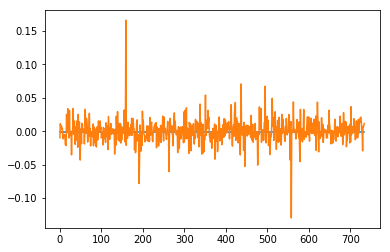

In [20]:
y_pred = model.predict(x_test)
# print(y_pred)
# y_test.head()

plt.plot(y_pred)
plt.plot(y_test['1pred'].reset_index().drop(columns="index"))
plt.show()

# # history = model.fit(X, X, epochs=500, batch_size=len(X), verbose=2)
# # plot metrics
# plt.plot(model_output.history['mean_squared_error'])
# plt.plot(model_output.history['mean_absolute_error'])
# plt.plot(model_output.history['mean_absolute_percentage_error'])
# plt.plot(model_output.history['cosine_proximity'])
# # loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
# # print("Training Accuracy: {:.4f}".format(accuracy))
# # loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
# # print("Testing Accuracy:  {:.4f}".format(accuracy))


# # print('Training Accuracy : ' , np.mean(model_output.history["acc"]))
# # print('Validation Accuracy : ' , np.mean(model_output.history["val_acc"]))



# # # Plot training & validation accuracy values
# # plt.plot(model_output.history['acc'])
# # plt.plot(model_output.history['val_acc'])
# # plt.title('Model accuracy')
# # plt.ylabel('Accuracy')
# # plt.xlabel('Epoch')
# # plt.legend(['Train', 'Test'], loc='upper left')
# # plt.show()

# # # Plot training & validation loss values
# # plt.plot(model_output.history['loss'])
# # plt.plot(model_output.history['val_loss'])
# # plt.title('model_output loss')
# # plt.ylabel('Loss')
# # plt.xlabel('Epoch')
# # plt.legend(['Train', 'Test'], loc='upper left')
# # plt.show()